In [57]:
import numpy as np
import torch
import gymnasium as gym
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils import tensorboard

import sys
sys.path.insert(0, "Code/src/")

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


from environment import *

In [58]:
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.wrappers import Wrapper, ImgObsWrapper
import numpy as np

In [59]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [60]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

In [61]:
class Actor(nn.Module):
    def __init__(self, state_dim=3, n_actions=7, activation=nn.Tanh):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(state_dim, 8, kernel_size=3, stride=2, padding=1),  # (3,7,7) -> (8,4,4)
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # (8,4,4) -> (16,2,2)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (16,2,2) -> (32,1,1)
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 1 * 1, 32),  # Reduced from 1024 to just 32
            activation(),
            nn.Linear(32, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, X):
        X = X.permute(2, 0, 1).unsqueeze(0)  # (7,7,3) → (1,3,7,7)
        X = self.cnn(X)
        return self.fc(X)

In [62]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim=3, n_actions=7, activation=nn.Tanh):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(state_dim, 8, kernel_size=3, stride=2, padding=1),  # (3,7,7) -> (8,4,4)
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # (8,4,4) -> (16,2,2)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (16,2,2) -> (32,1,1)
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 1 * 1, 32),  # Reduced from 1024 to just 32
            activation(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        X = X.permute(2, 0, 1).unsqueeze(0)  # (7,7,3) → (1,3,7,7)
        X = self.cnn(X)
        return self.fc(X)

In [63]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

def policy_loss(old_log_prob, log_prob, advantage, eps):
    ratio = (log_prob - old_log_prob).exp()
    clipped = torch.clamp(ratio, 1-eps, 1+eps)*advantage
    
    m = torch.min(ratio*advantage, clipped)
    return -m



In [64]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class CustomManualControl(ManualControl):
    def key_handler(self, event):
        # If the 't' key is pressed, execute the pickup action.
        if event.key == 't':
            print('here')
            self.step(self.env.actions.pickup)
        else:
            # For other keys, fall back to the default behavior.
            super().key_handler(event)

(7, 7, 3)


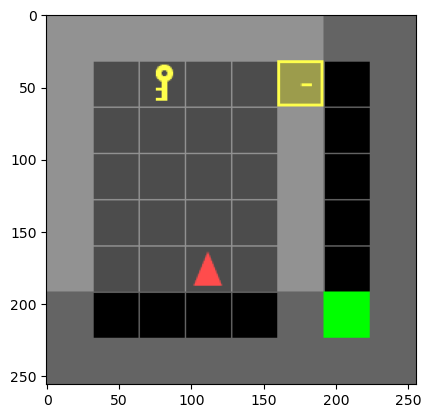

In [65]:
## PPO for gridworld environment

#svf_exp += self.env.gamma**step * self.env.get_svf_features(state=self.state)
#rewards += self.env.gamma**step * self.env.get_rewards(state=self.state)
#self.state = self.env.take_action(self.state, a)

from minigrid.wrappers import ActionBonus, PositionBonus

#   GridWorldEnvironment(0, 10, prop=0)
env = SimpleEnv(render_mode='rgb_array')
env = ImgObsWrapper(env)
env = ActionBonus(env)

env = gym.make("MiniGrid-DoorKey-8x8-v0", render_mode='rgb_array')
env = ImgObsWrapper(env)
env = PositionBonus(env)
env.reset()
print(env.step(0)[0].shape)

img = env.render()
plt.imshow(img)

In [66]:
# config
state_dim = 3
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)
adam_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)

torch.manual_seed(1)

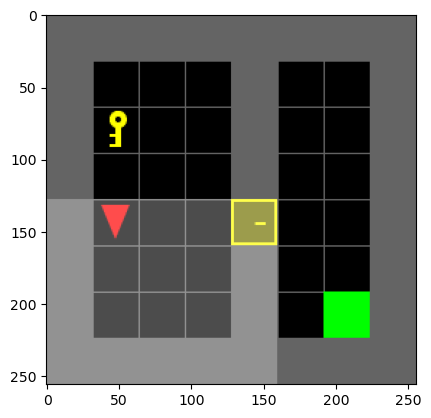

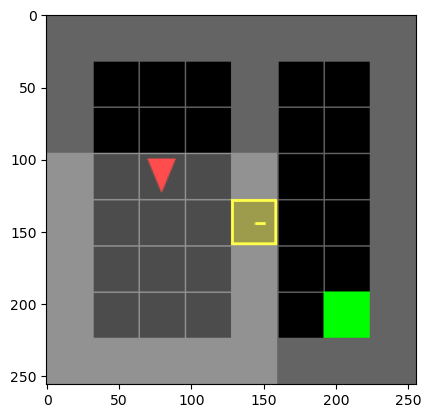

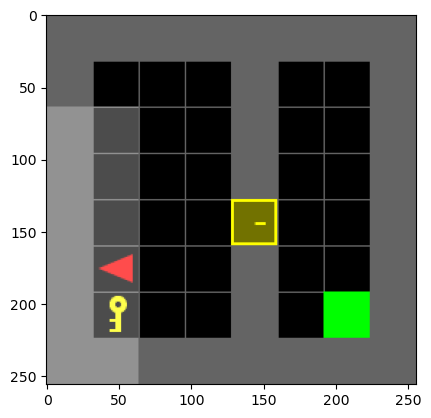

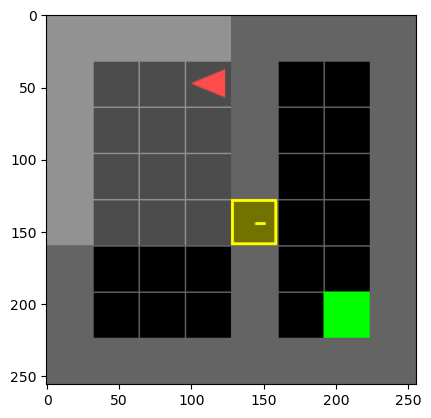

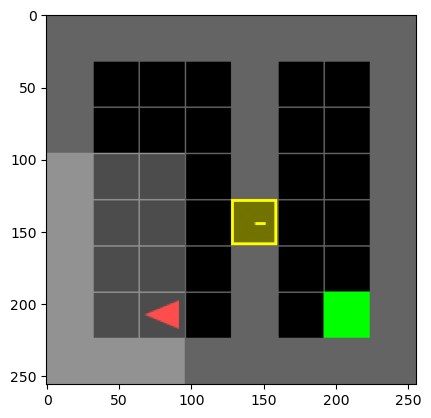

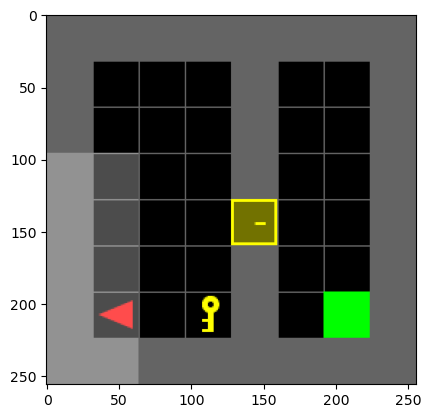

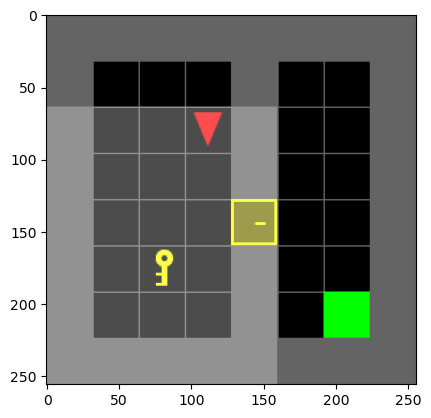

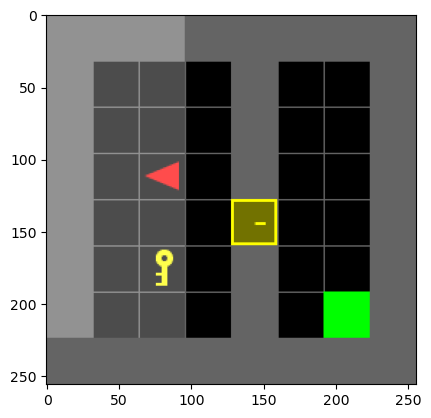

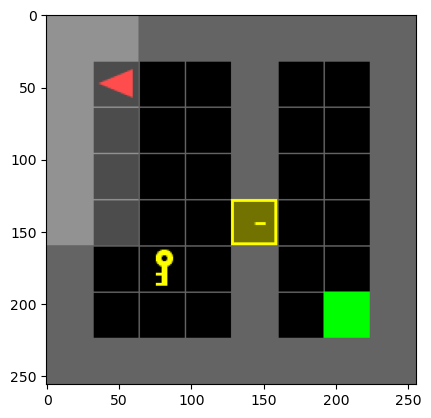

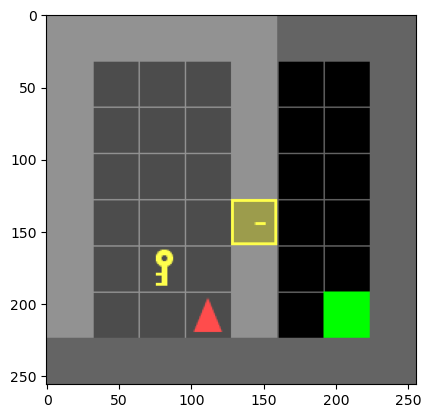

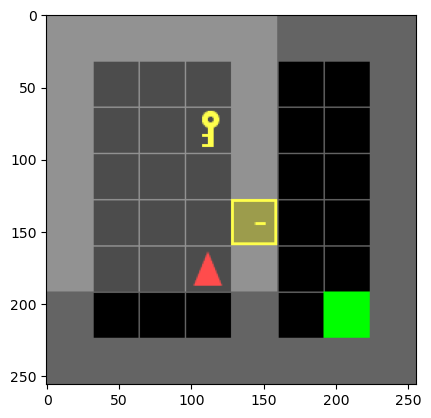

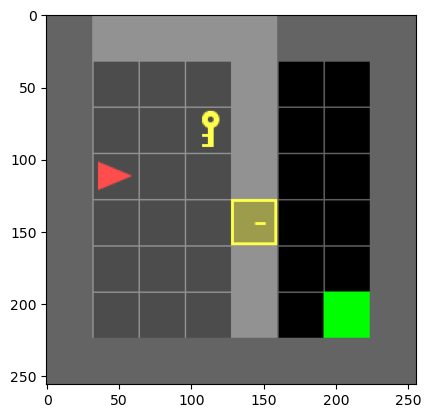

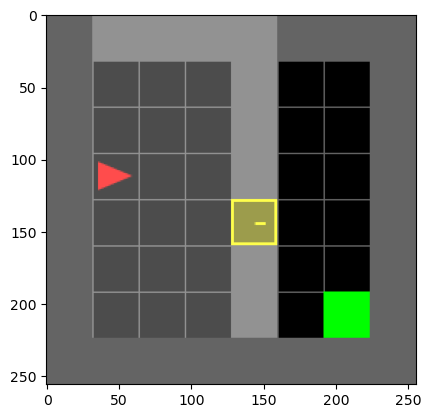

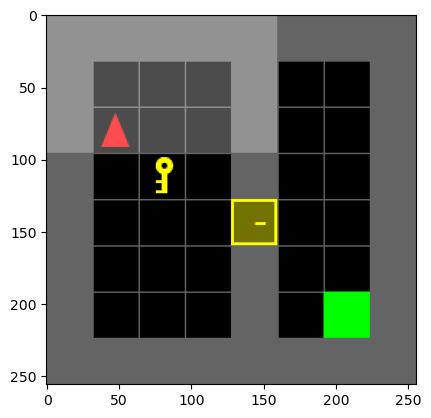

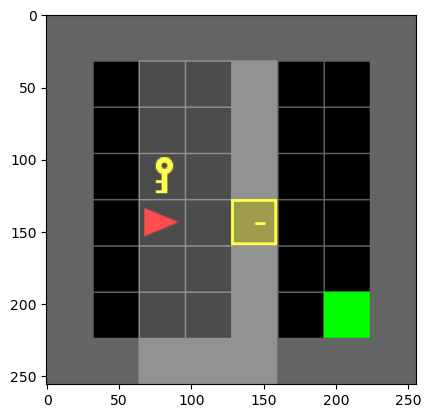

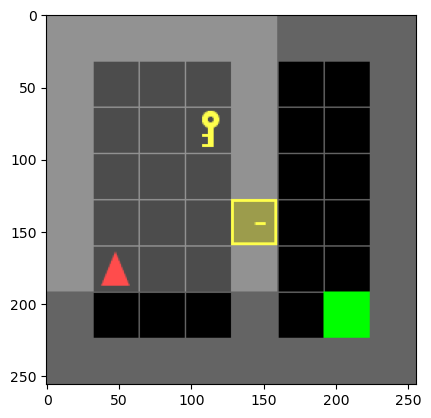

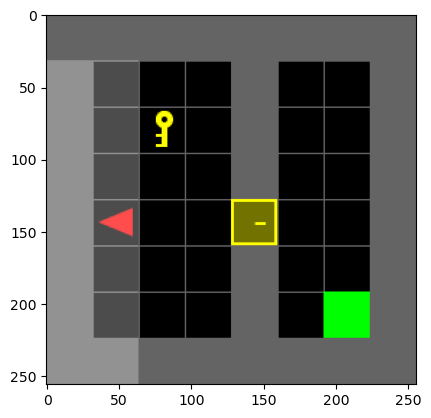

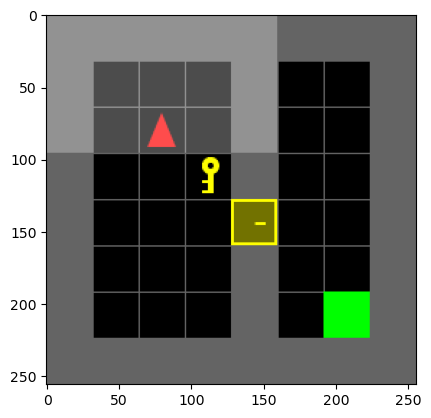

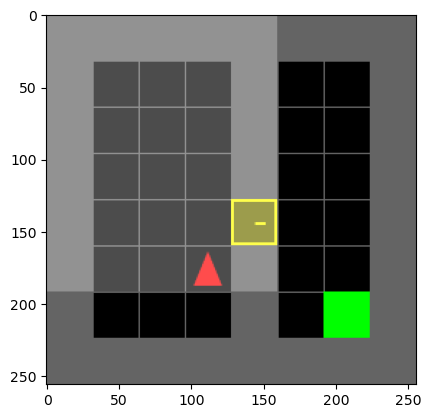

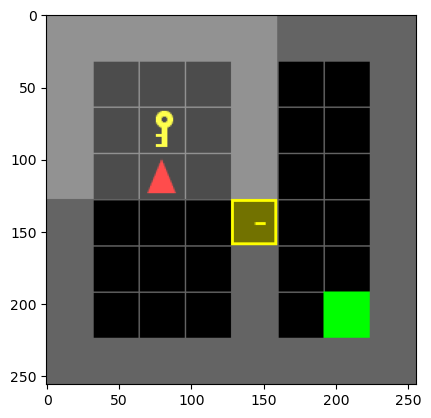

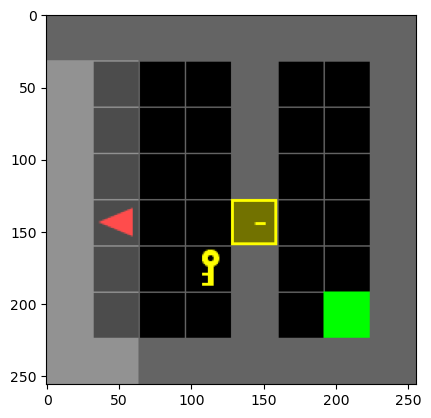

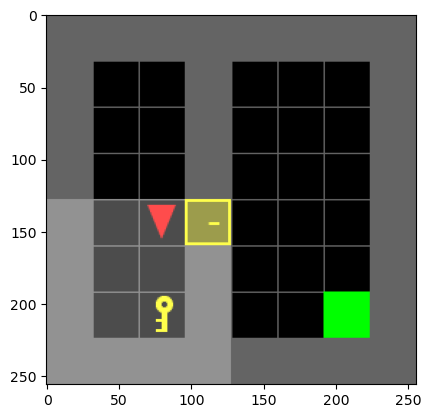

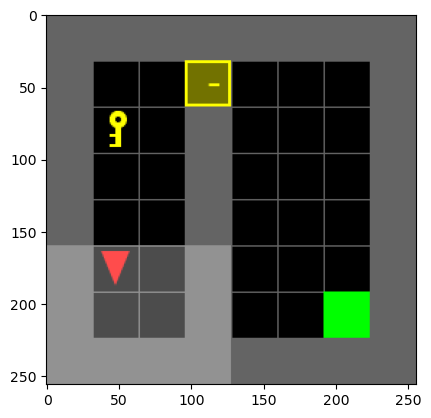

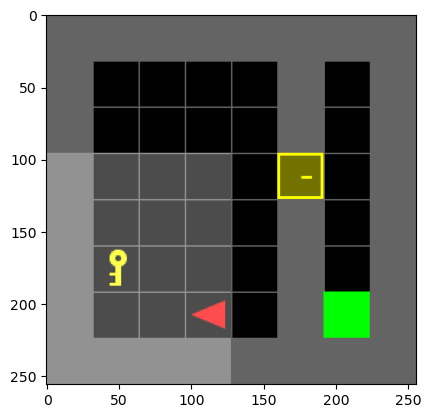

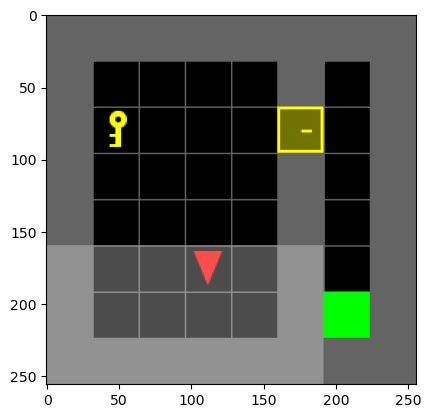

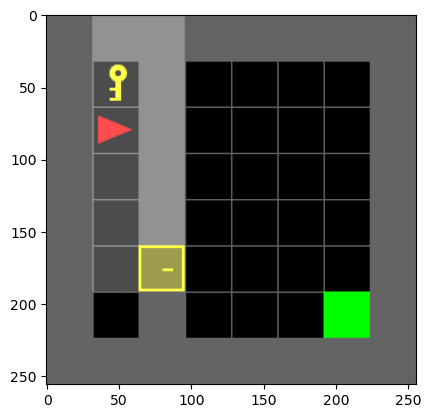

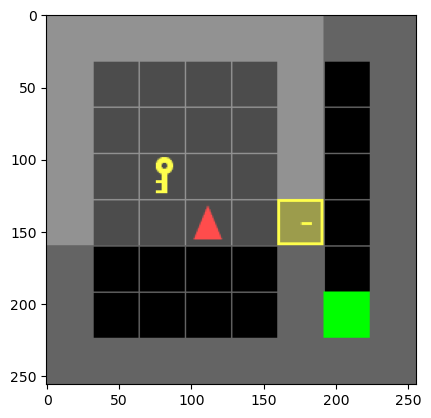

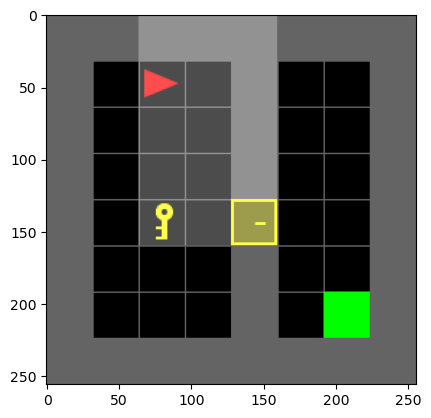

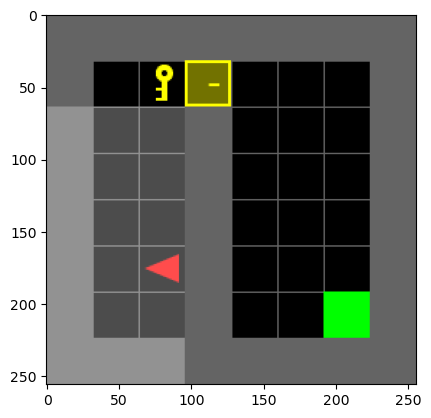

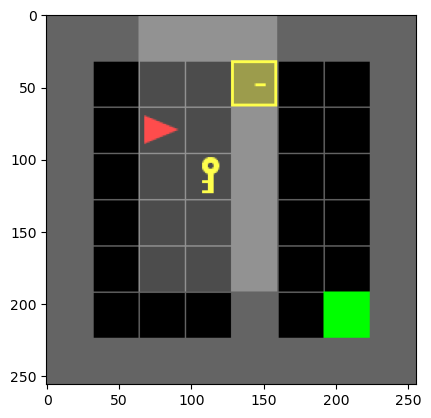

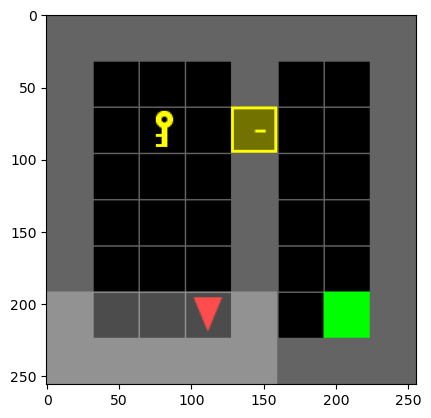

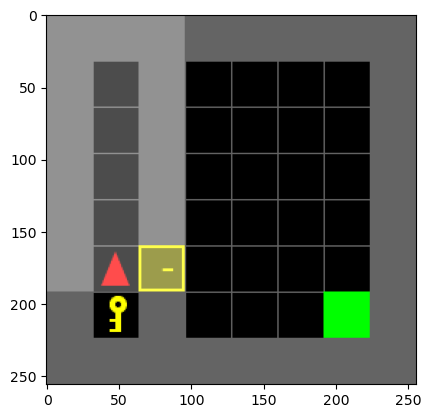

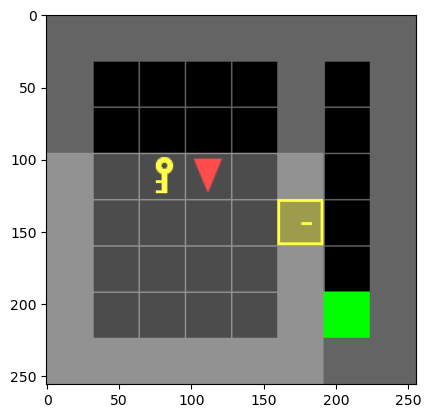

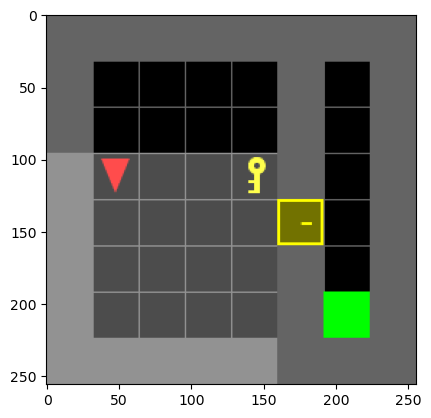

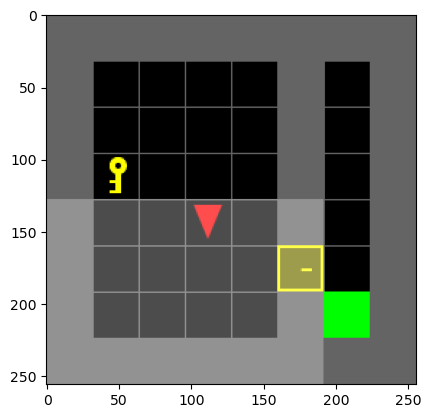

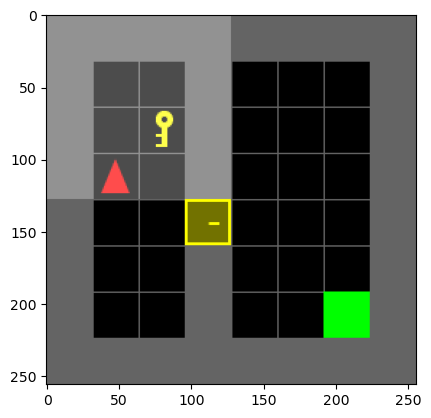

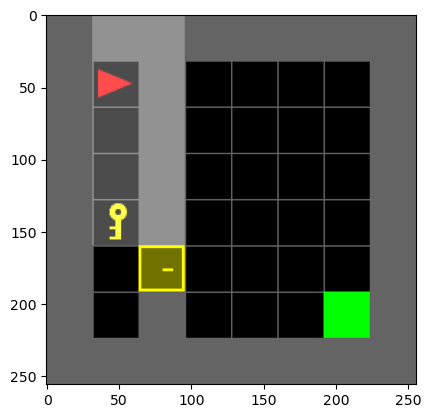

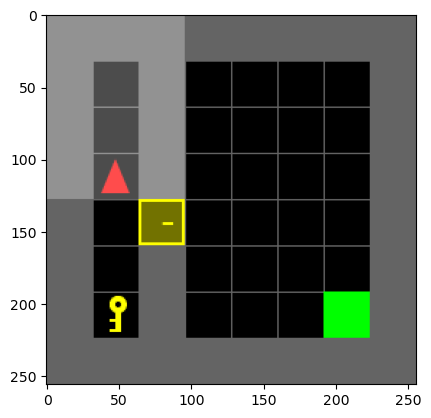

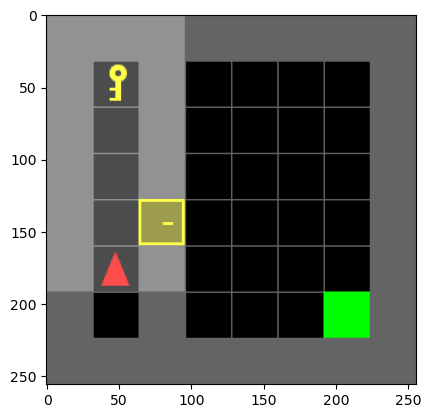

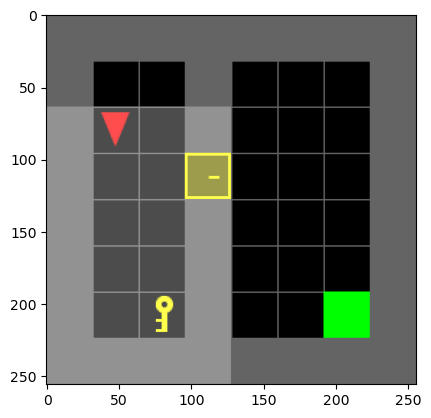

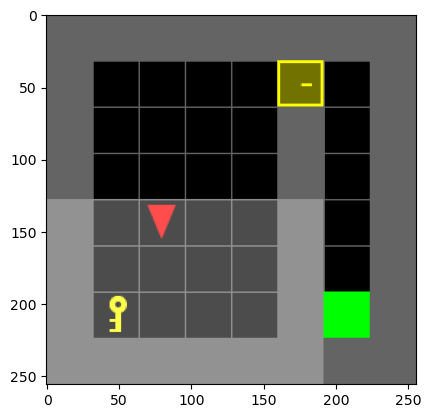

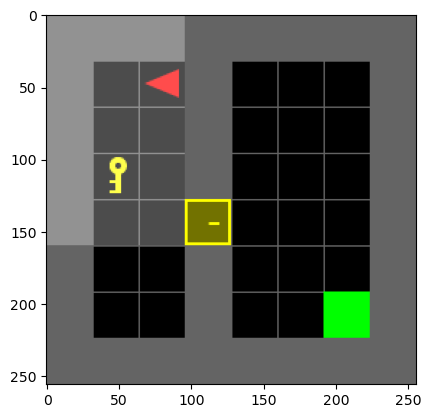

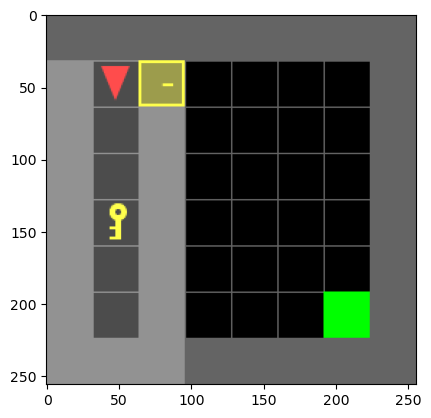

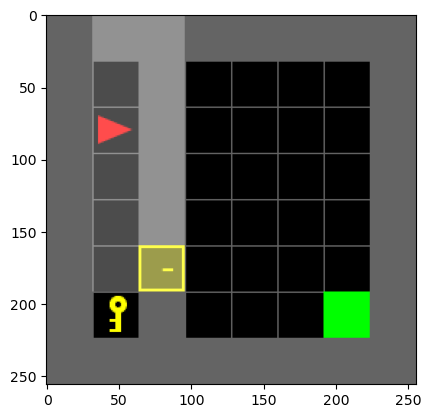

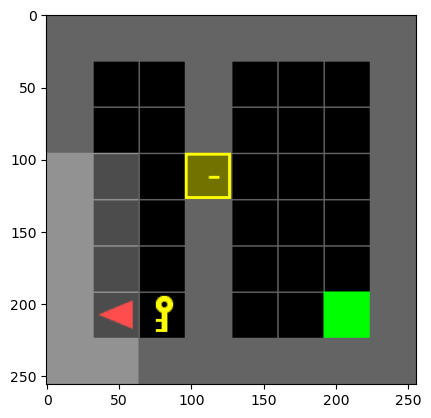

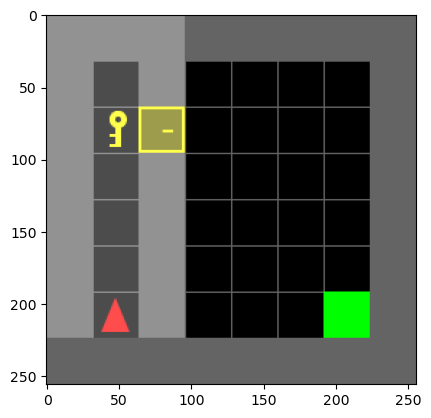

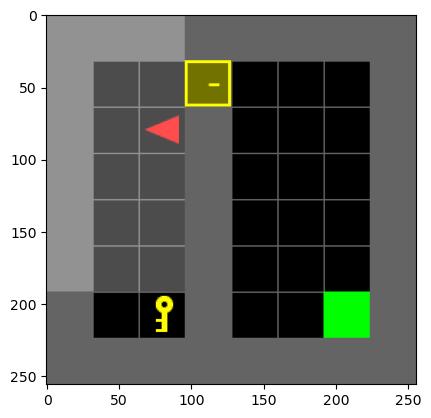

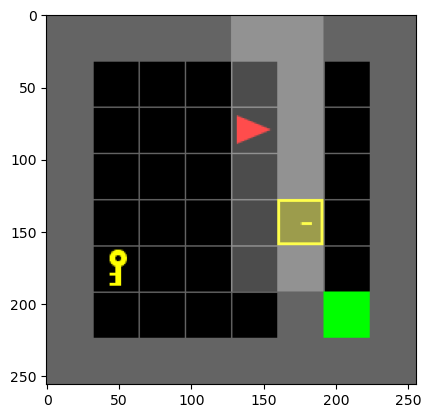

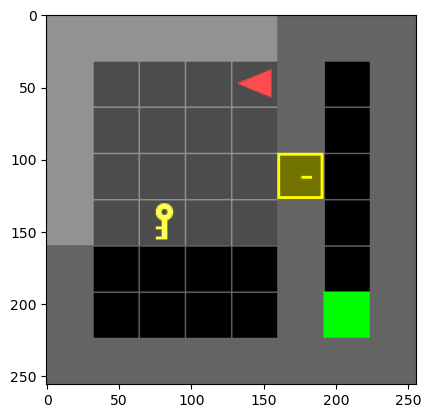

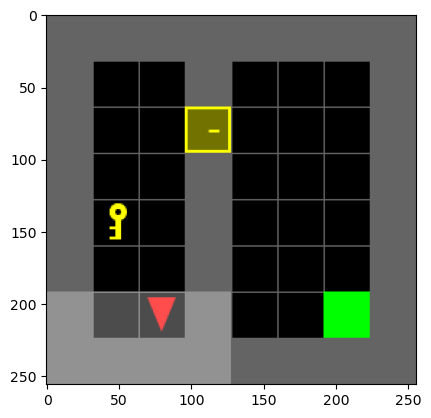

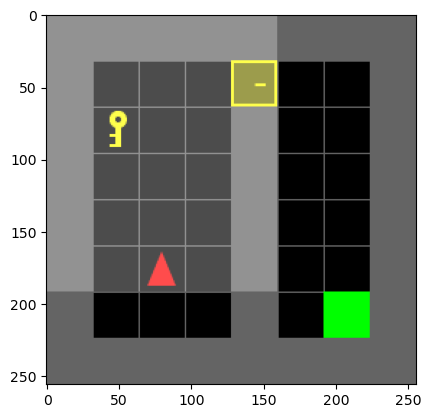

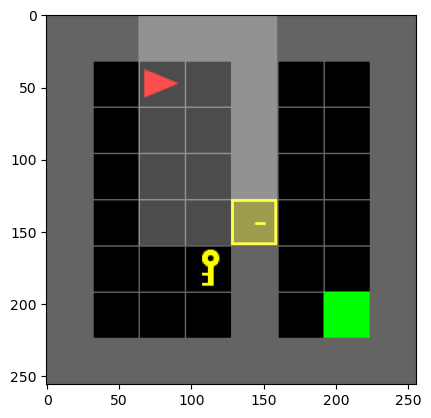

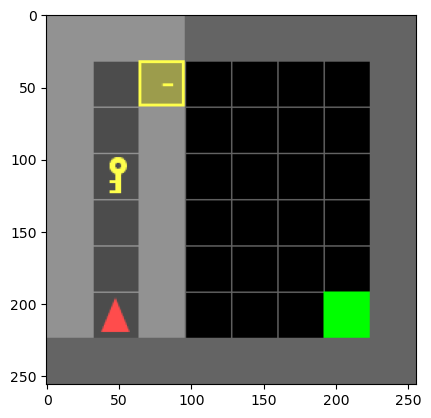

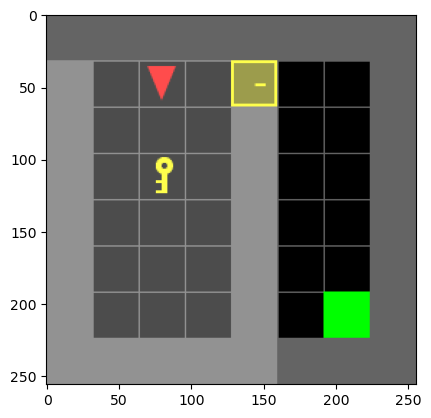

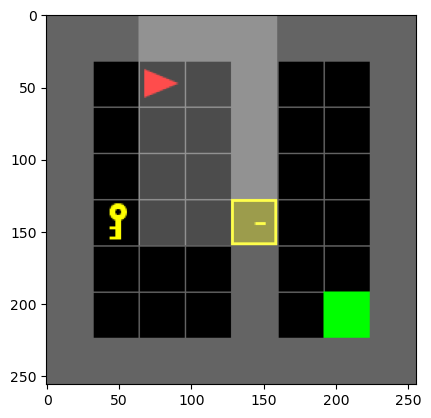

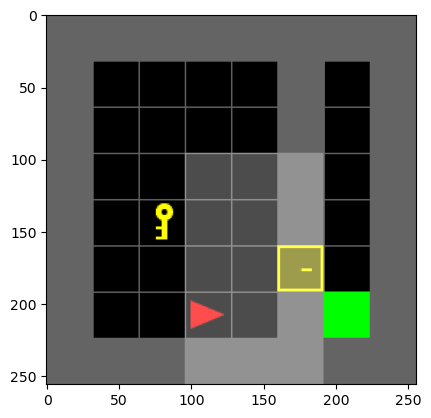

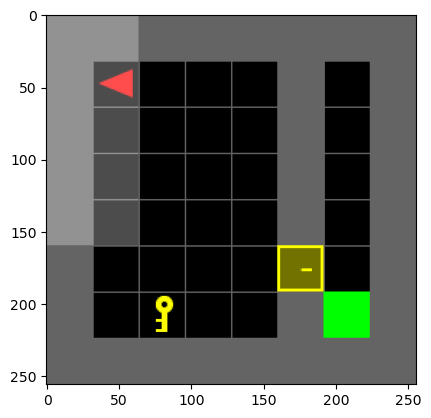

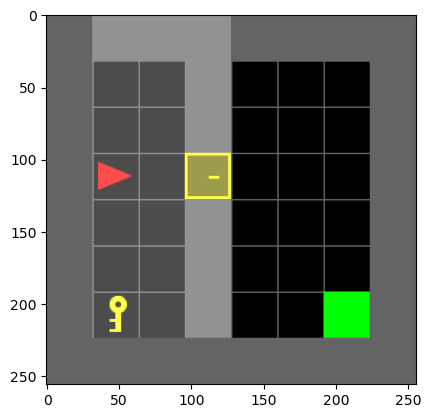

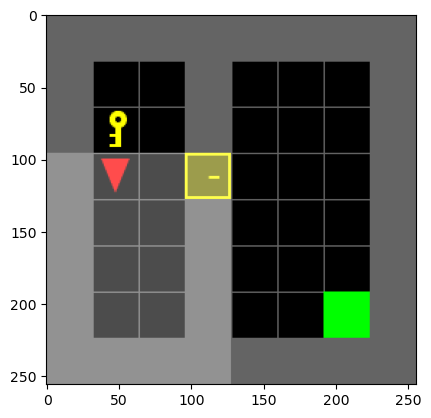

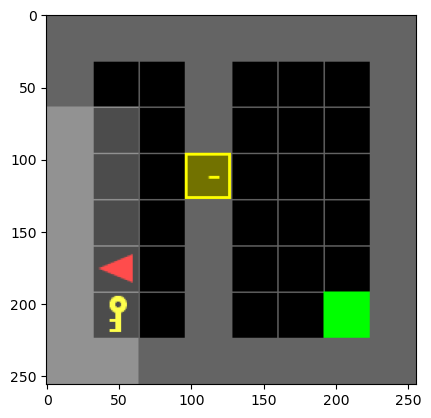

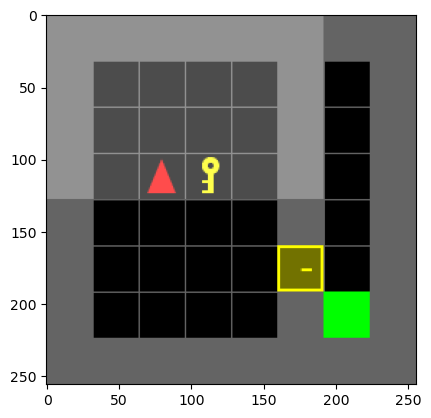

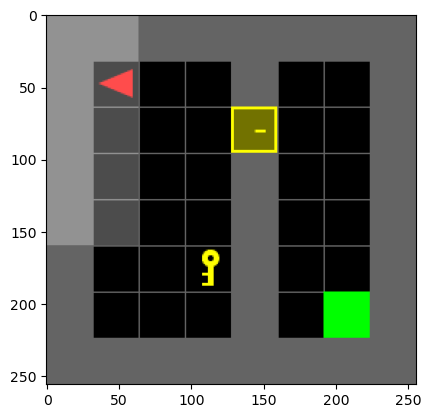

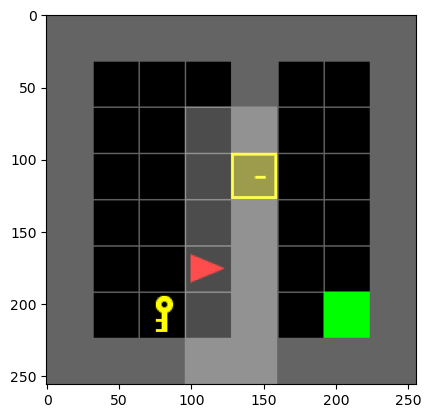

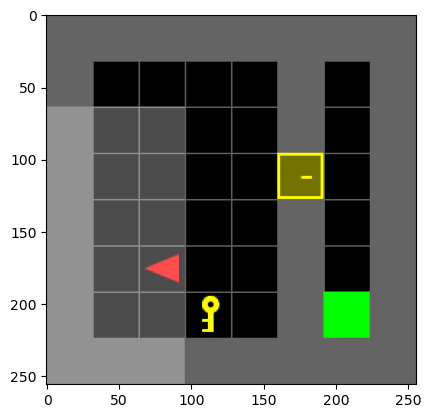

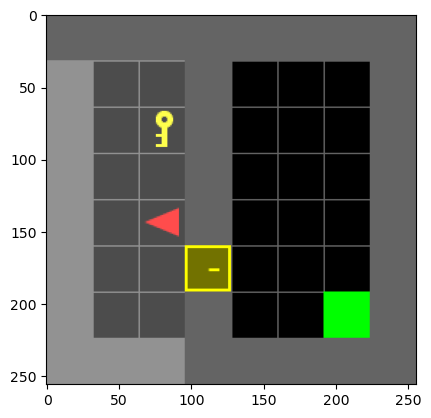

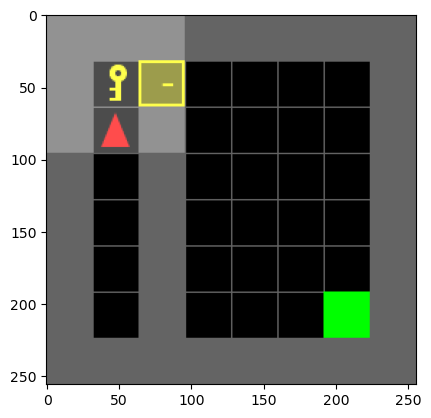

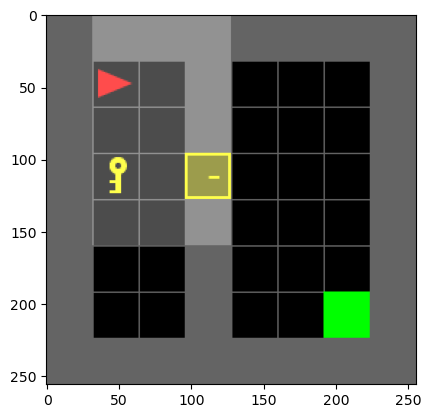

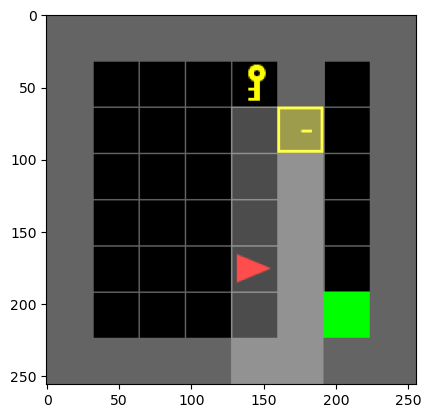

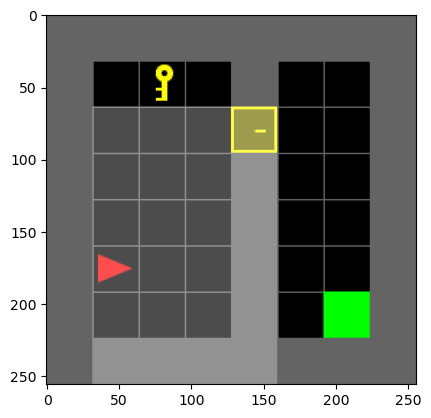

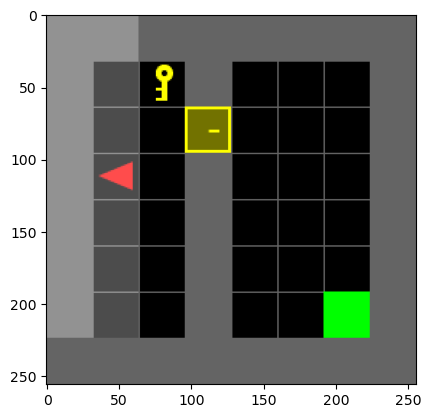

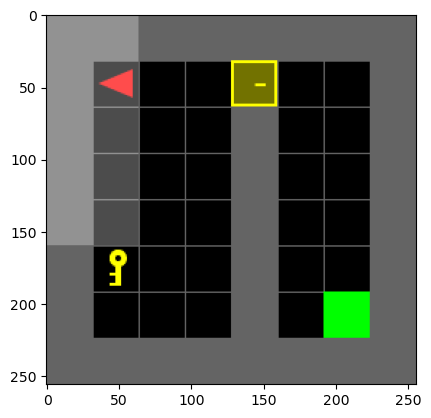

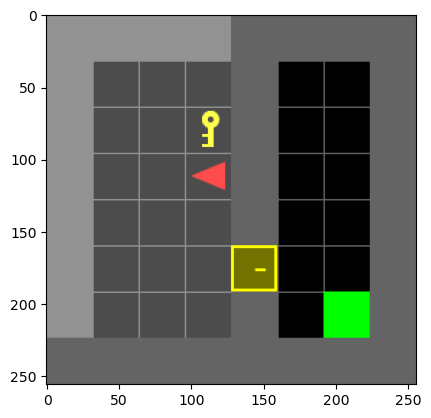

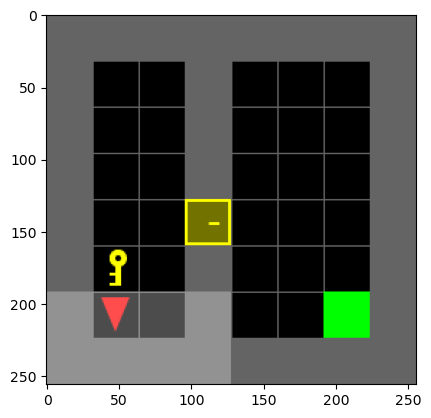

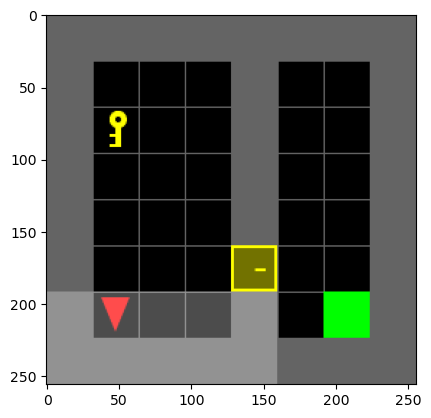

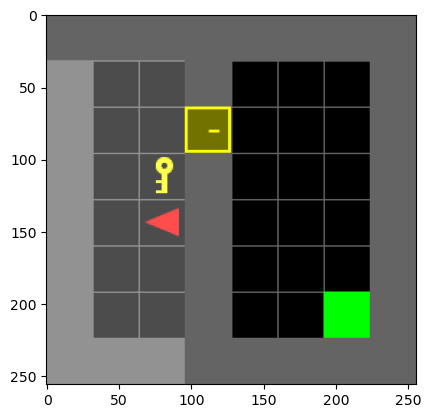

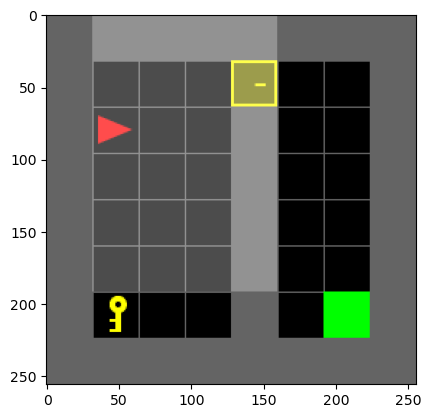

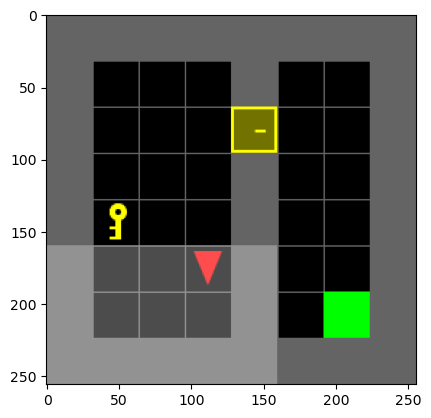

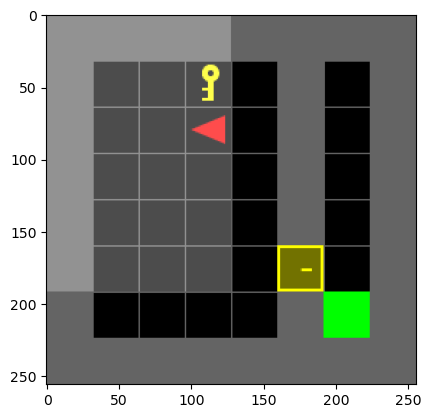

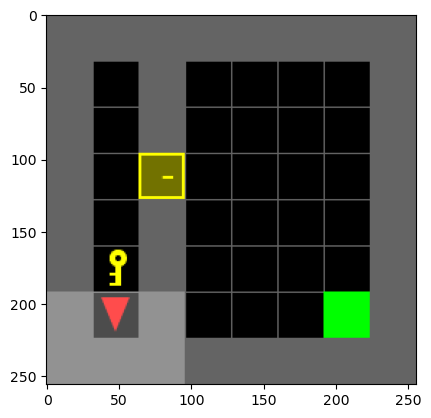

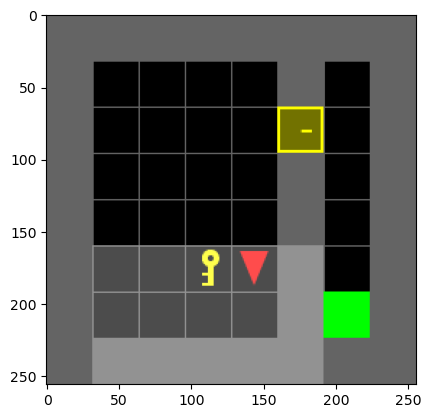

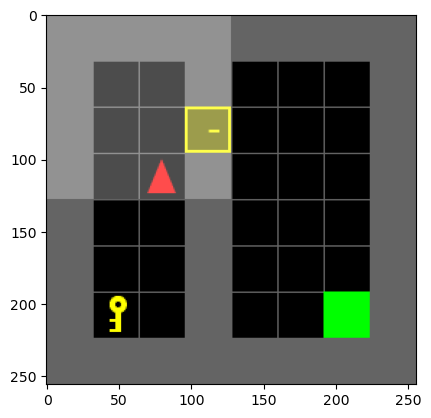

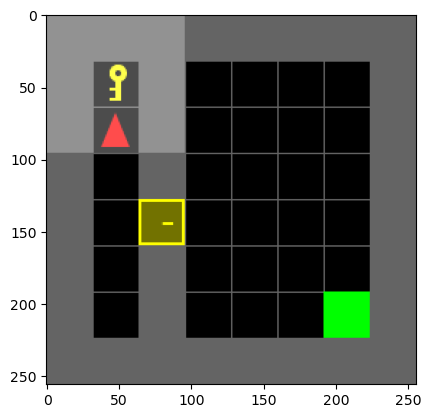

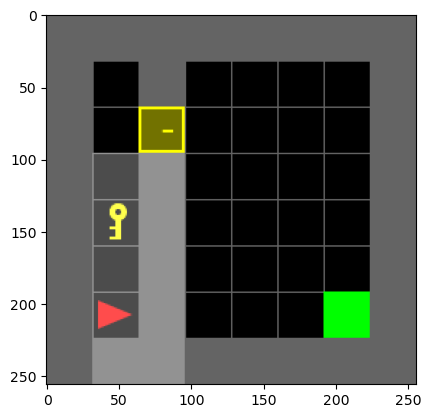

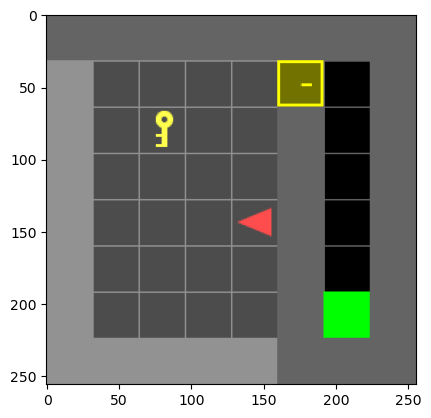

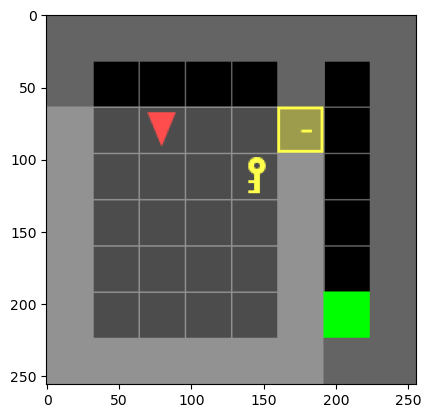

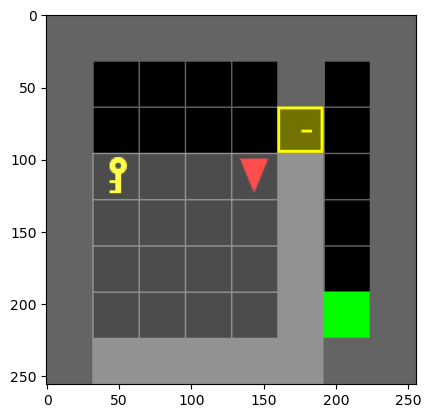

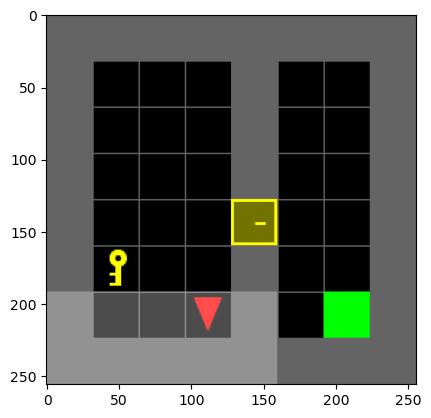

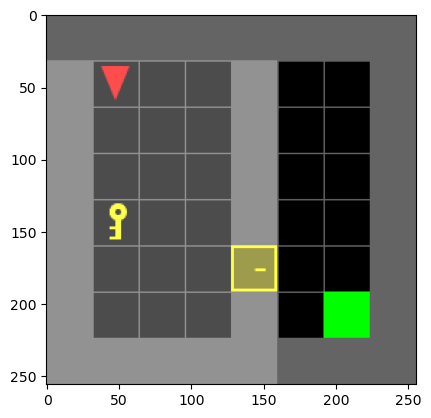

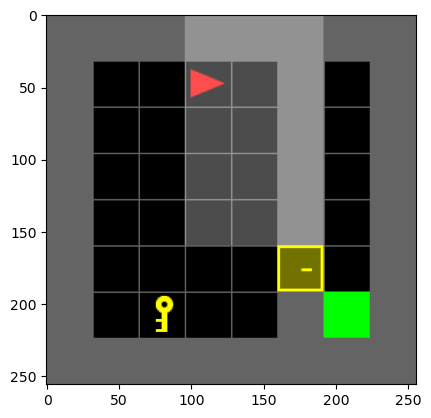

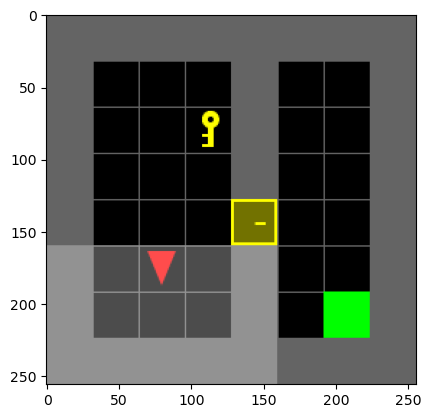

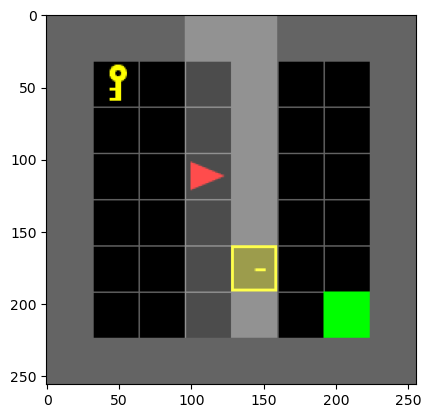

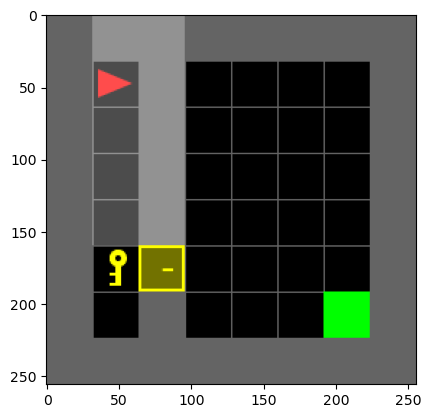

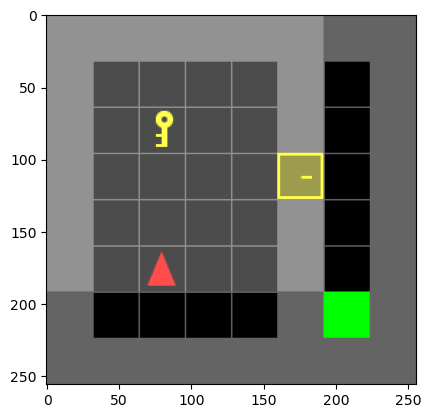

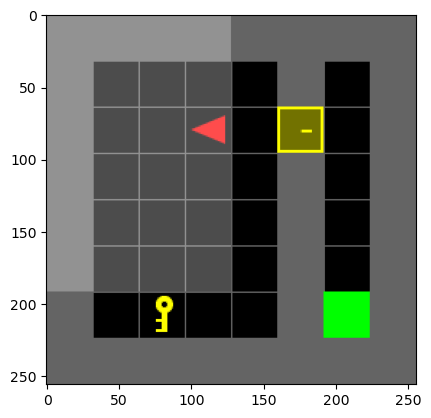

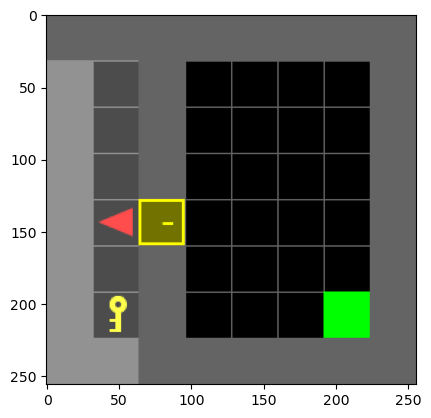

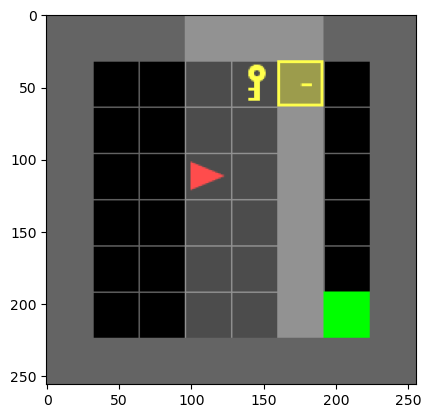

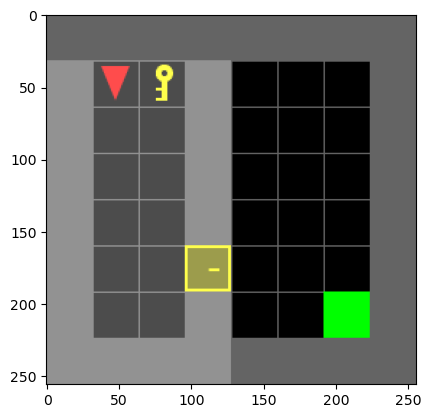

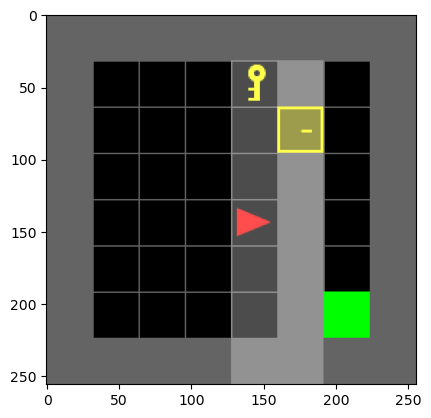

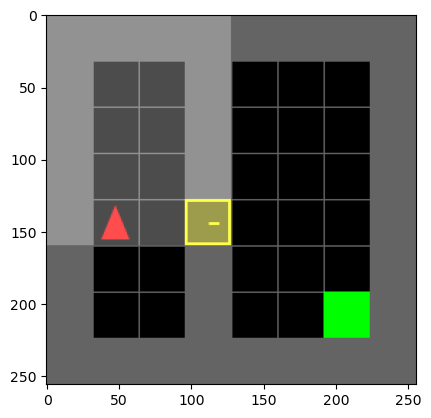

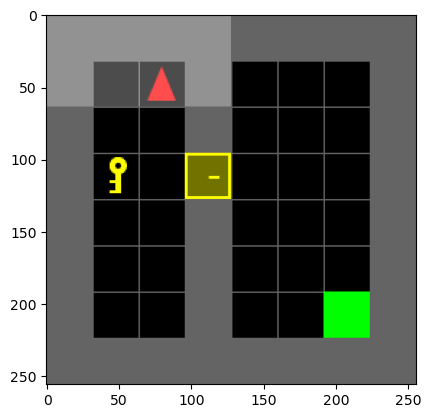

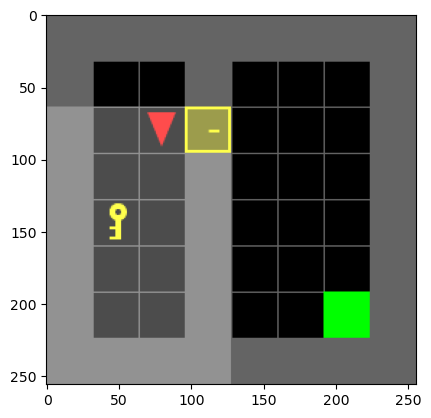

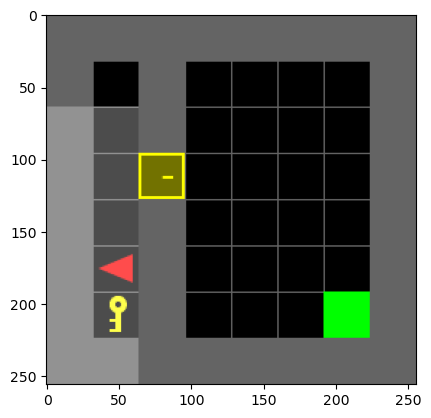

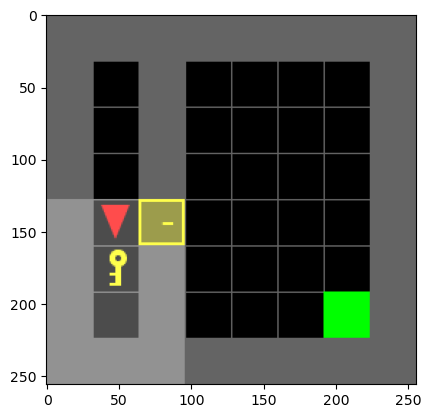

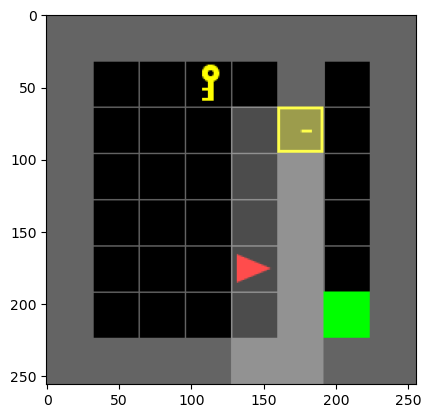

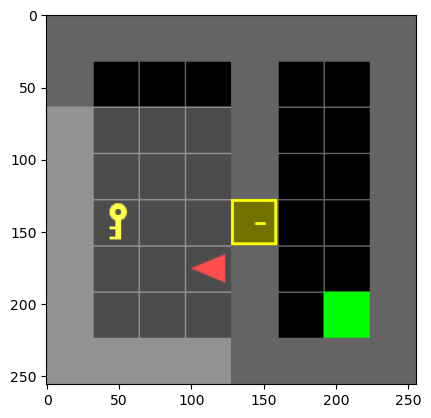

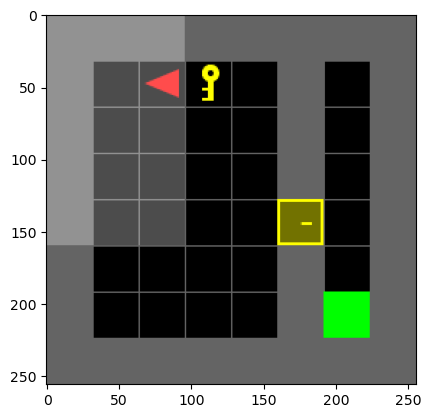

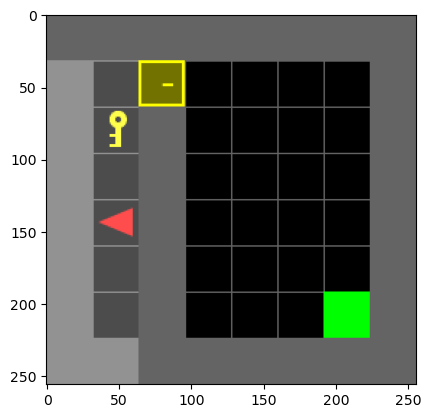

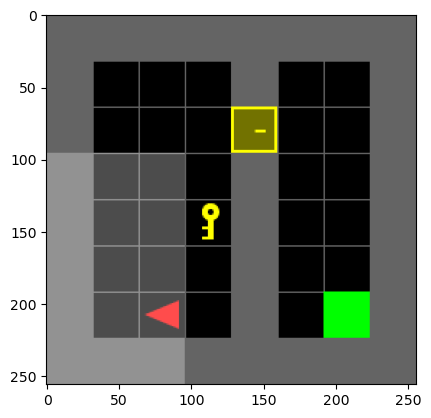

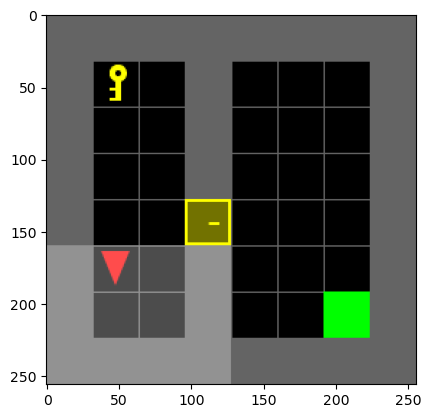

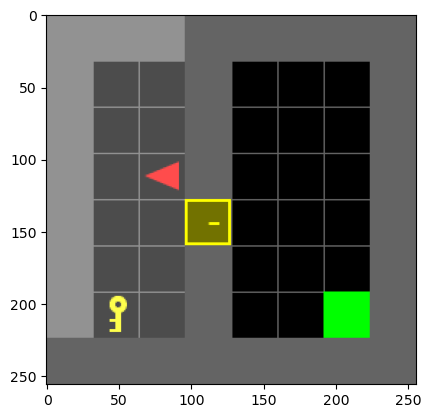

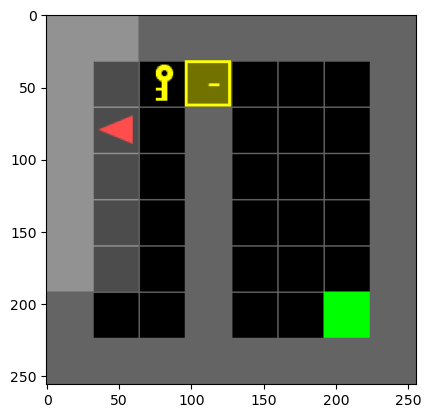

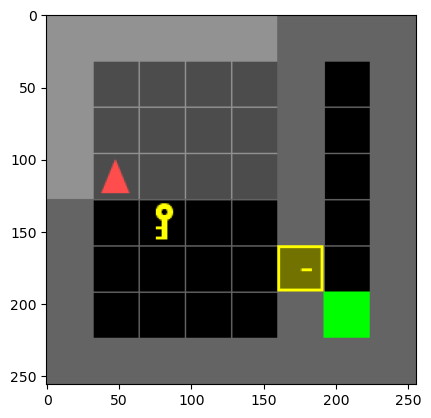

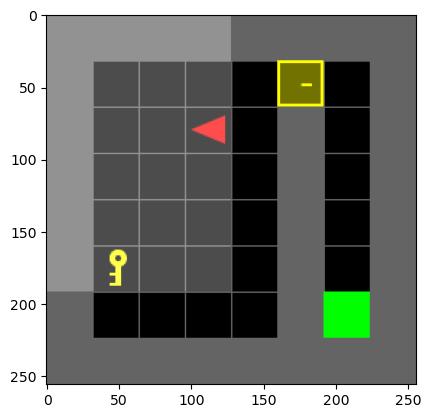

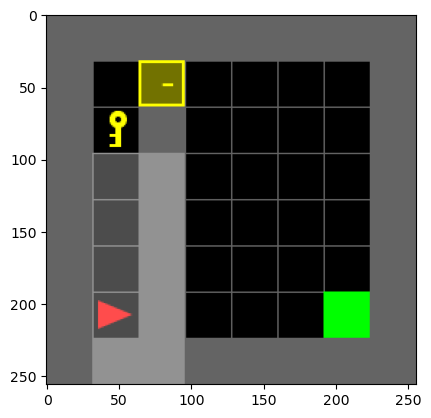

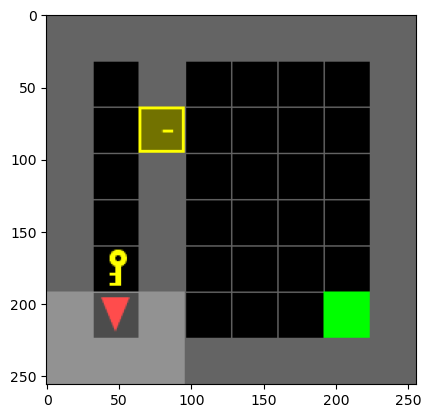

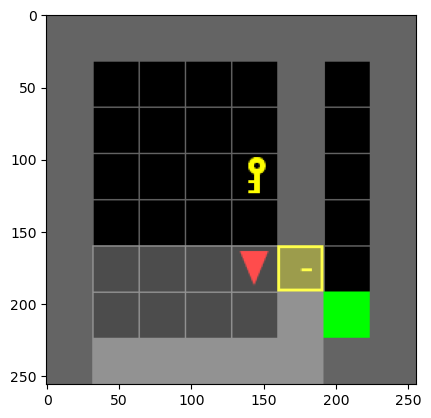

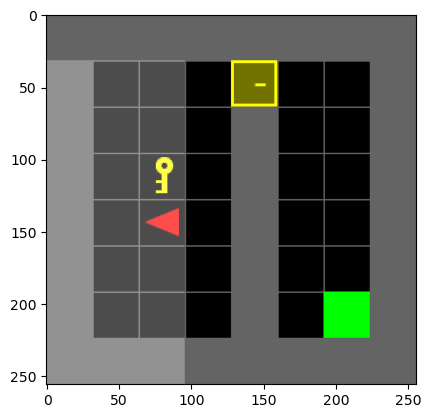

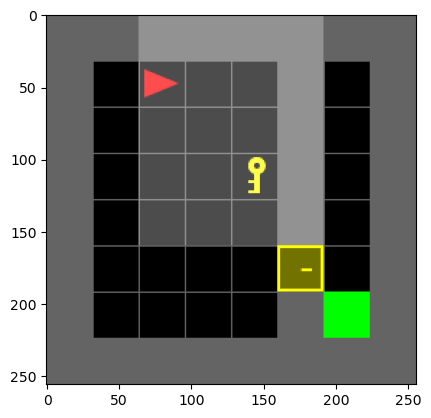

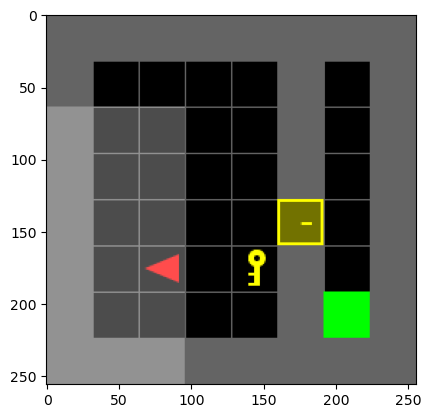

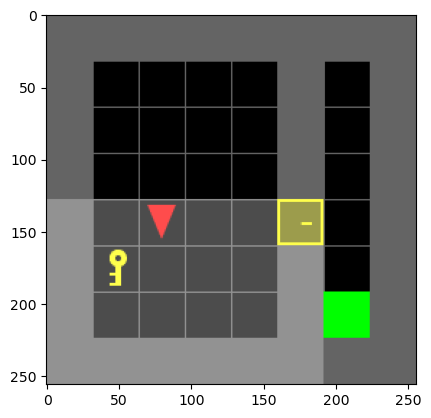

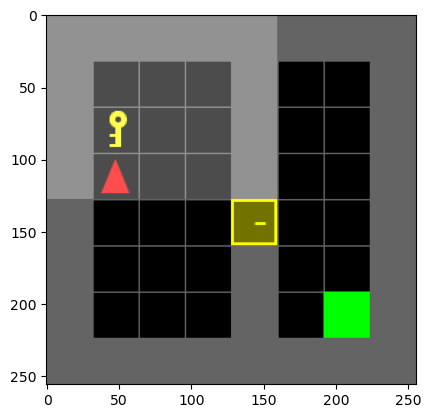

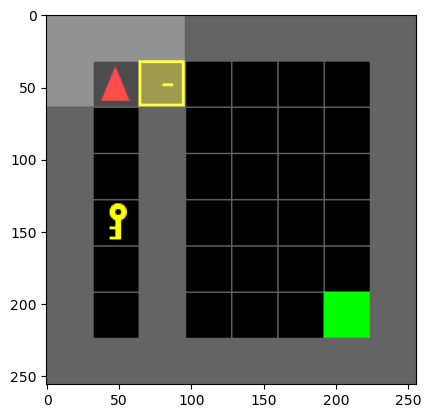

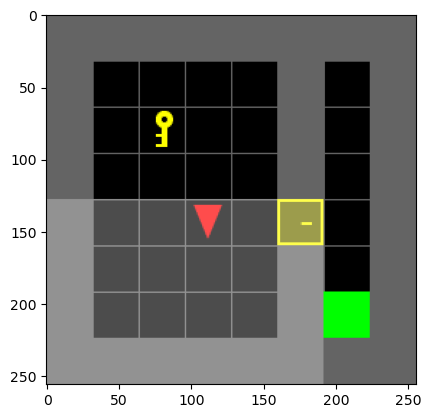

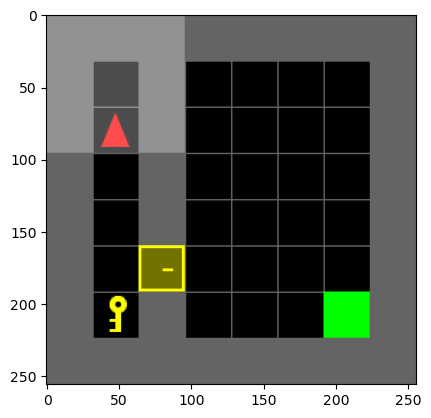

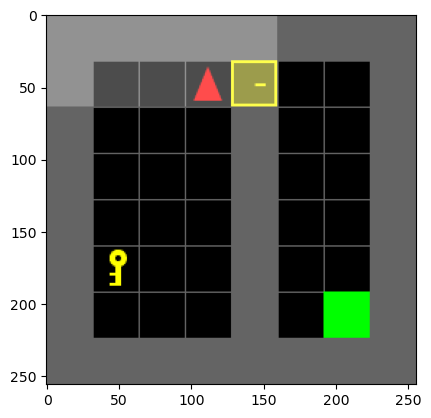

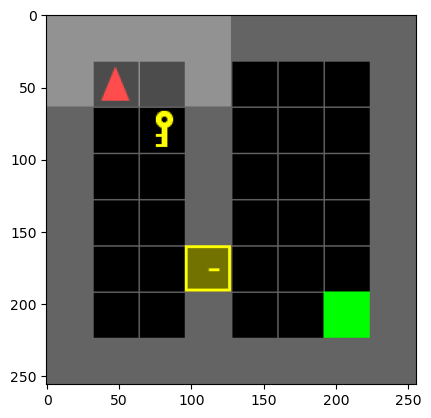

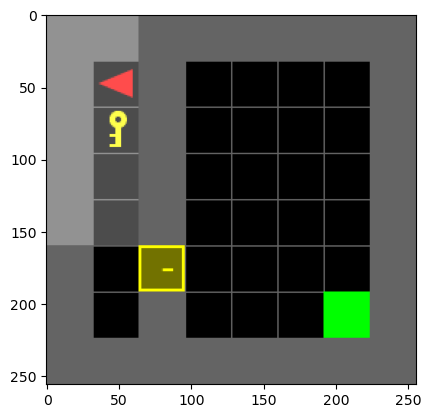

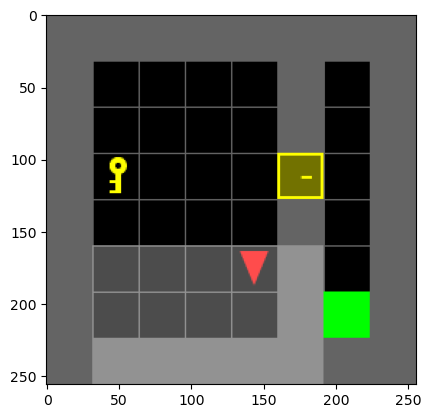

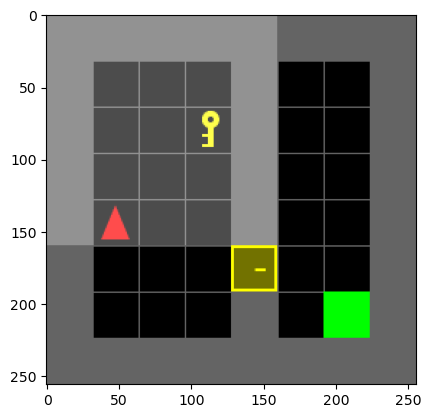

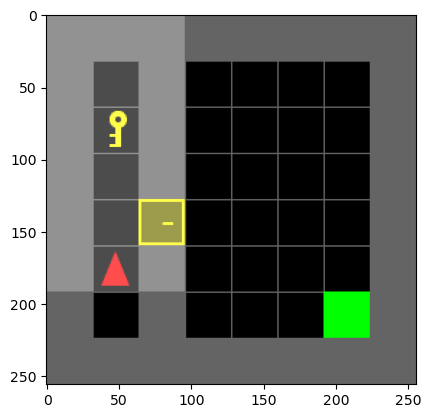

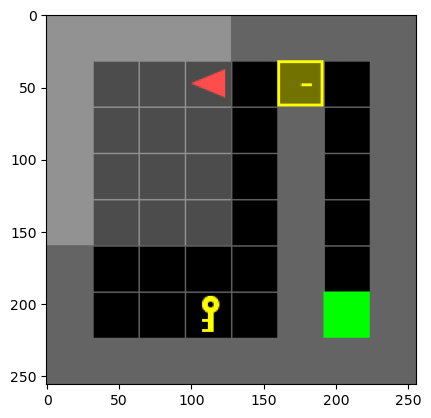

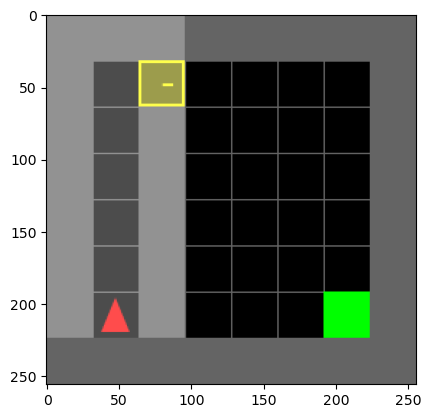

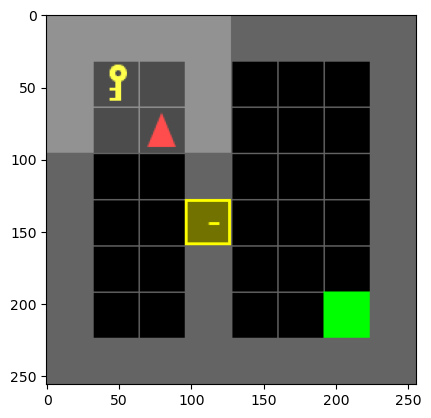

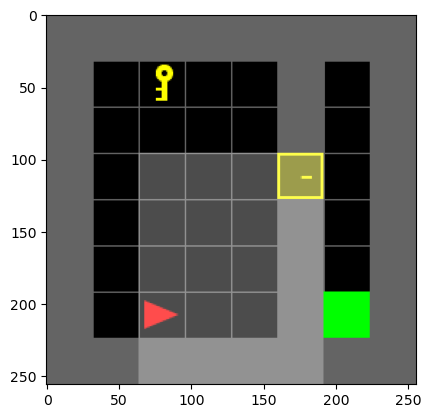

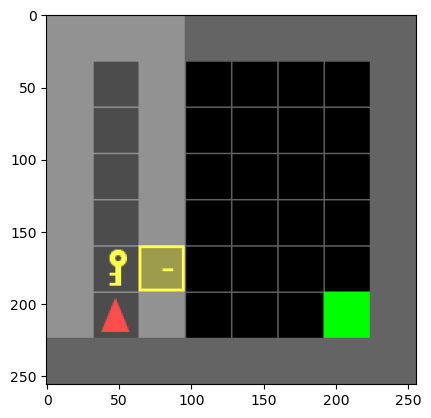

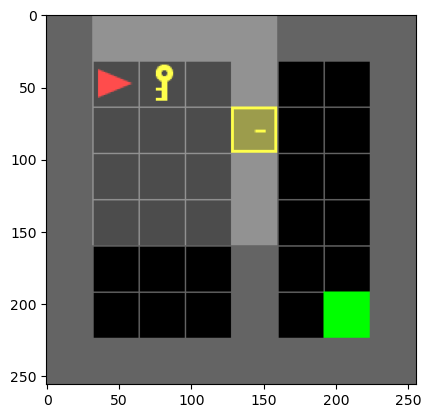

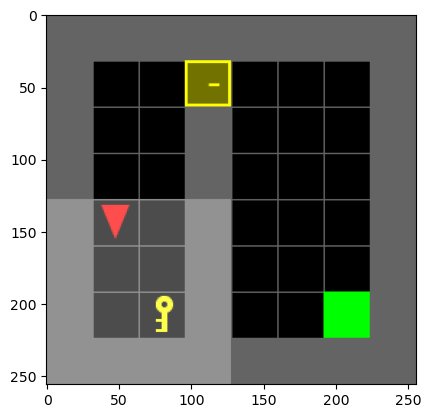

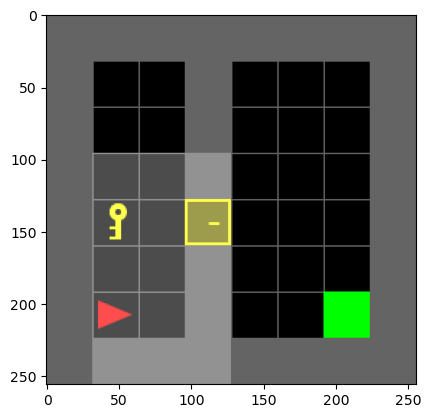

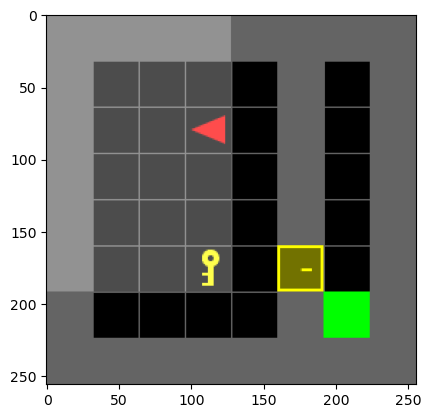

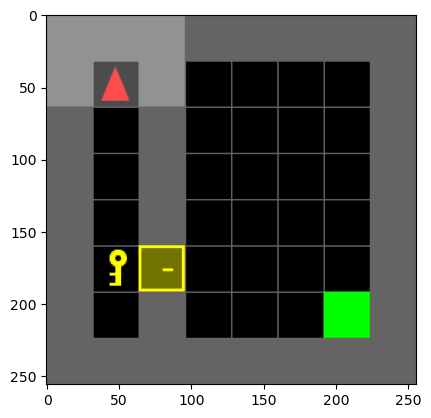

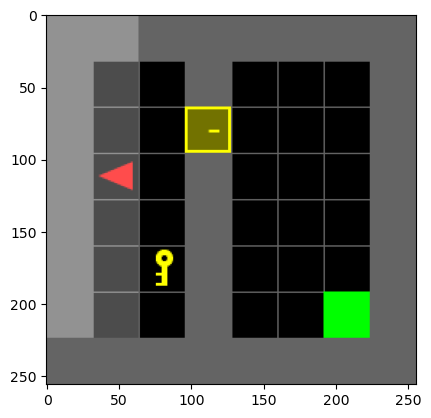

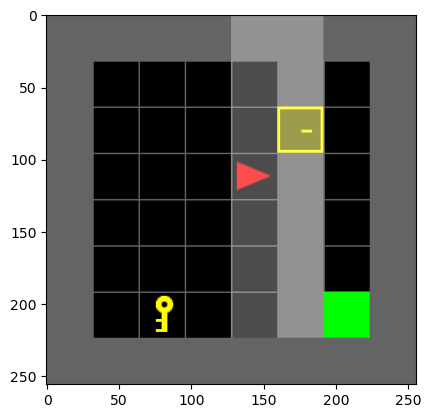

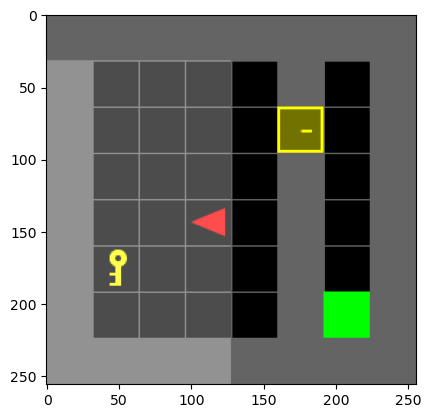

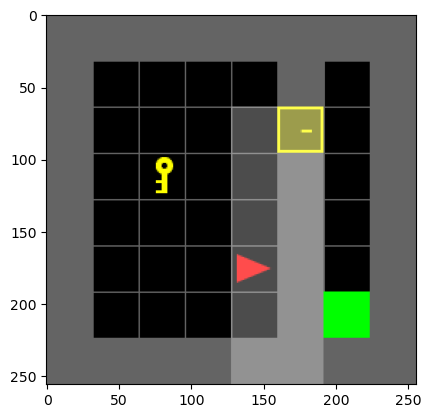

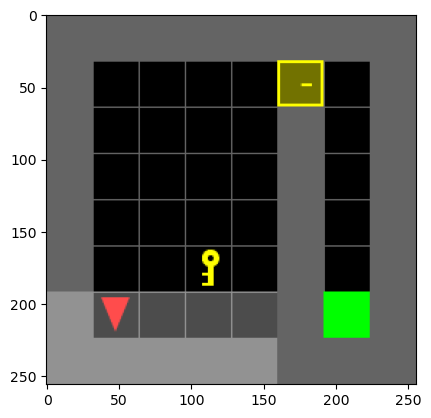

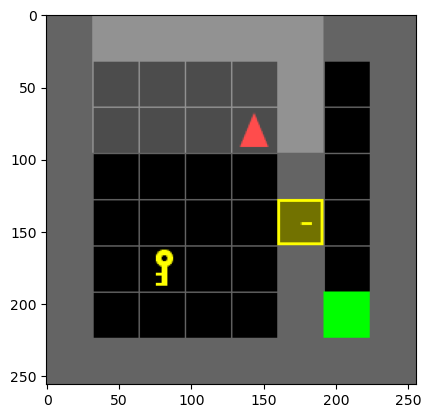

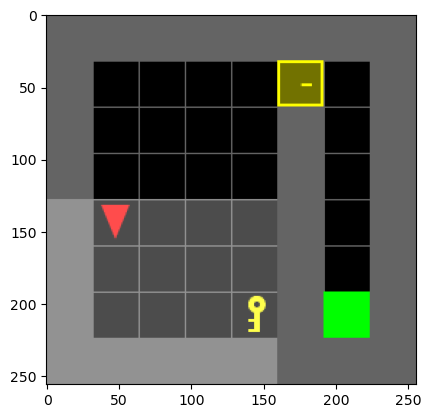

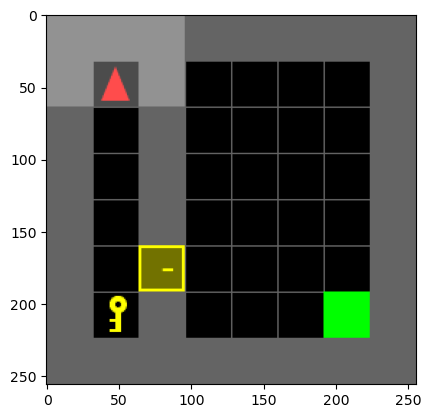

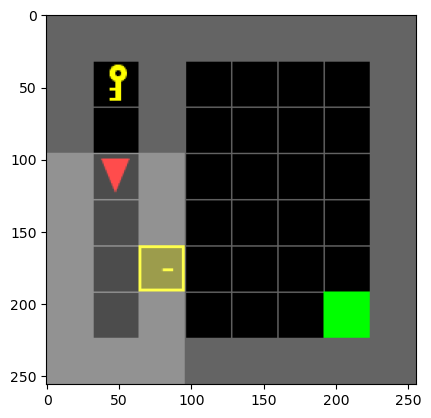

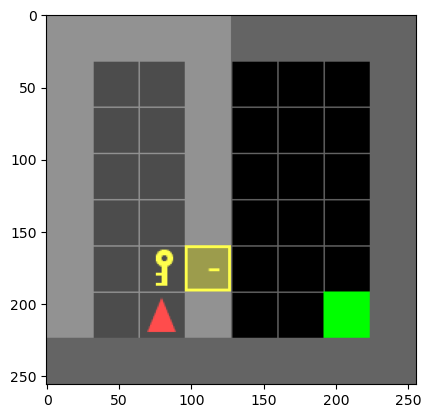

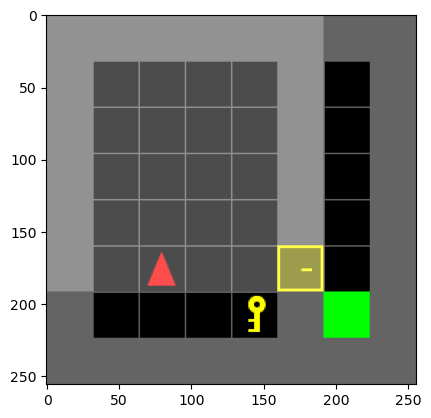

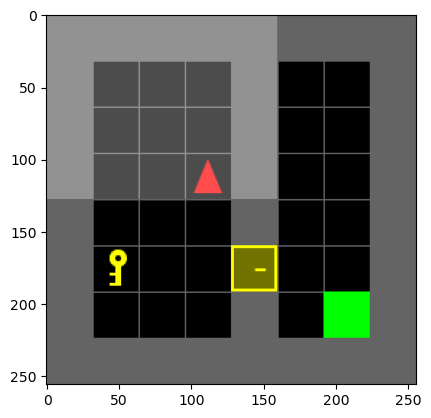

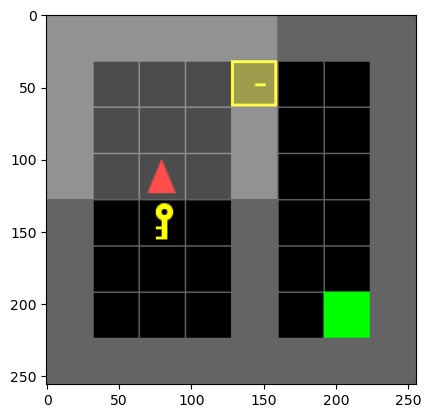

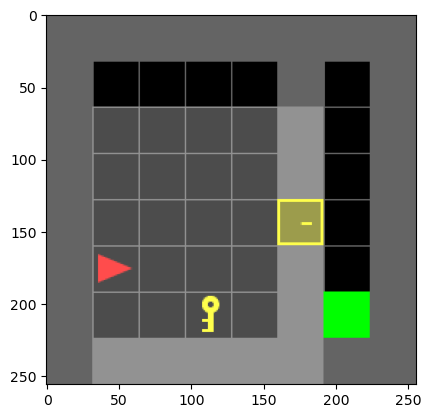

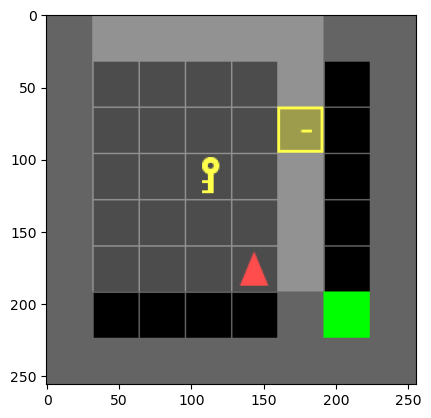

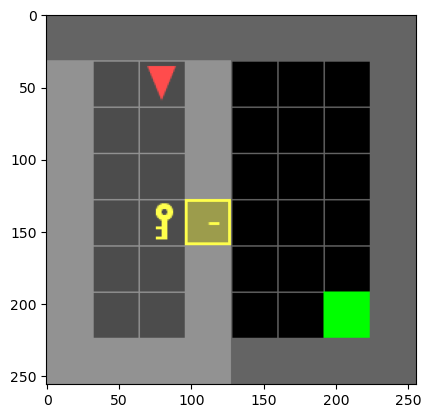

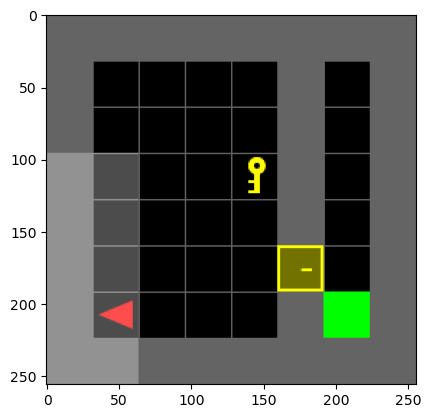

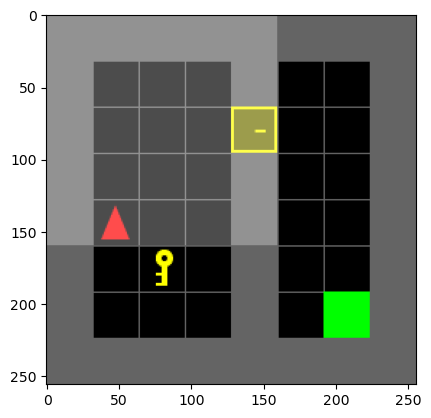

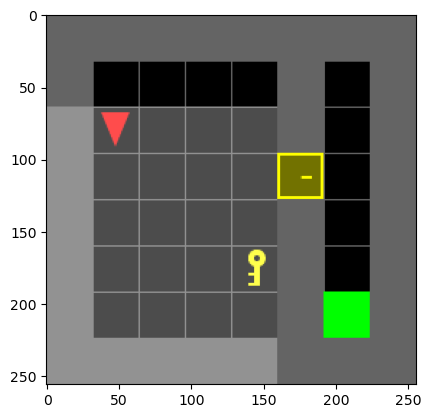

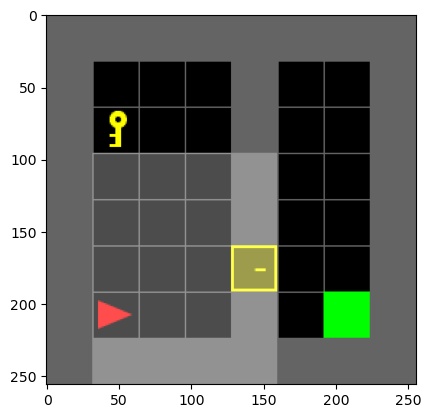

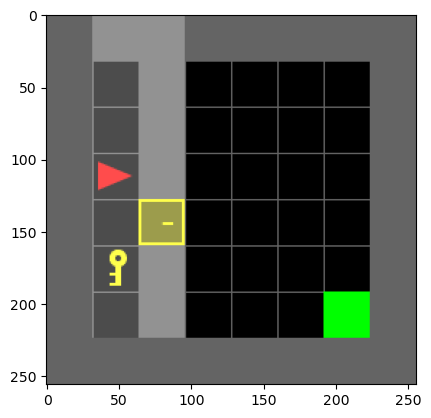

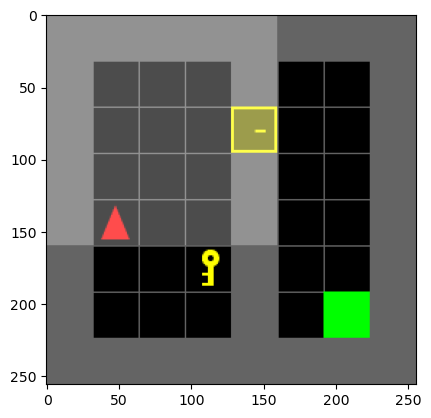

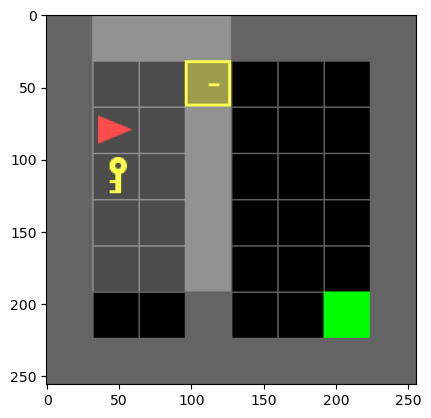

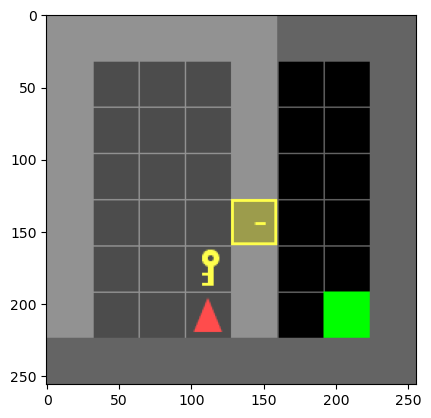

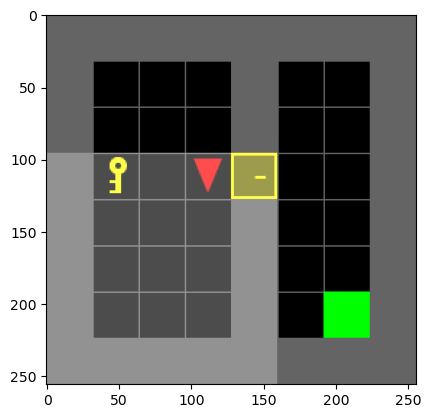

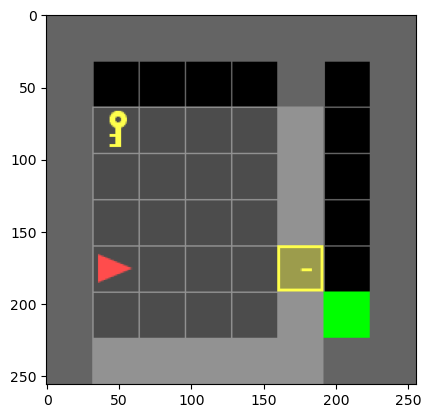

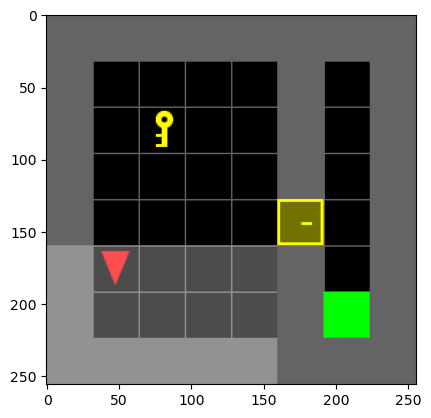

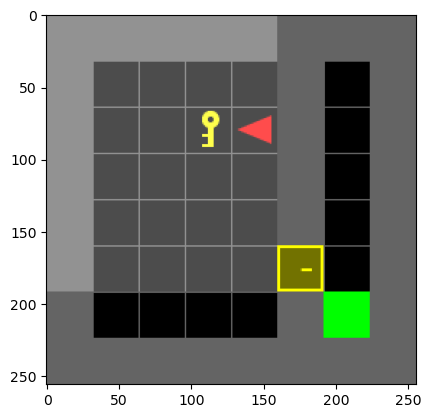

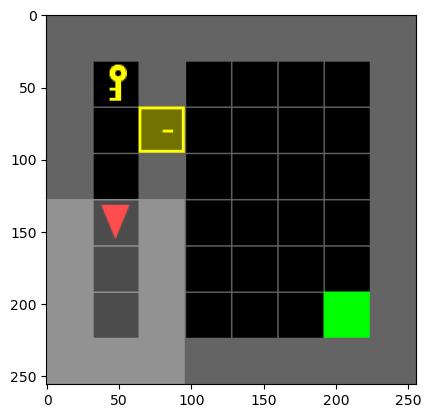

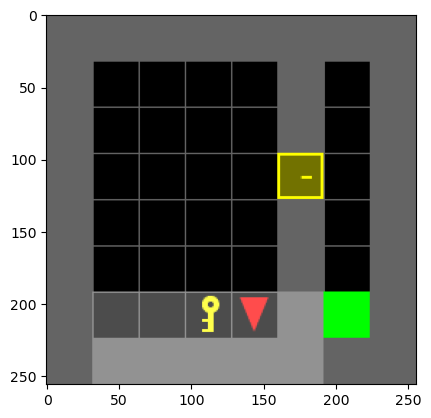

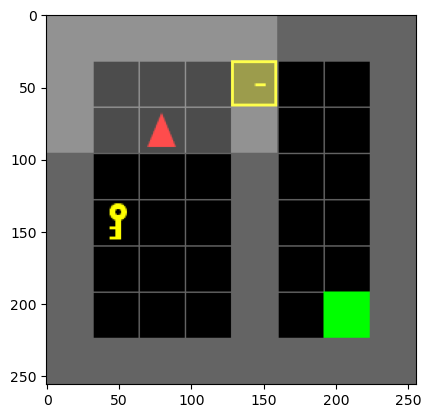

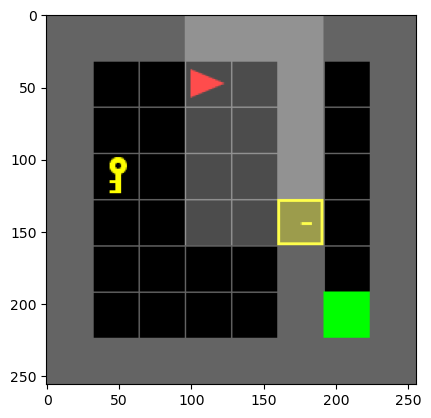

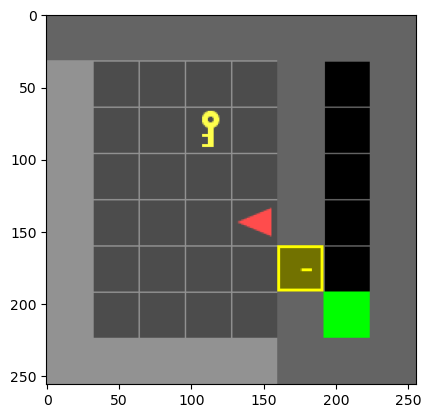

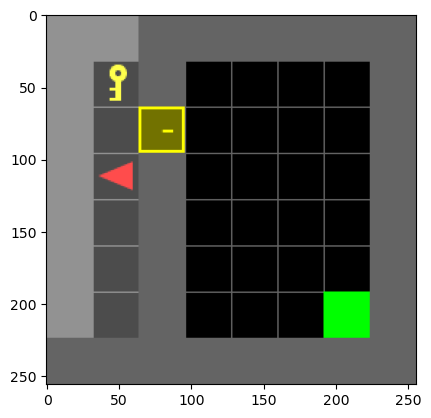

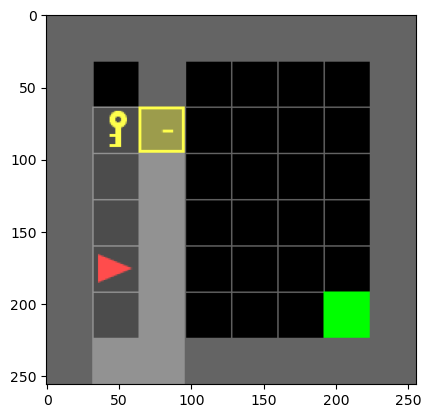

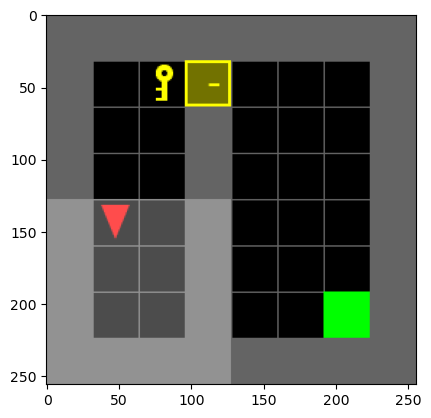

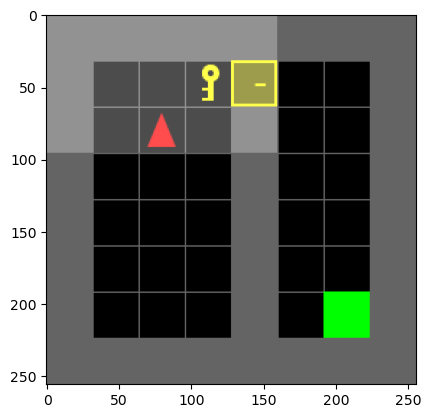

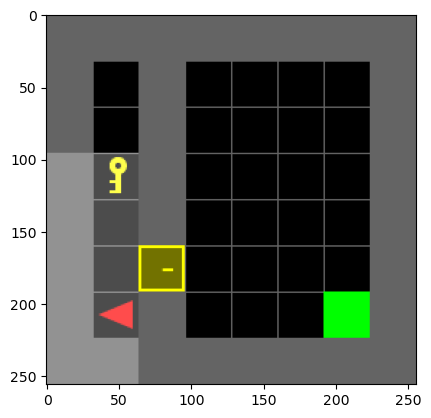

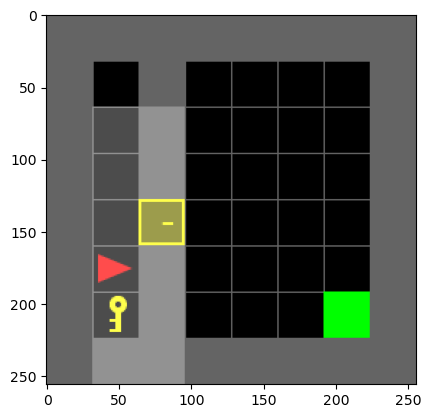

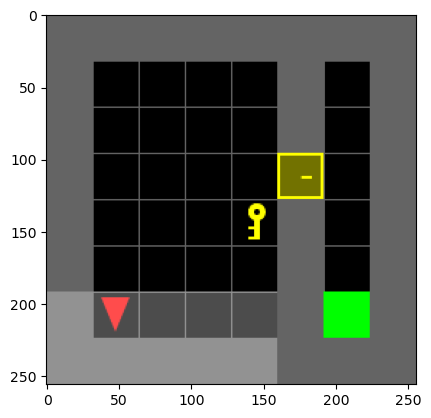

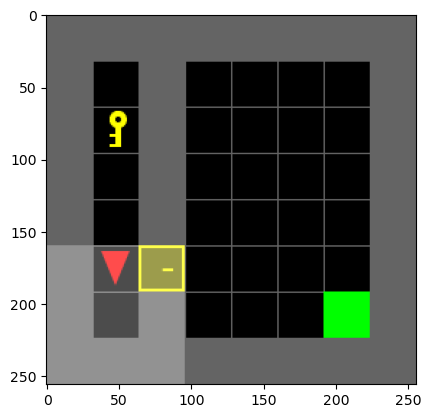

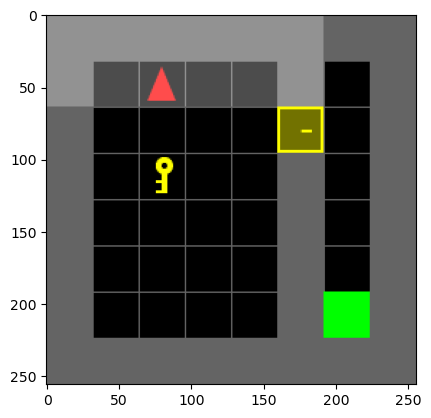

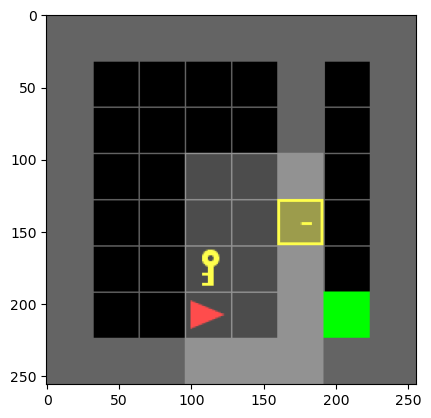

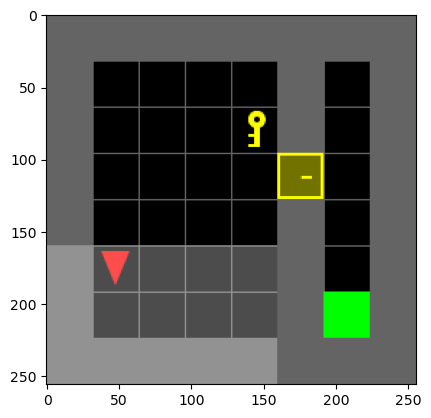

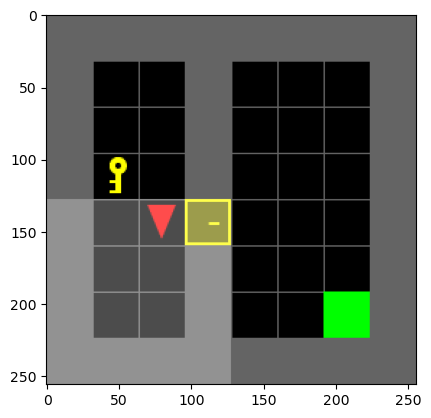

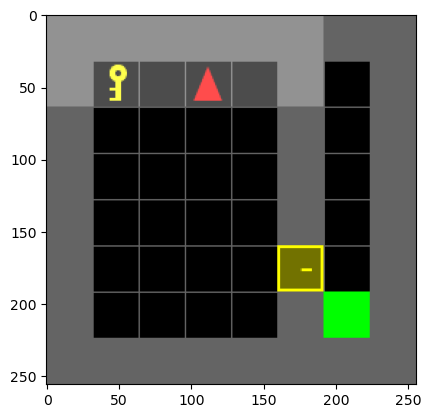

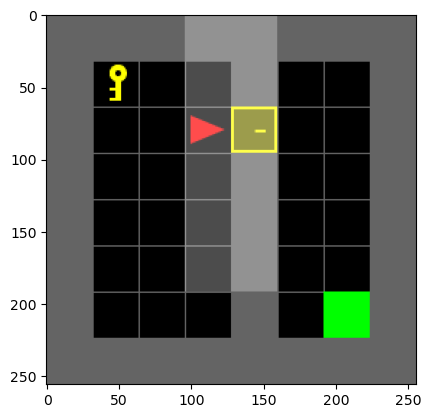

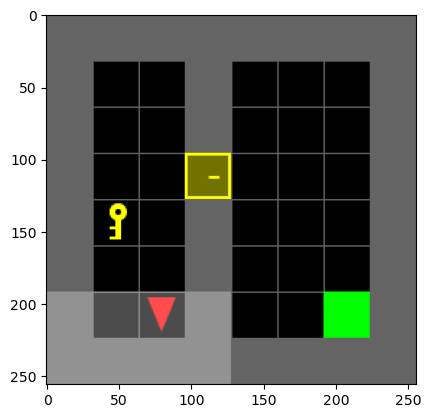

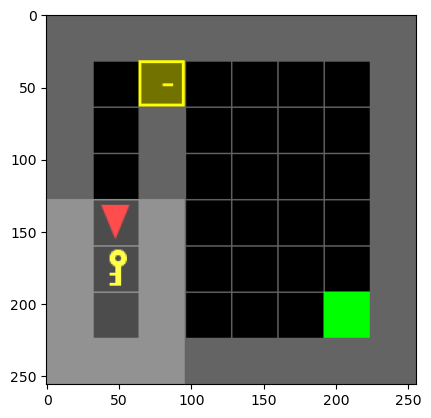

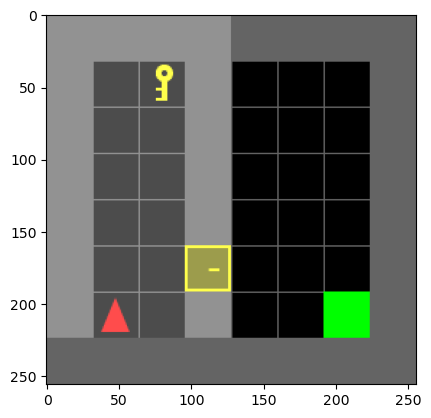

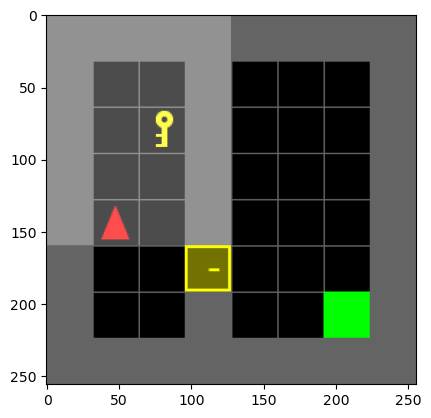

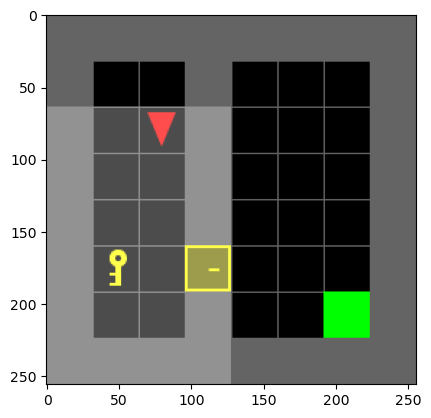

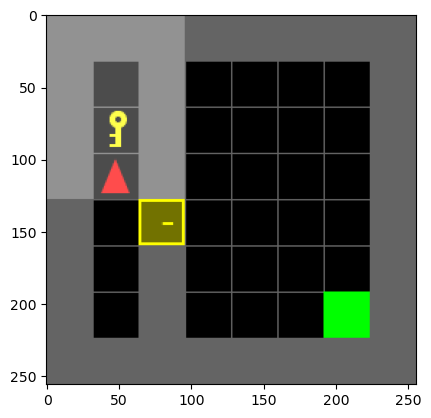

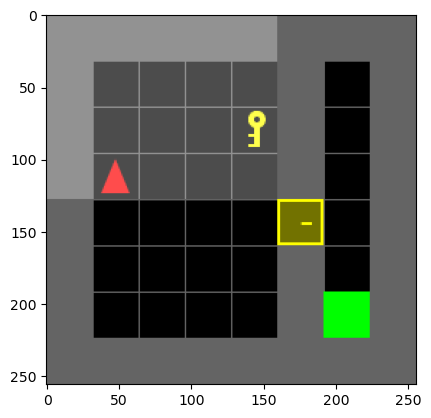

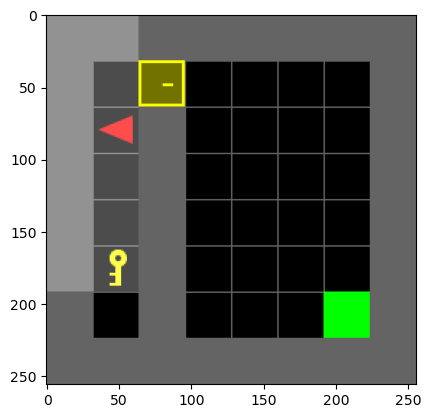

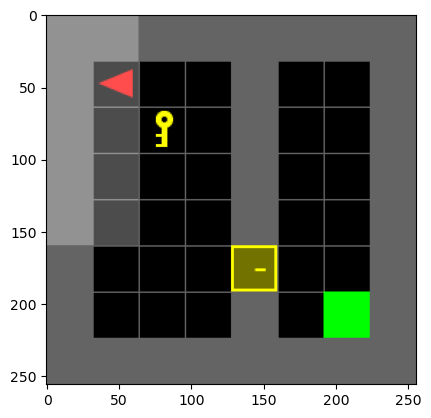

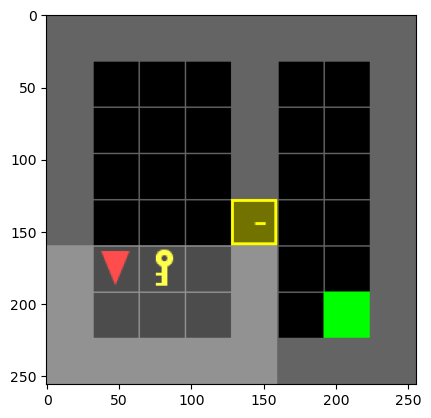

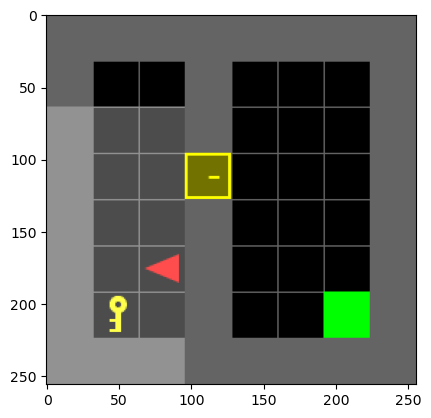

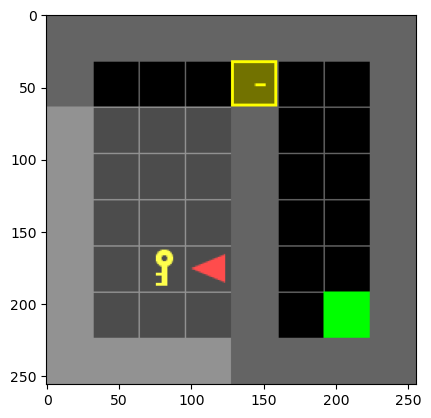

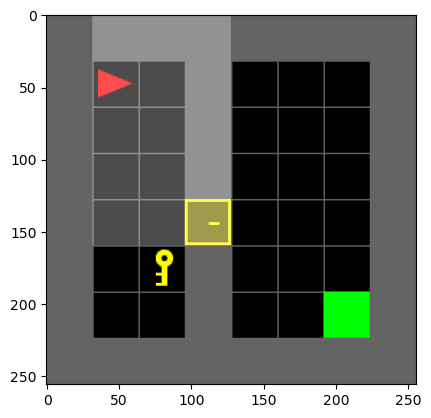

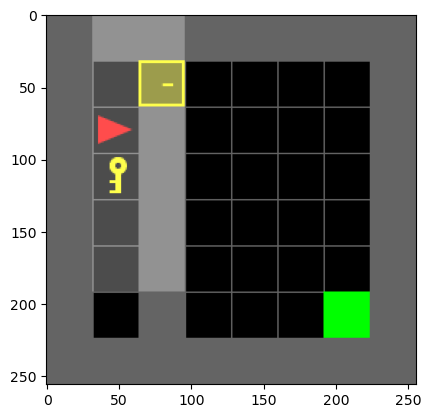

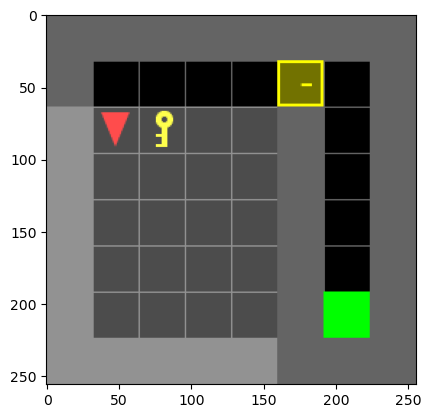

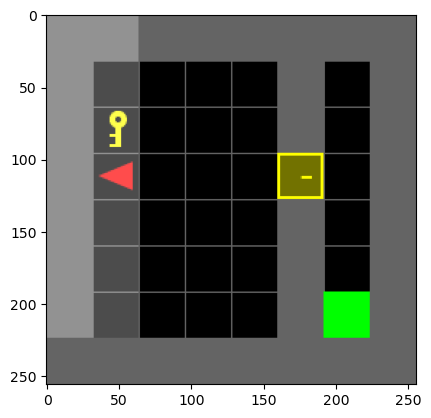

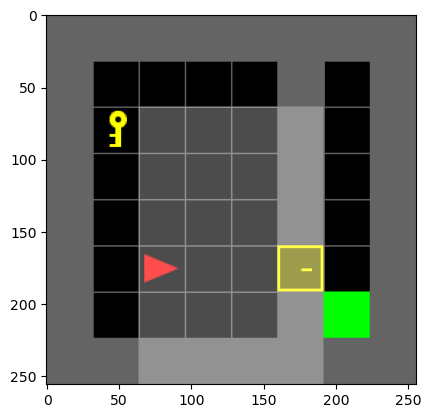

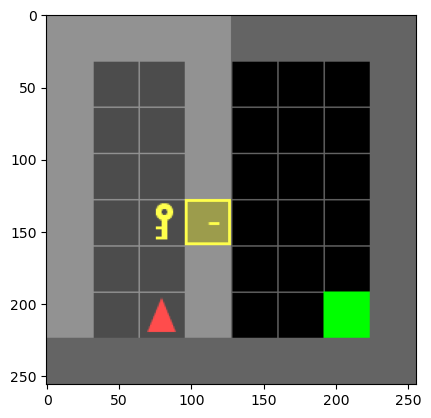

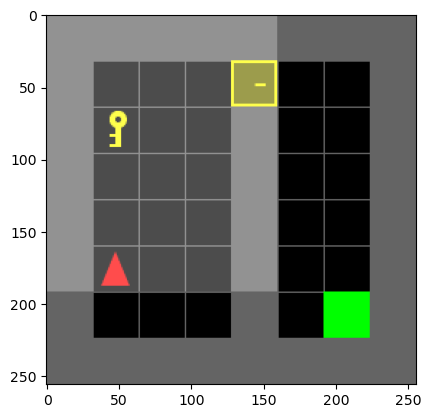

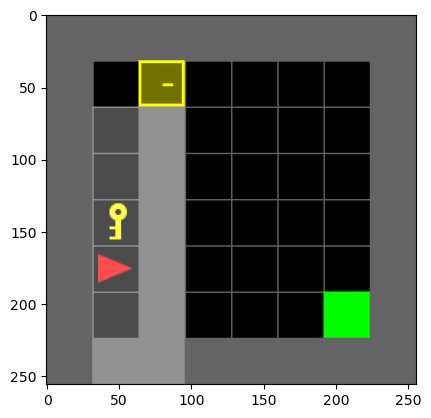

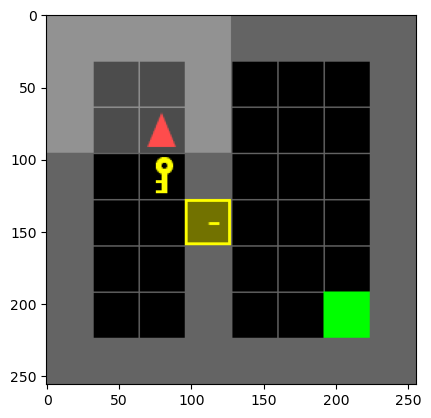

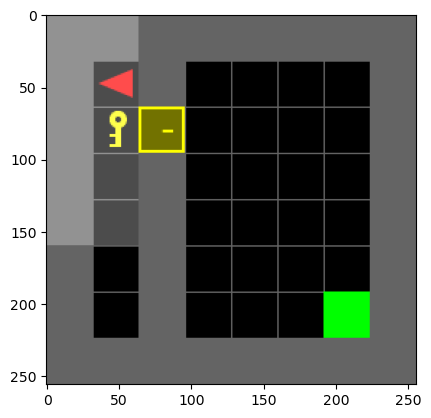

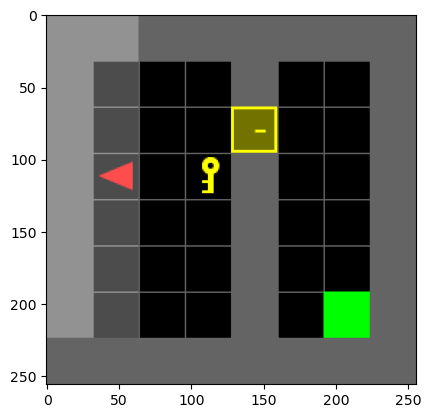

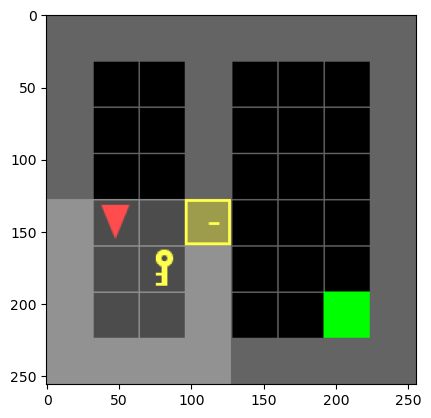

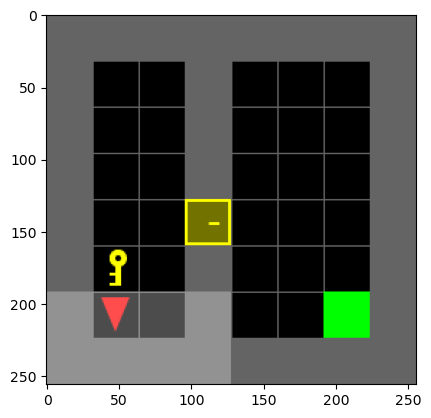

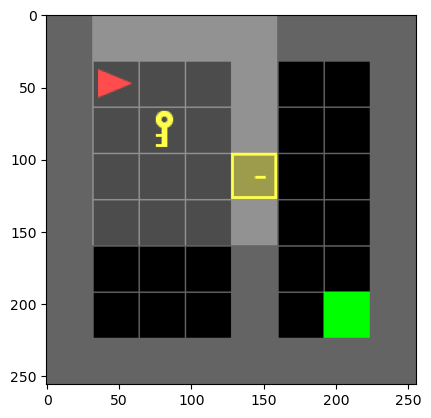

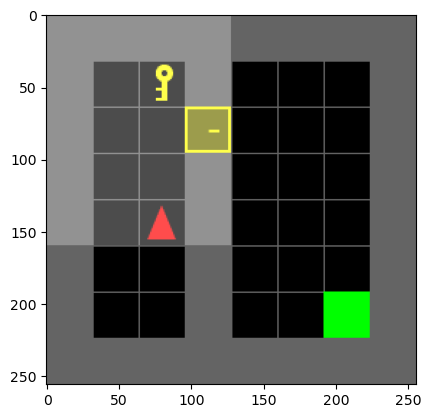

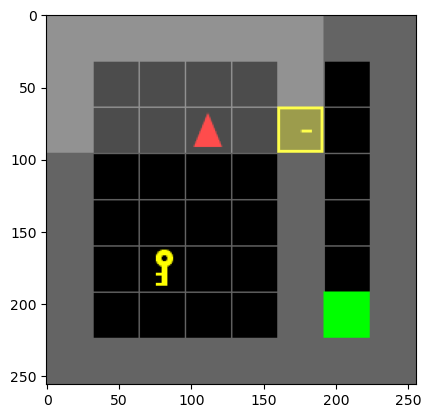

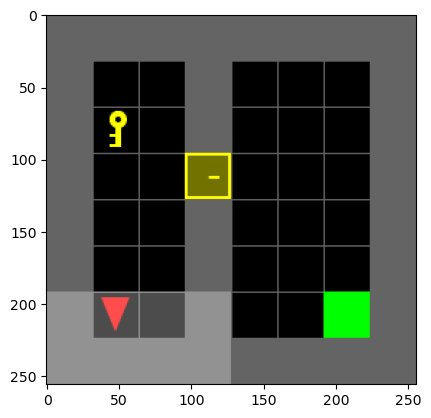

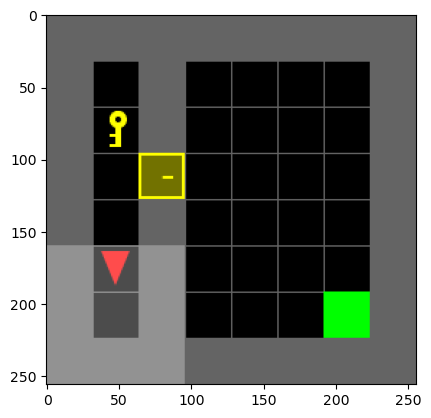

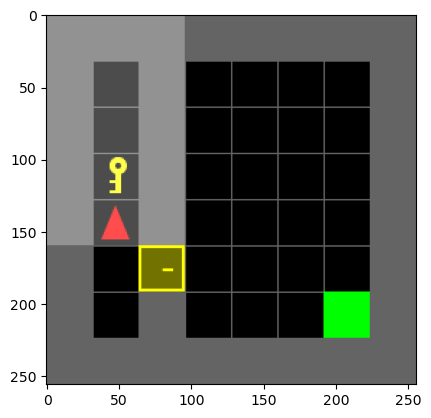

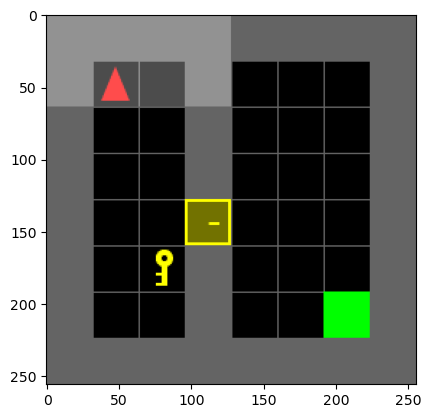

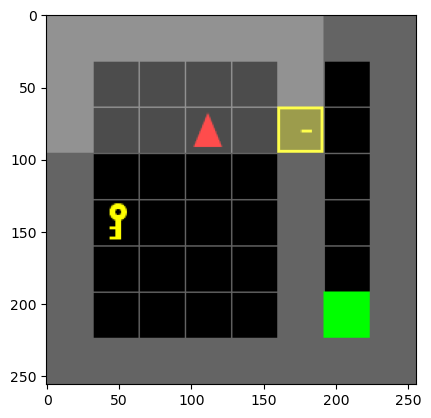

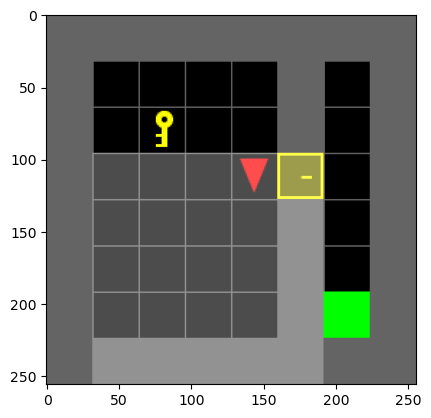

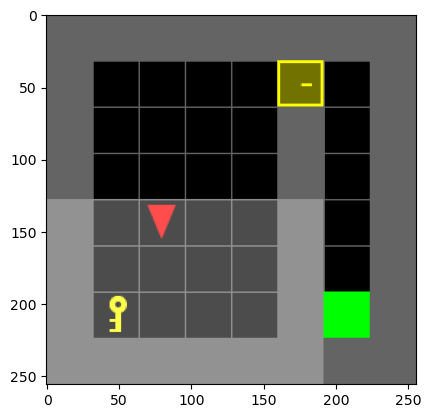

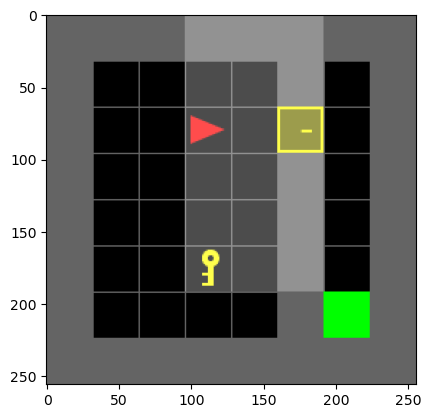

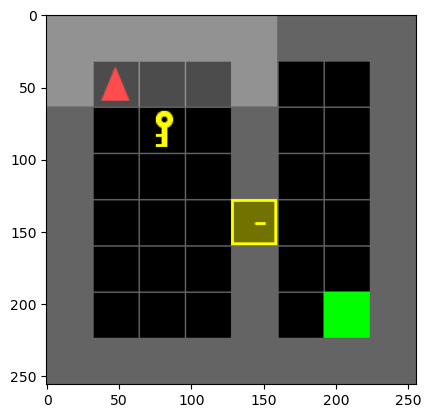

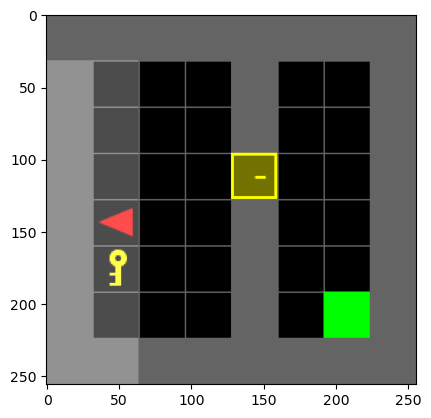

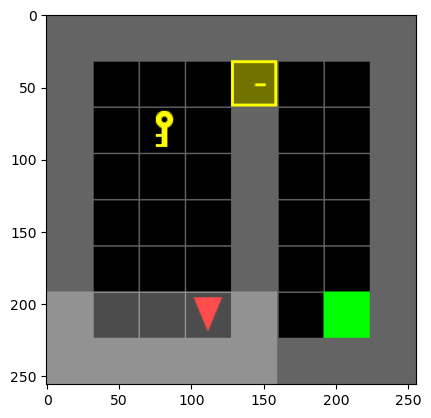

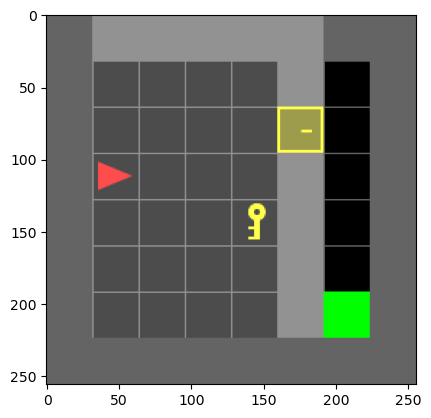

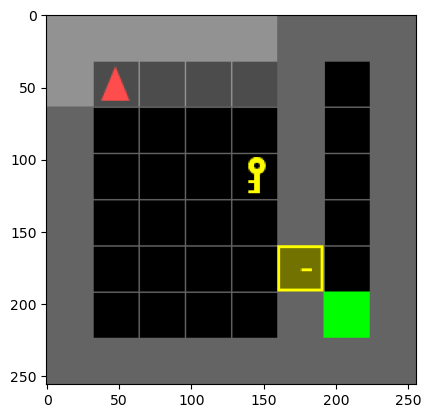

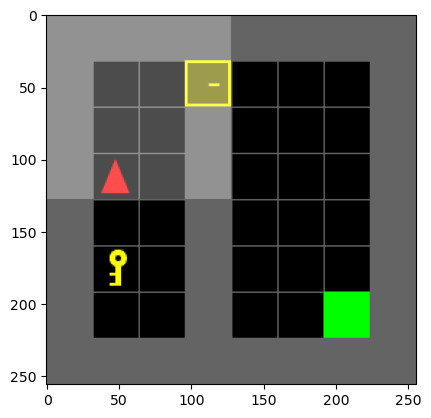

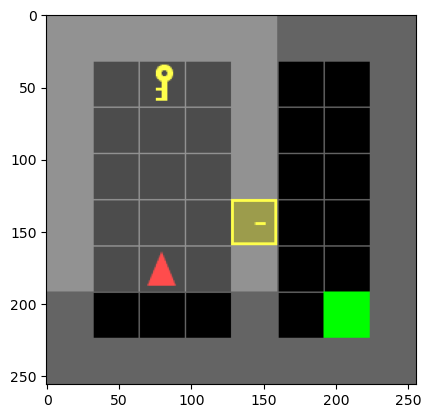

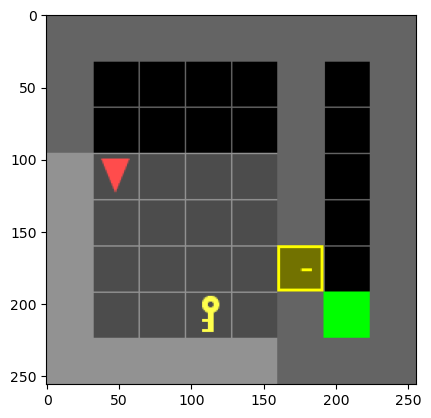

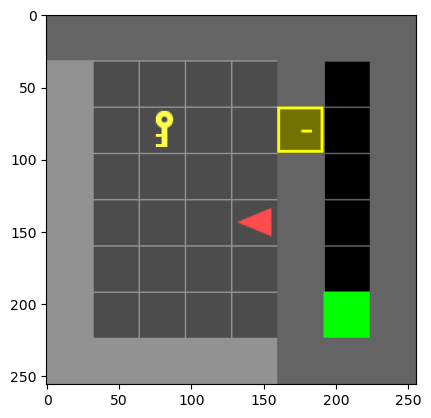

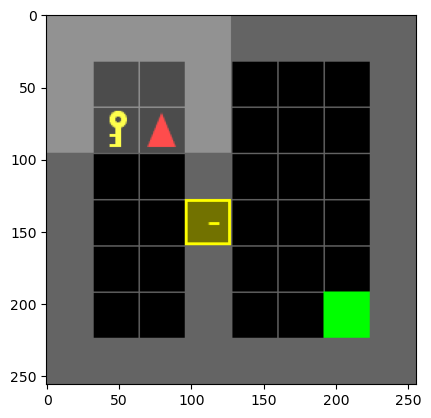

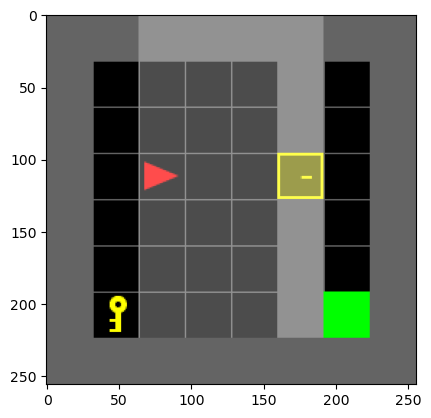

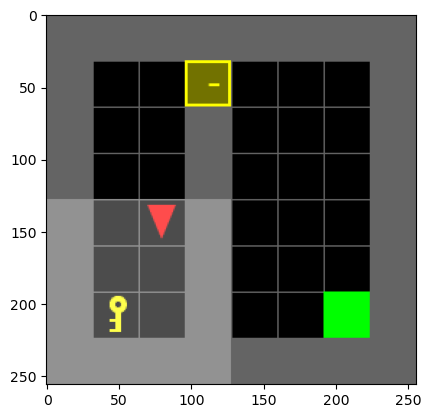

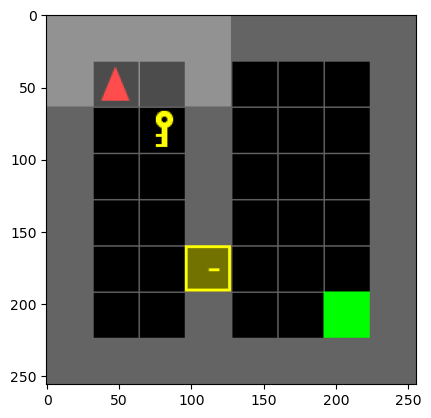

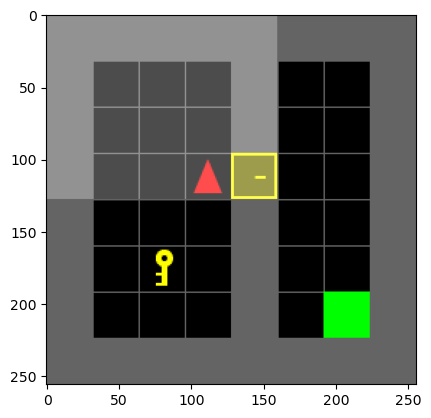

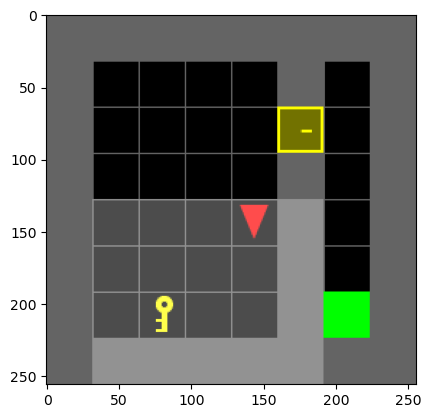

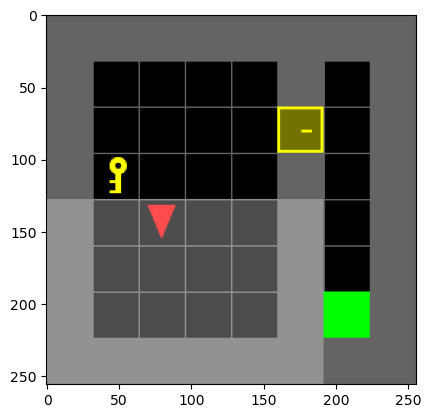

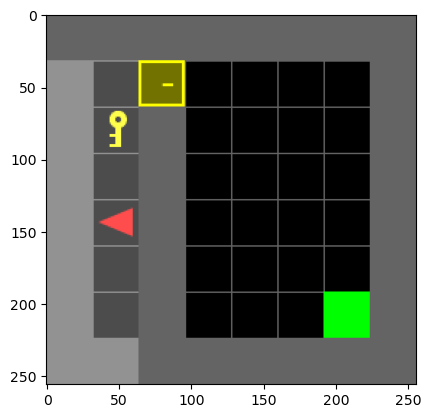

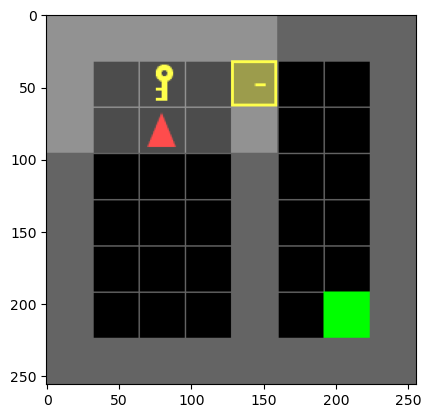

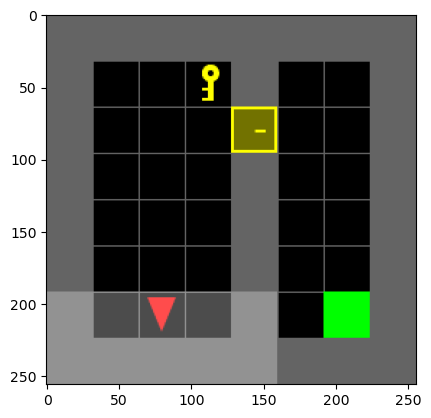

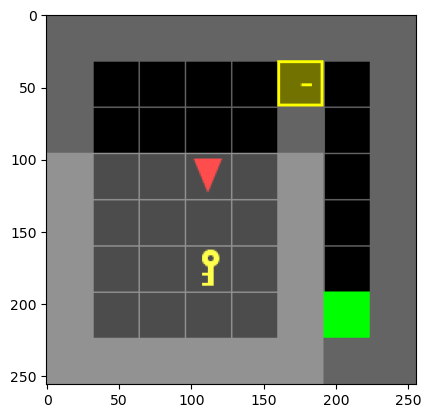

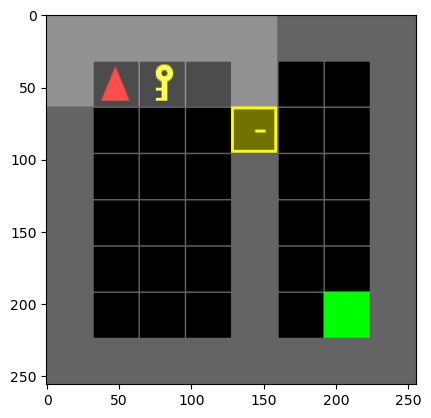

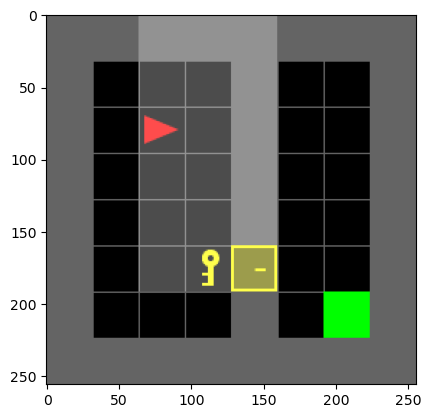

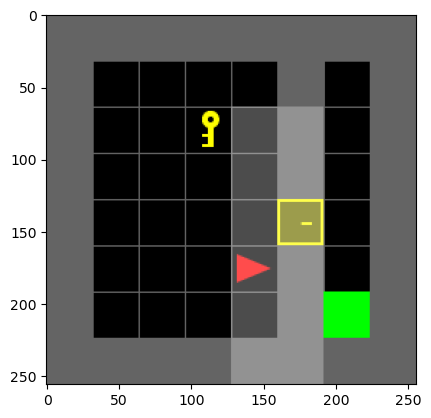

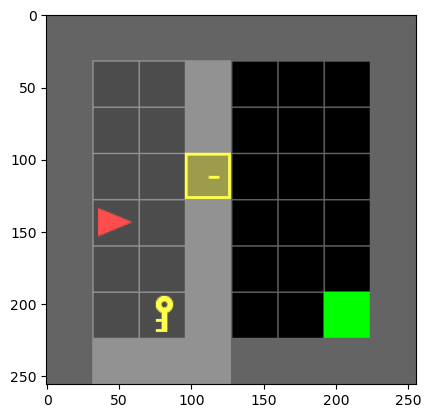

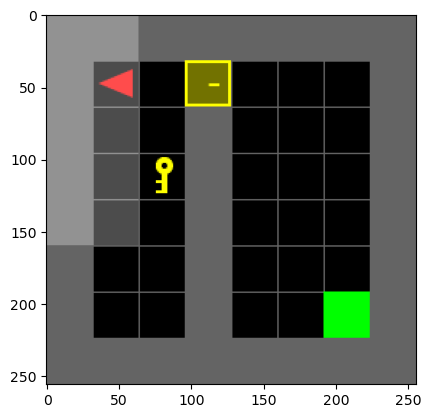

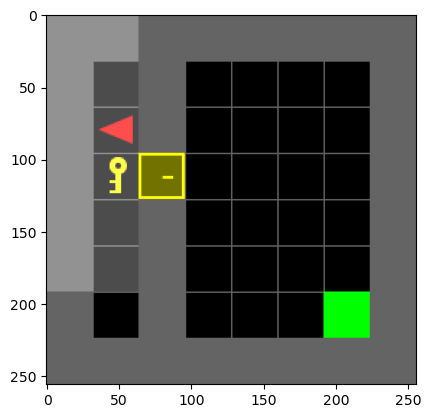

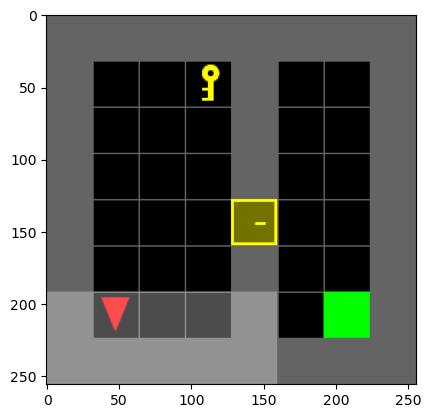

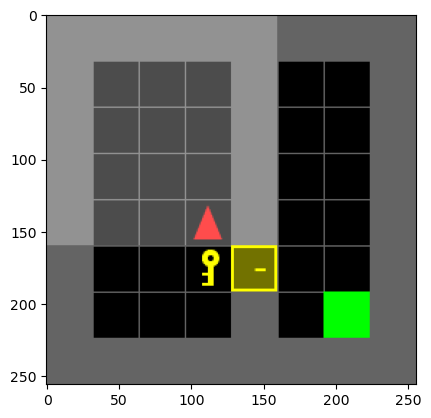

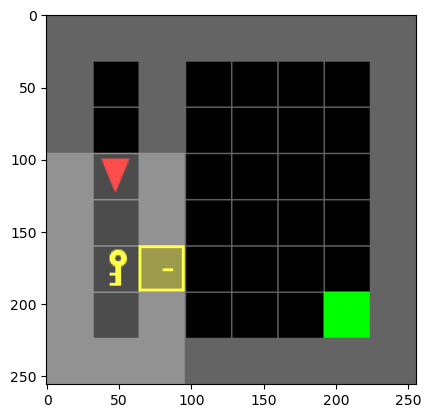

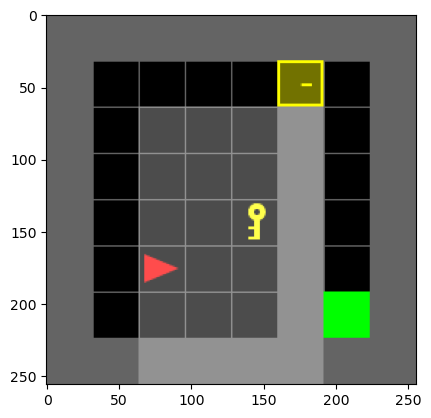

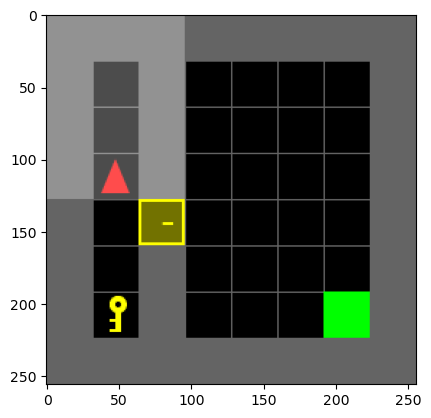

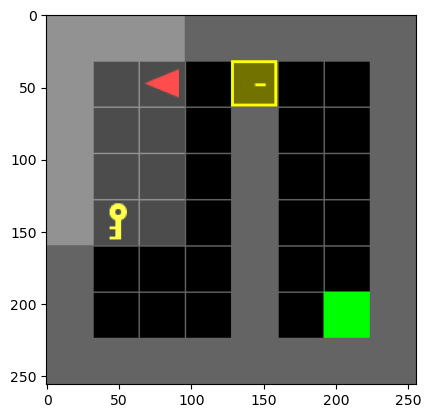

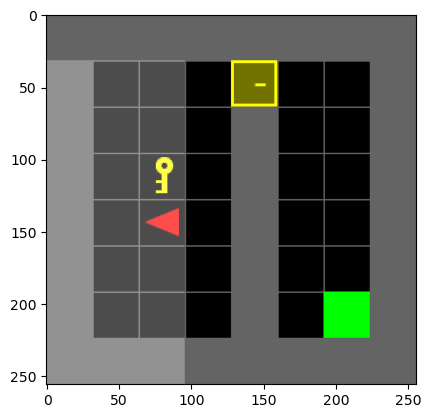

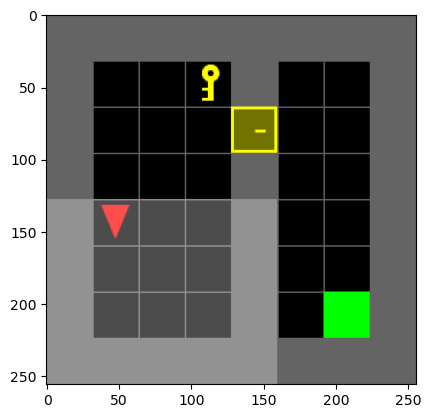

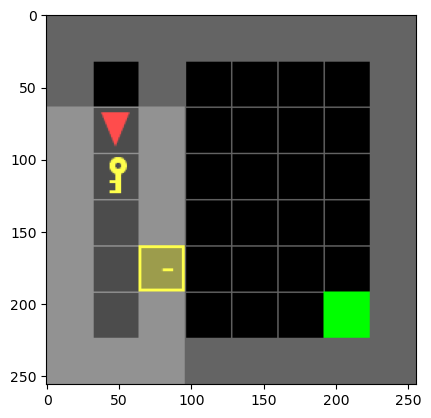

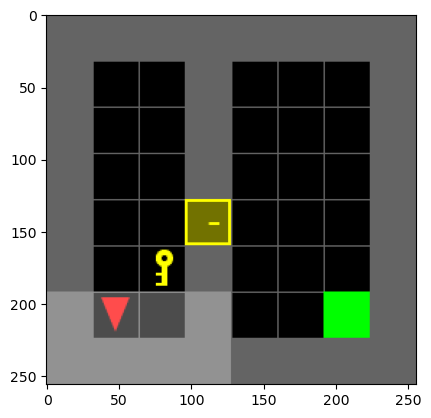

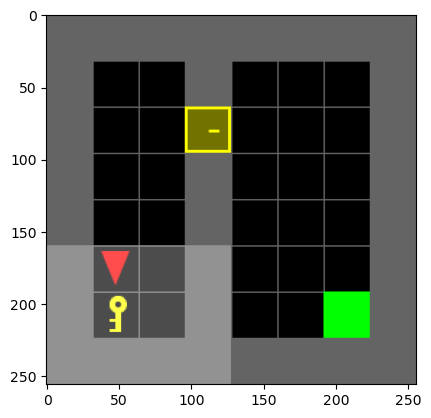

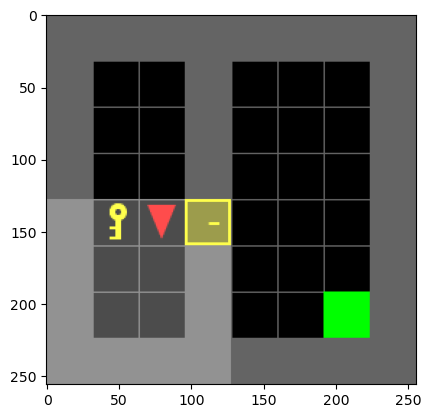

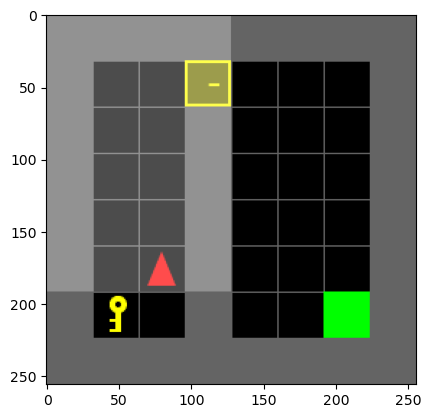

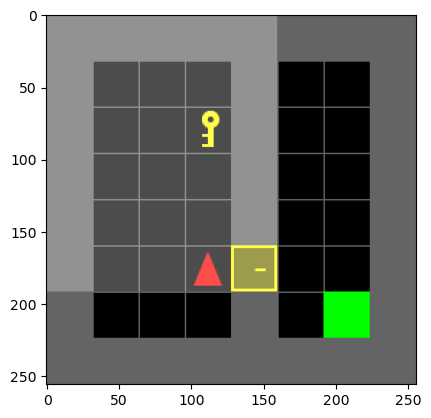

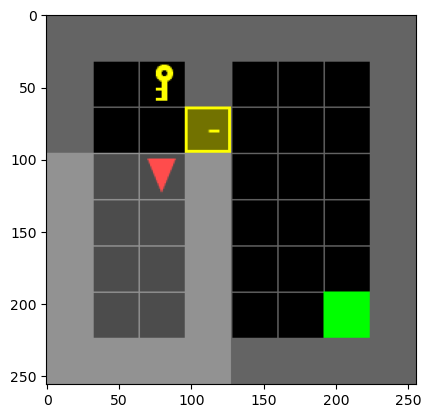

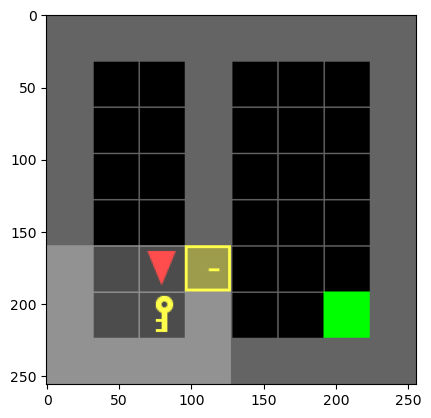

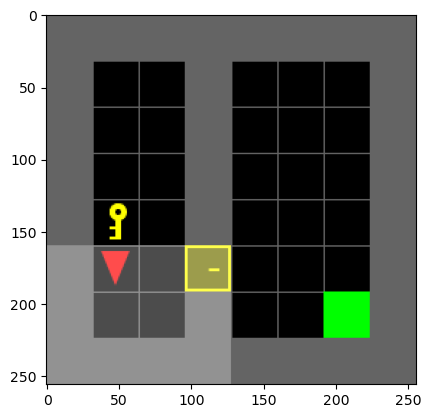

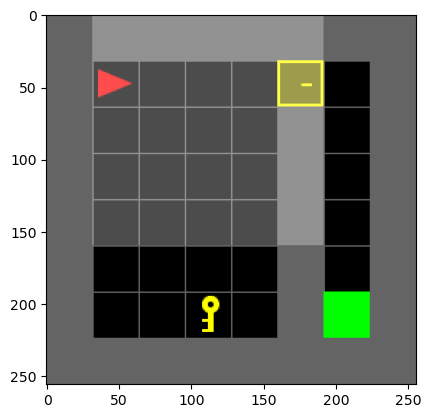

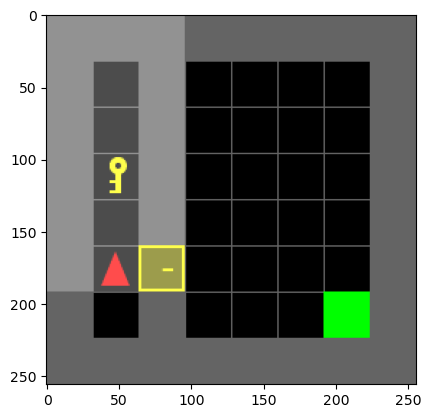

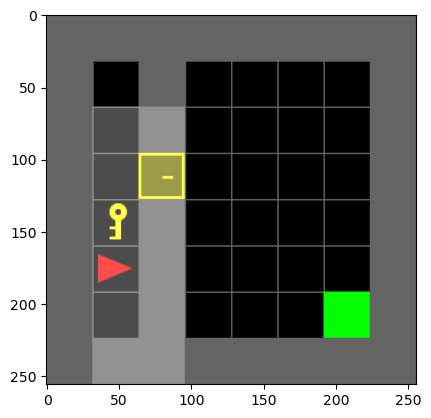

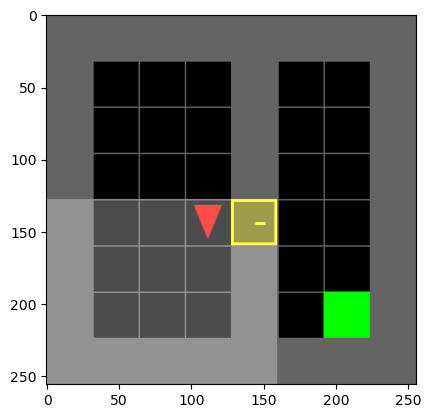

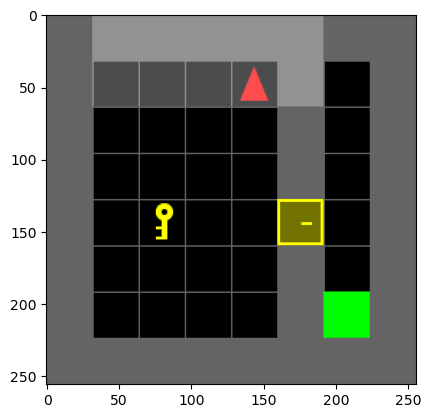

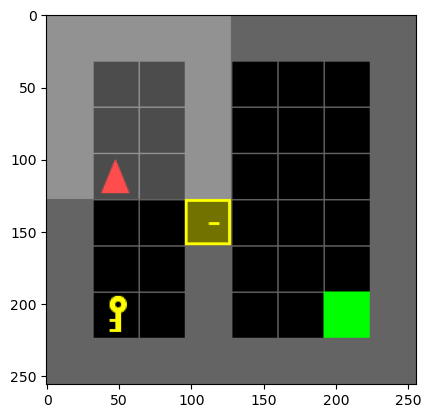

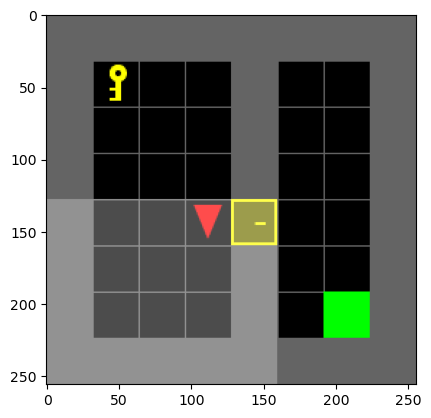

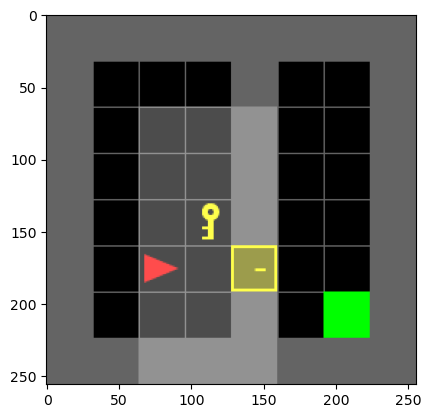

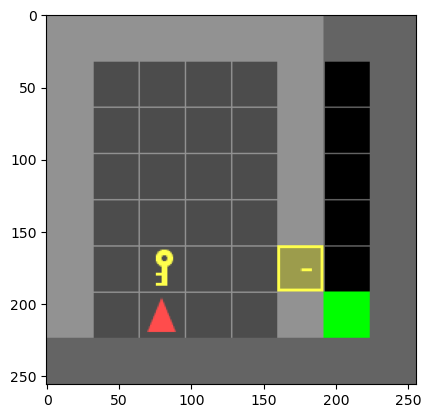

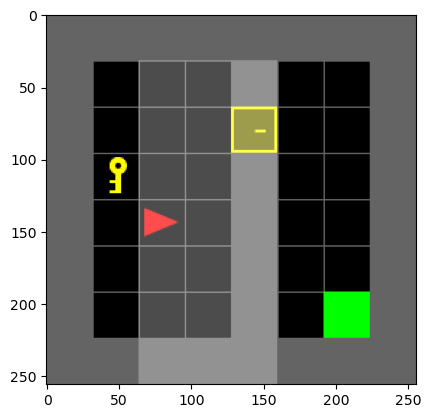

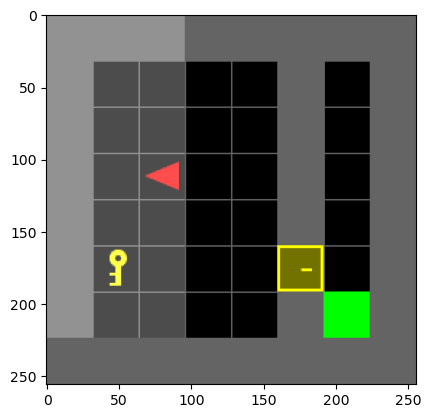

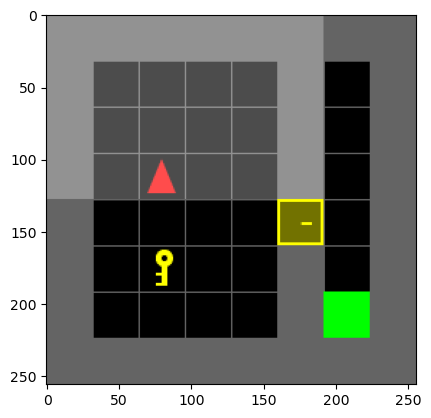

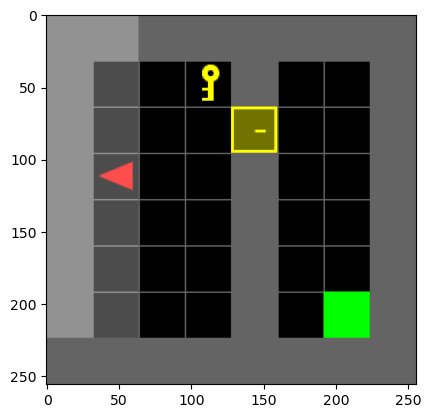

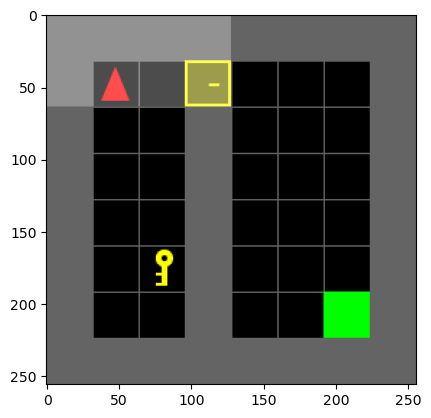

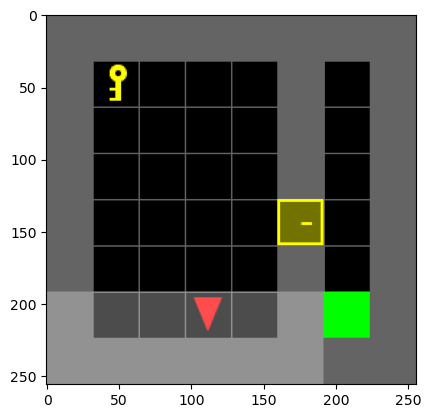

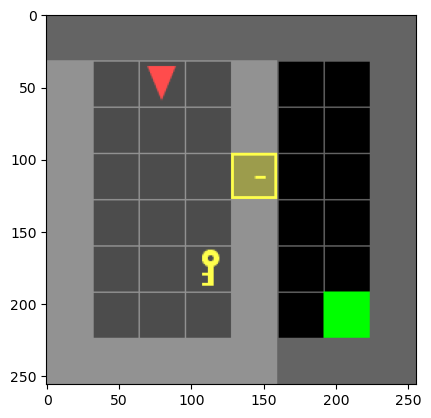

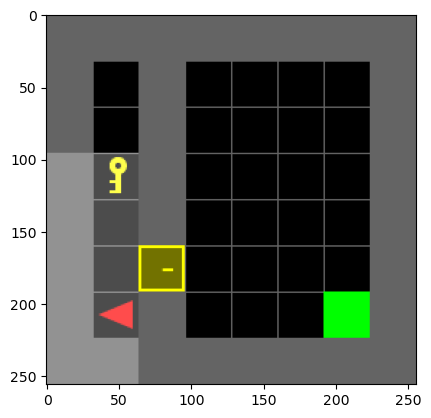

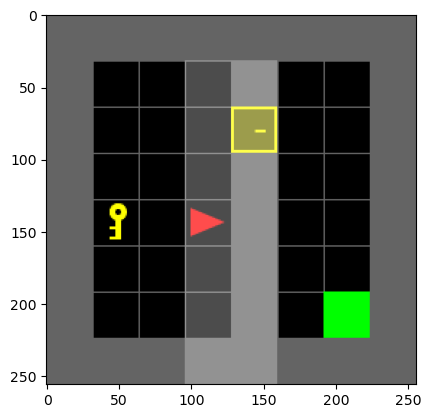

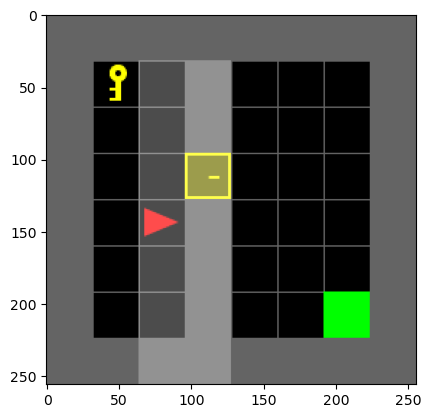

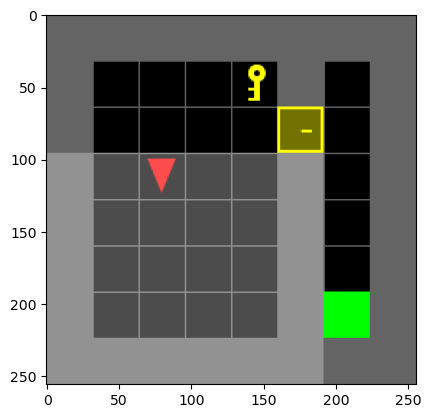

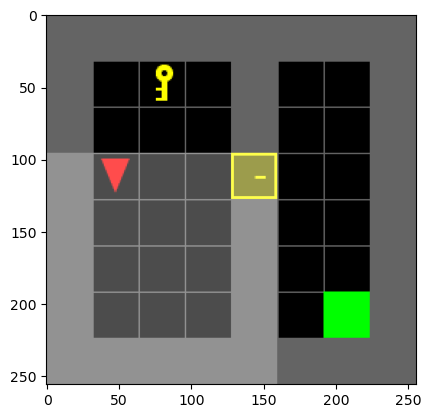

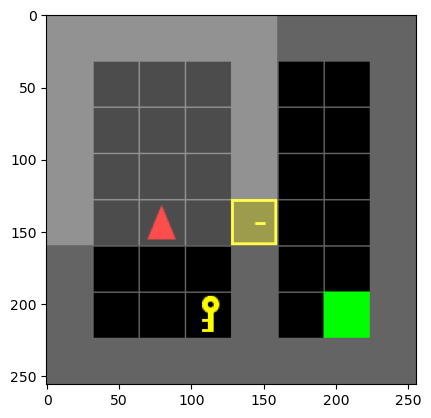

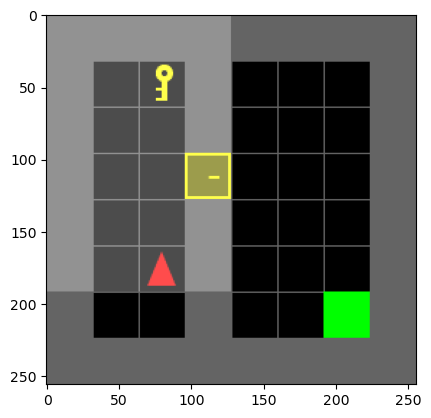

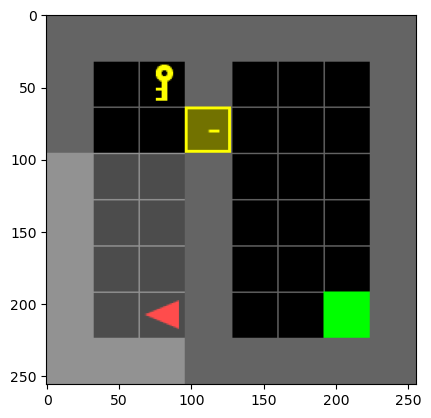

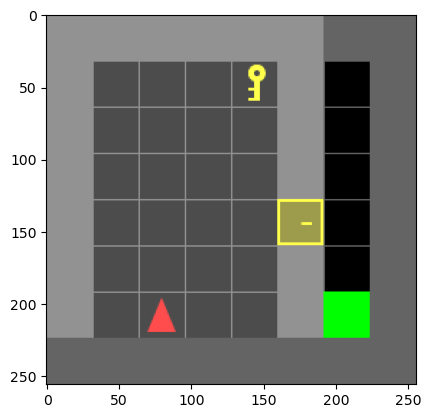

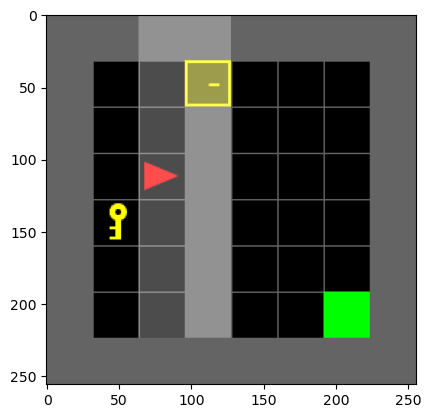

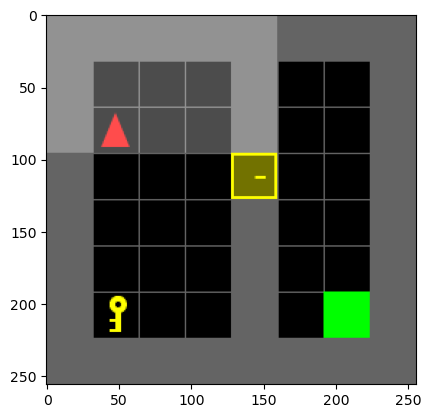

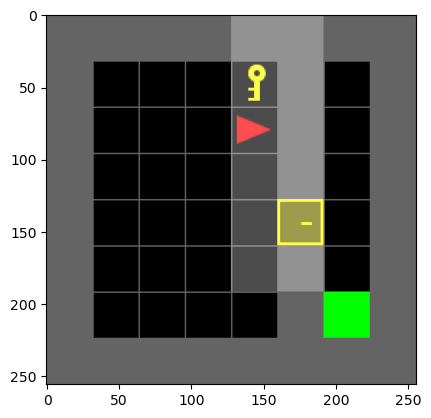

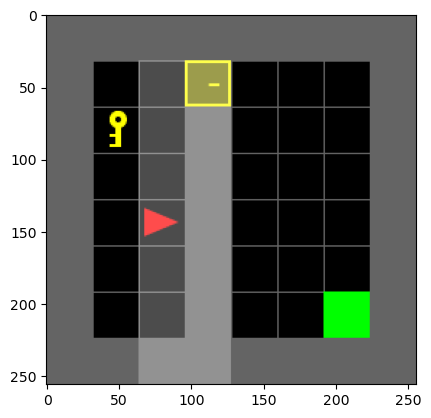

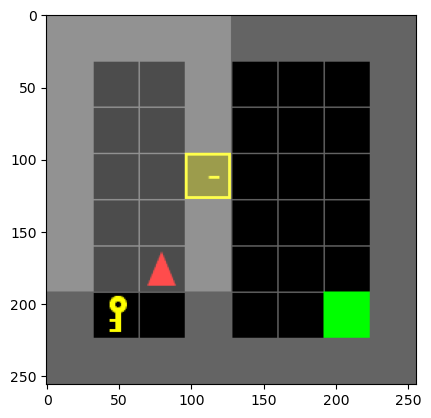

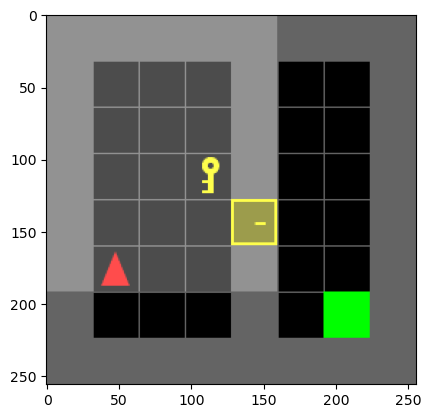

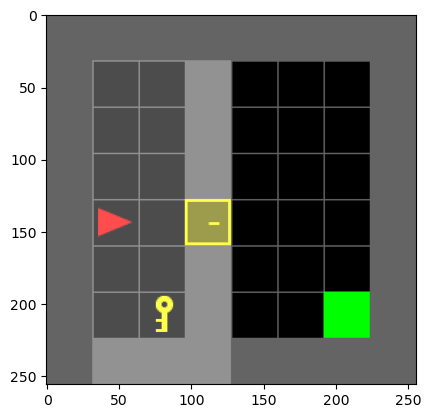

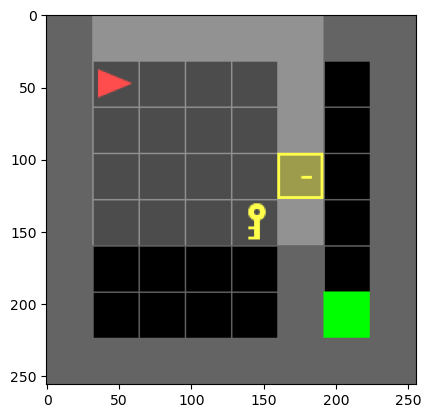

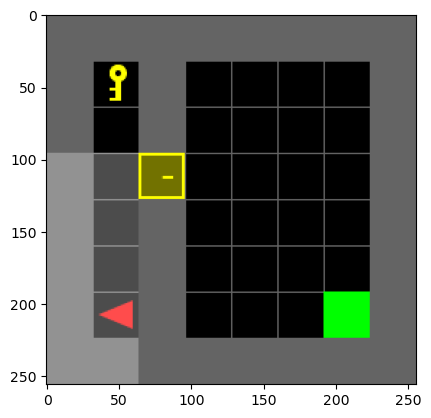

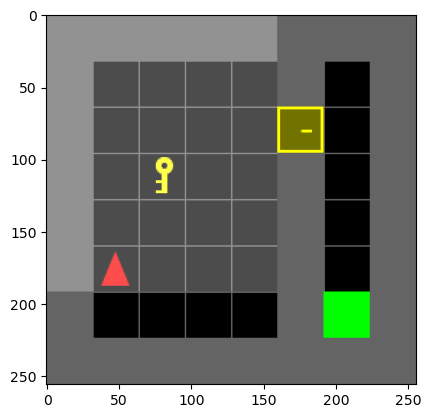

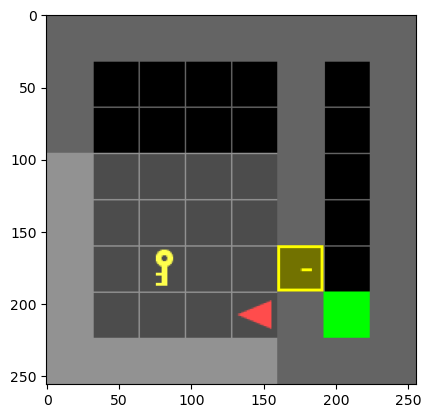

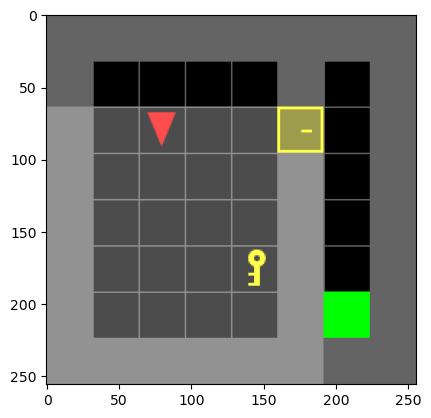

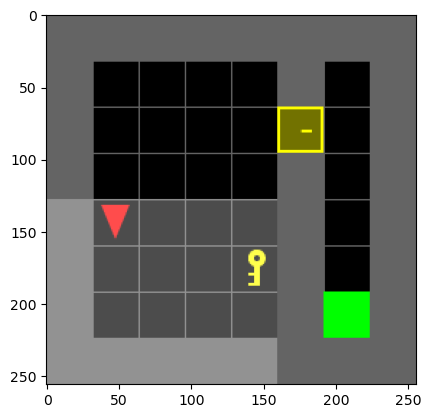

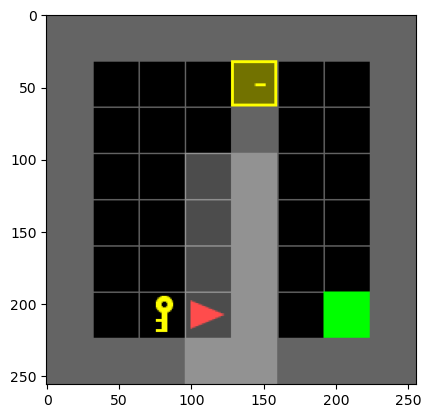

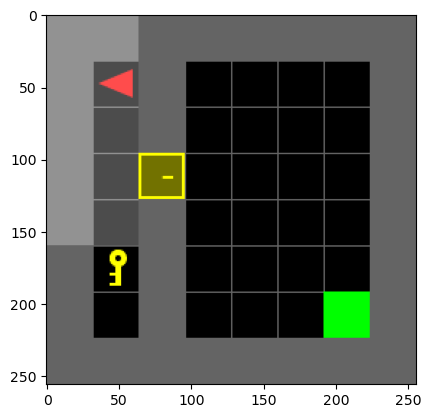

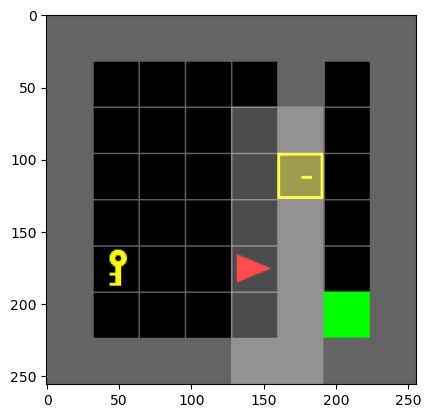

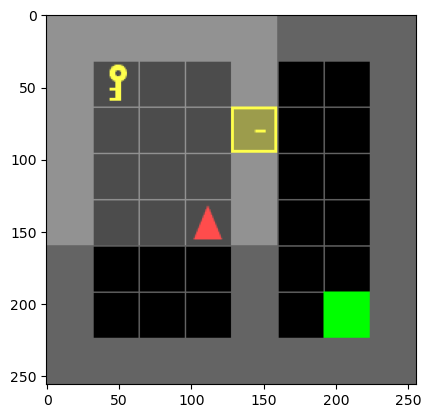

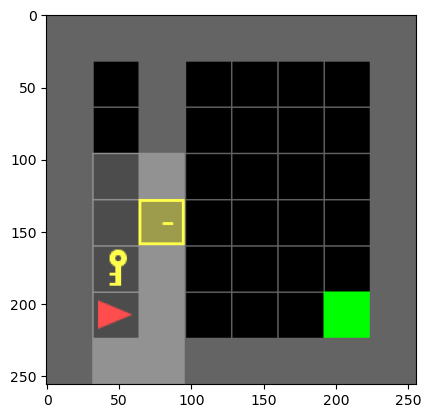

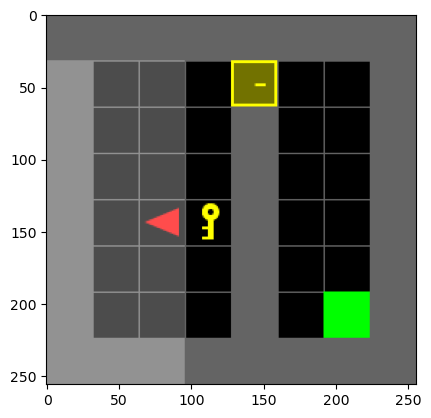

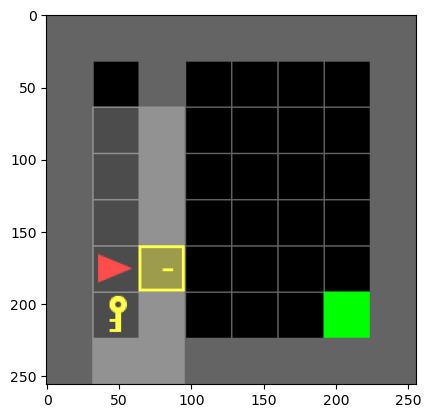

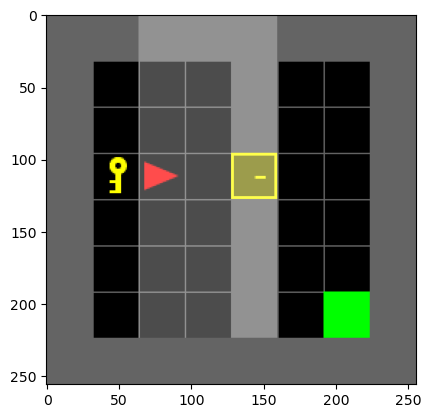

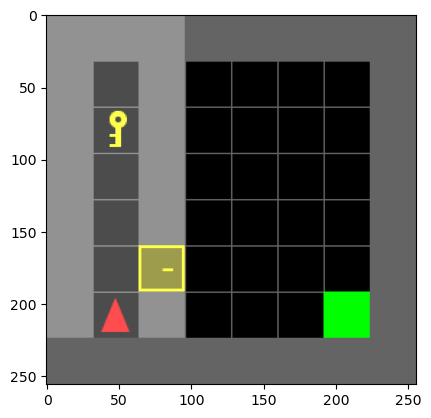

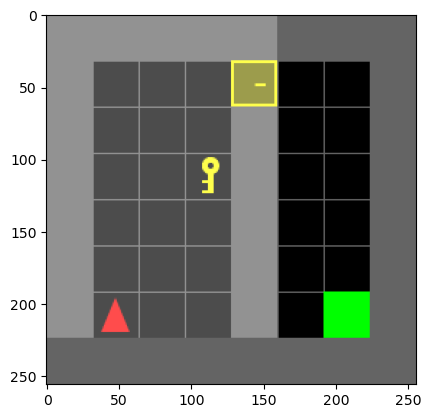

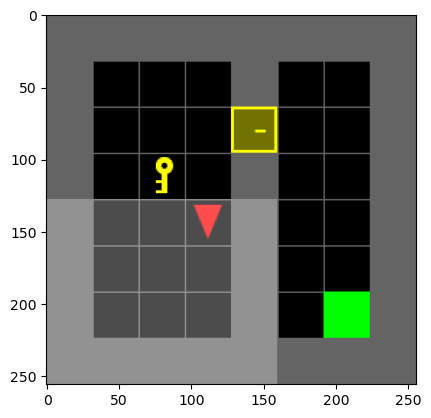

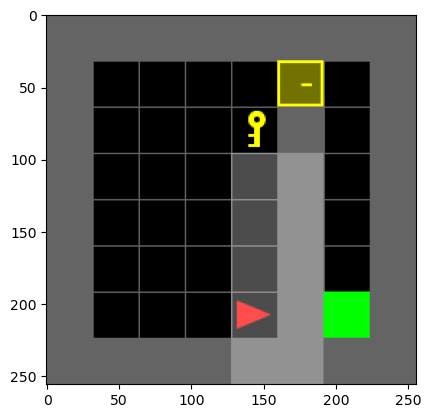

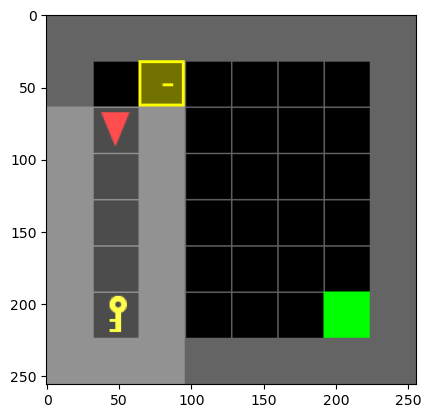

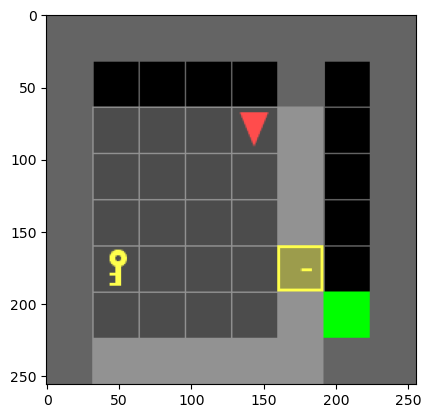

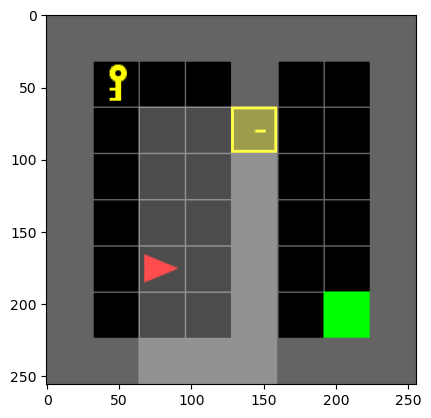

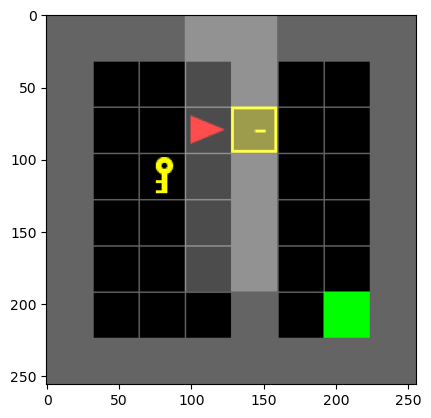

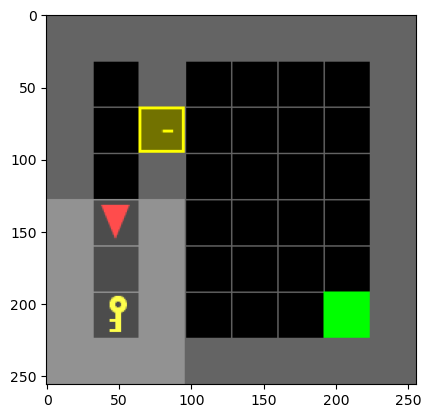

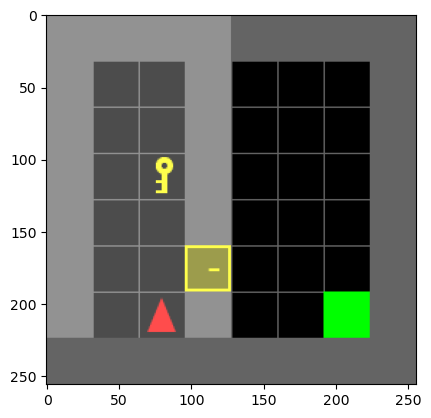

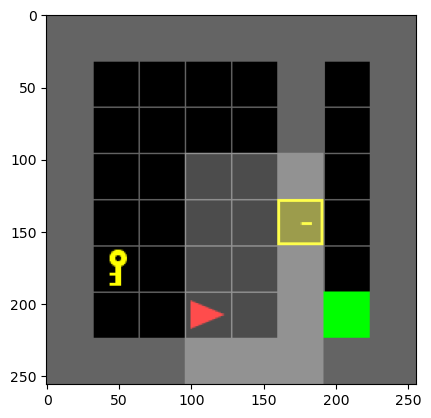

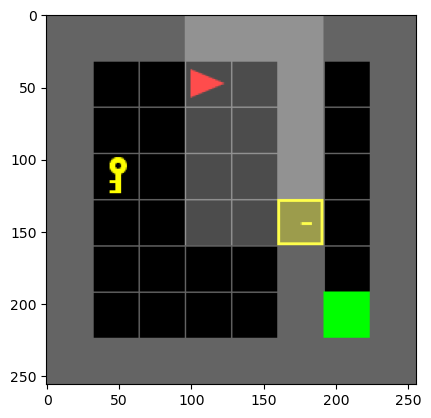

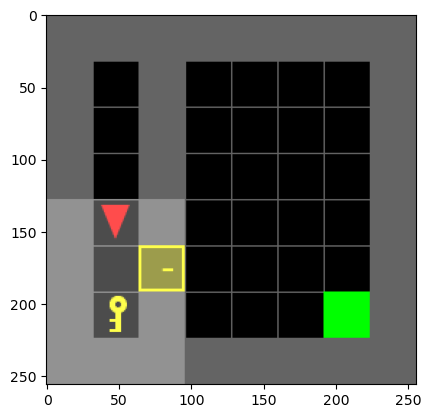

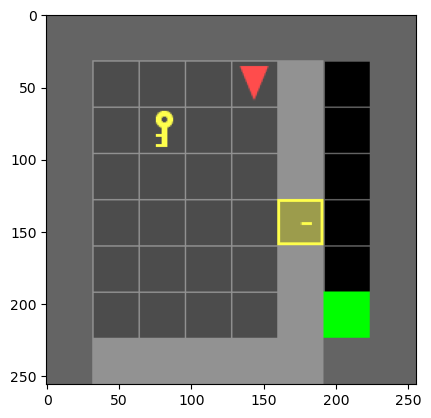

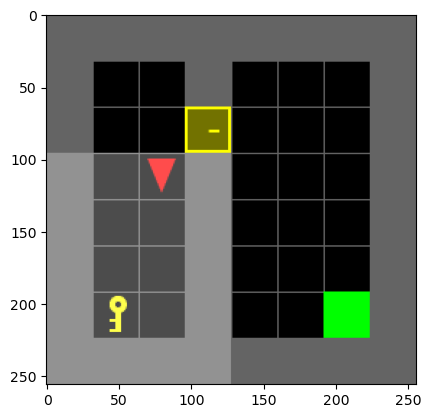

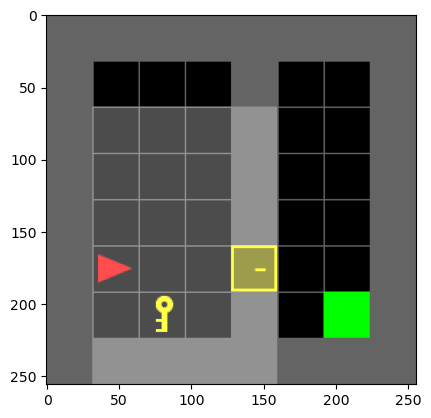

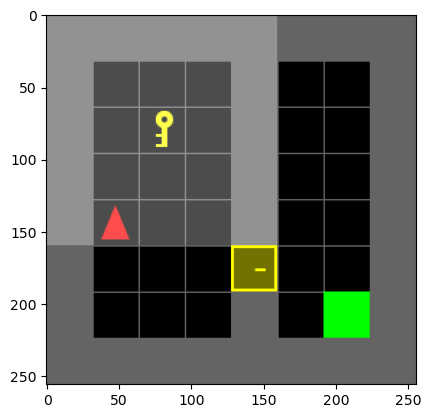

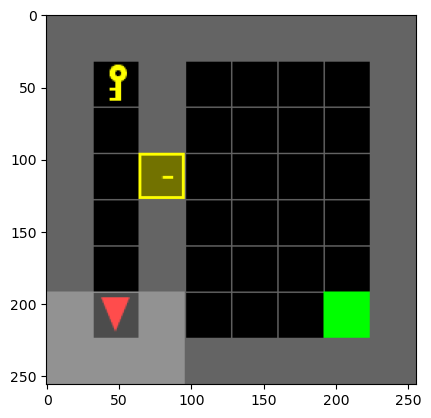

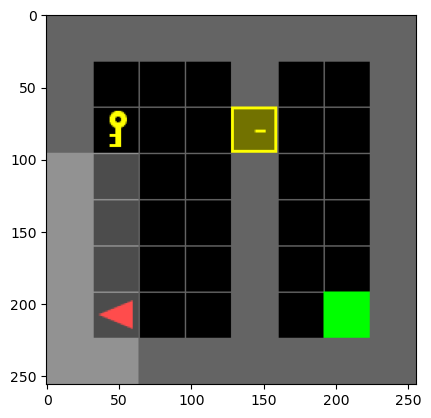

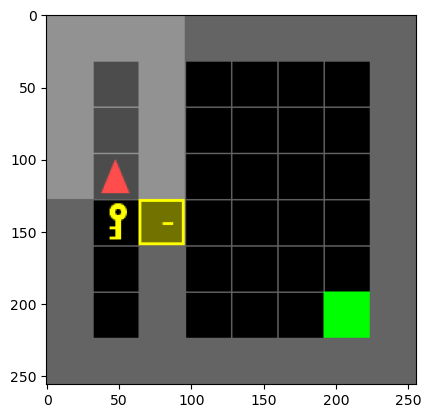

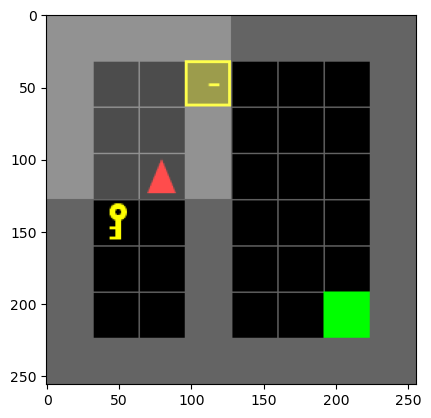

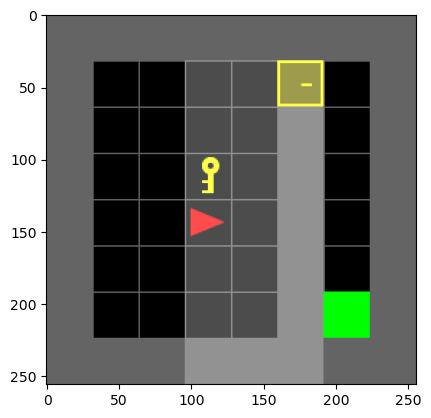

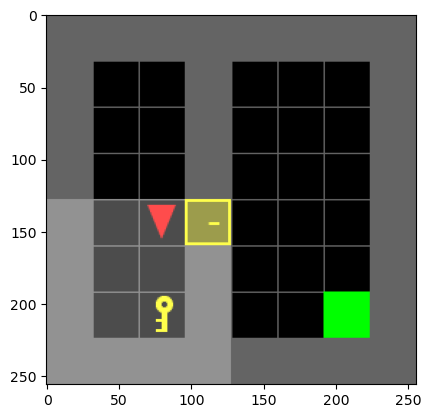

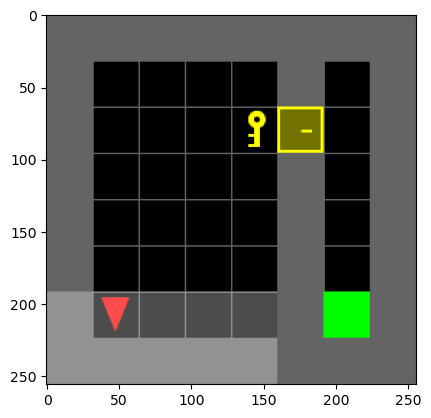

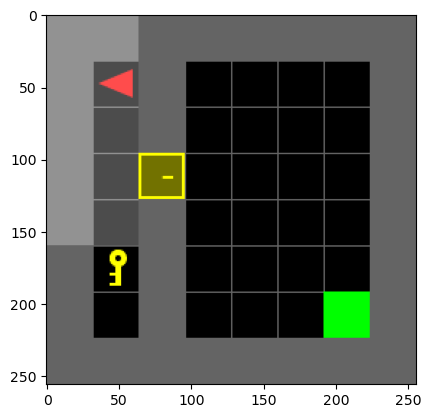

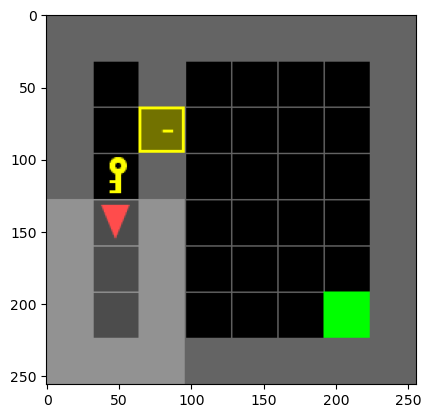

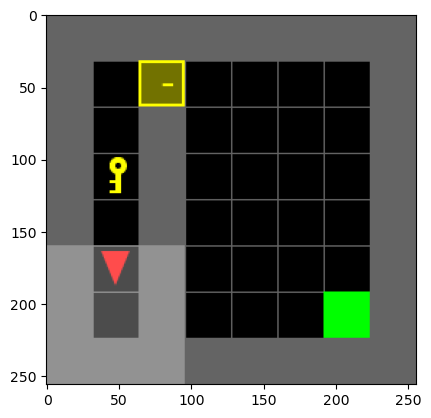

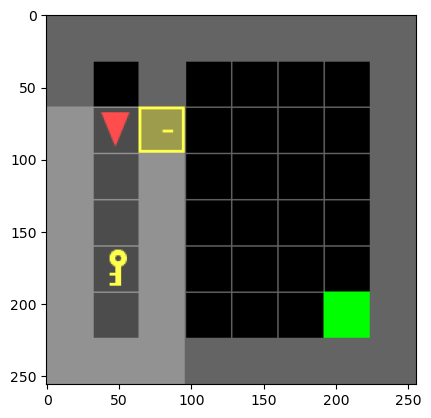

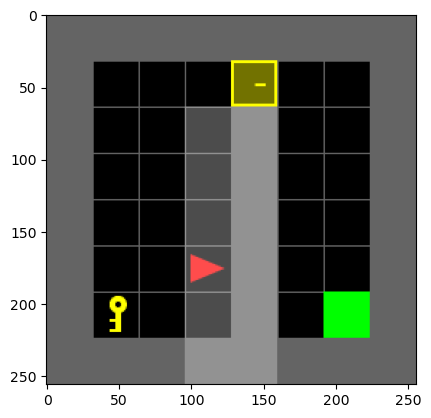

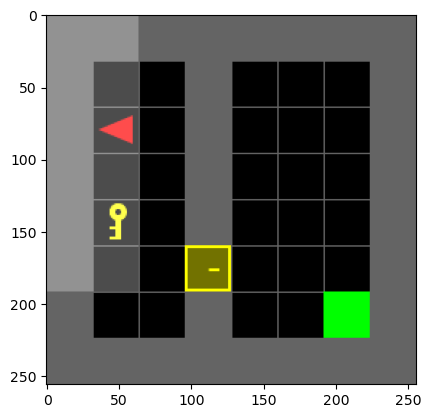

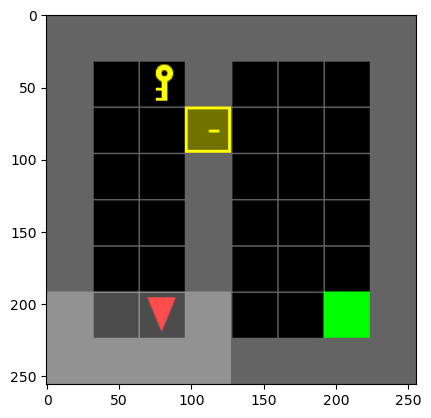

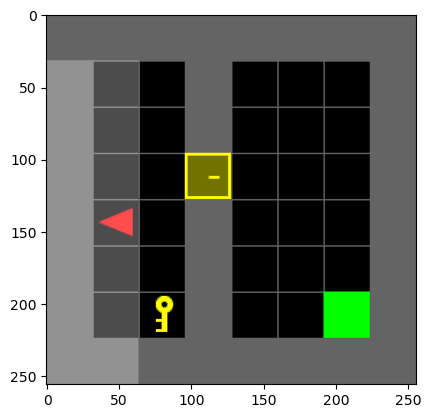

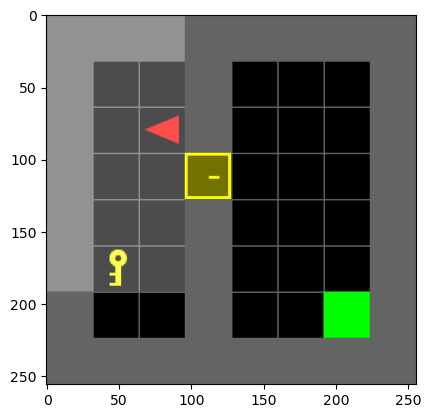

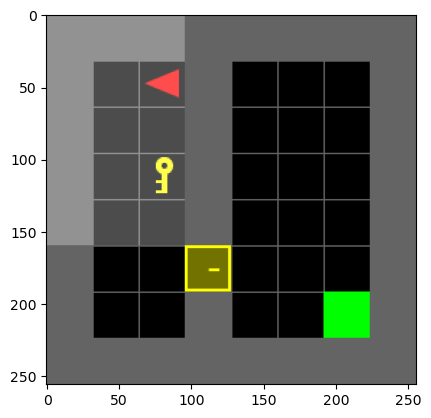

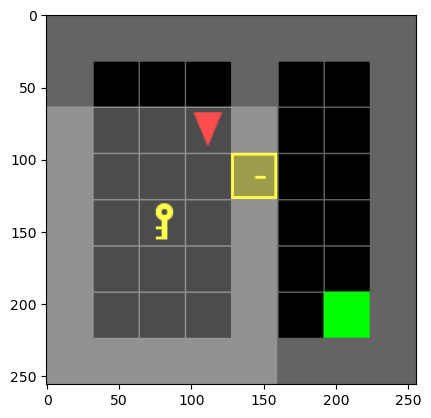

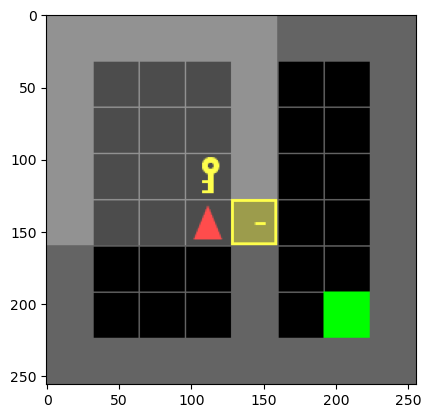

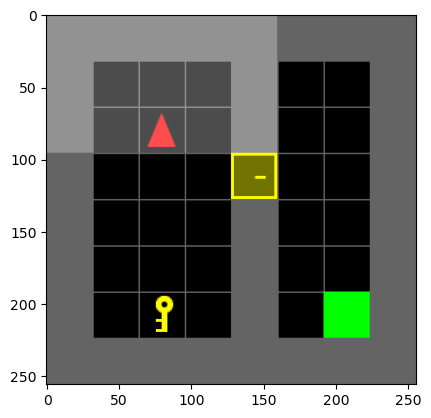

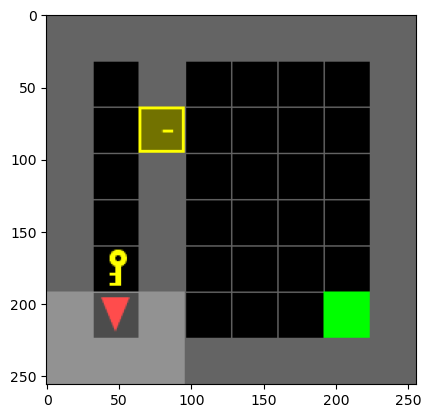

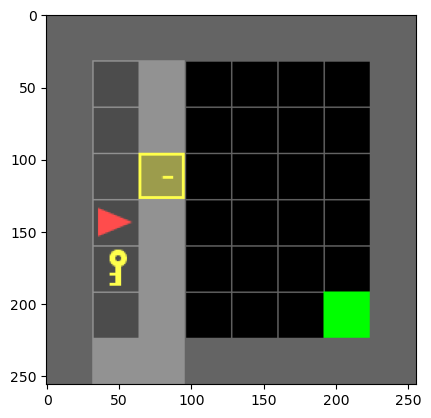

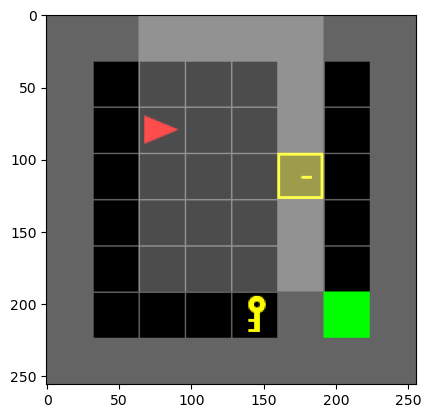

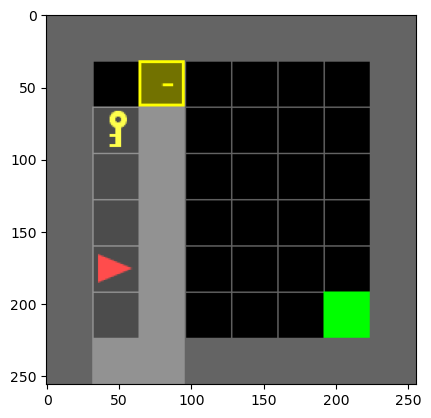

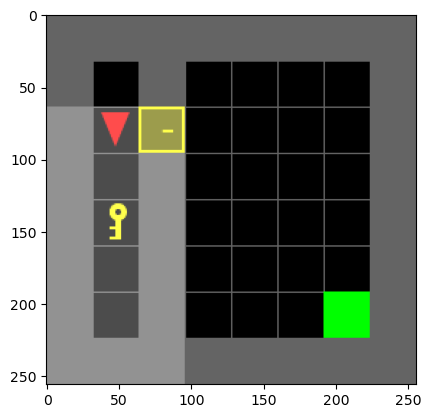

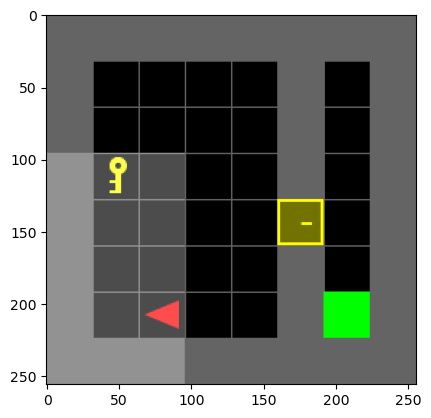

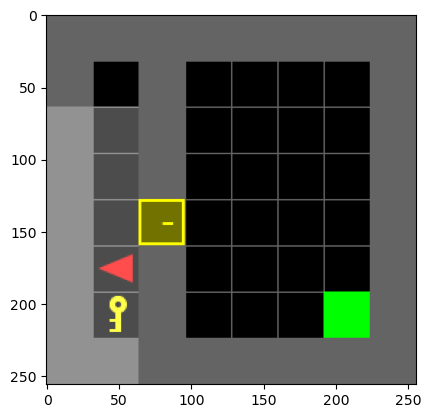

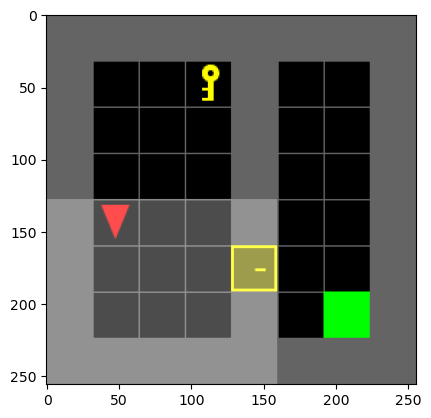

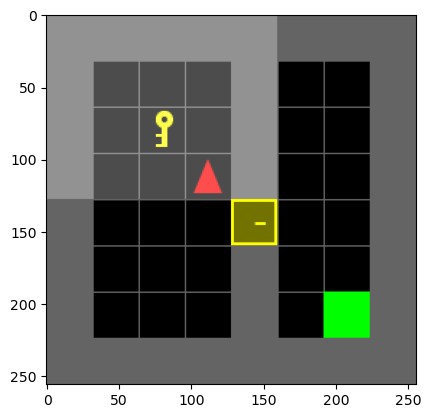

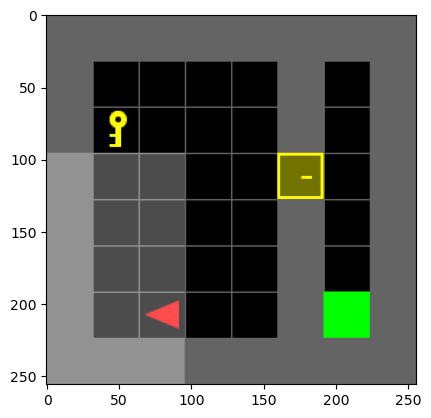

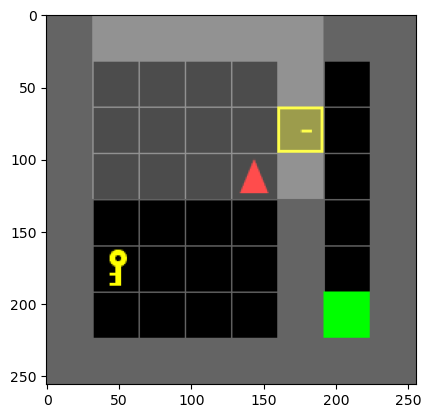

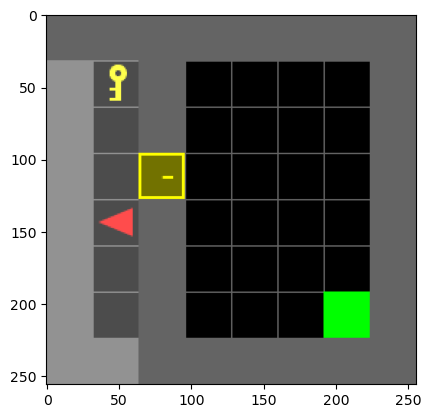

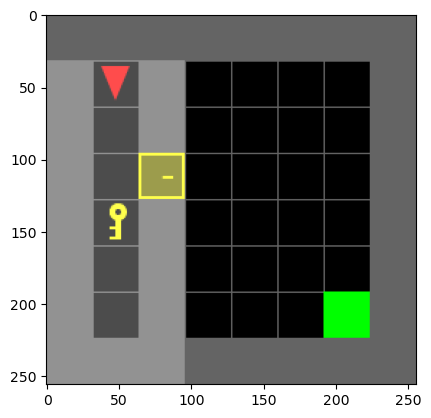

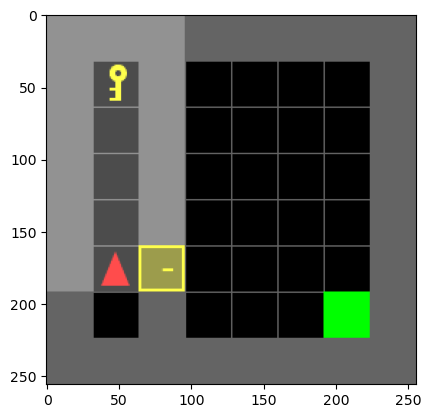

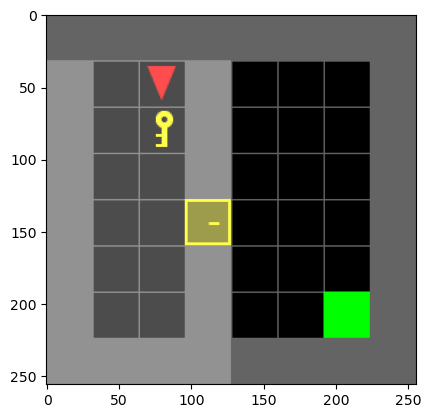

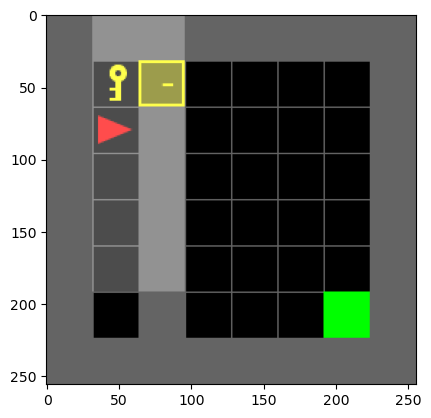

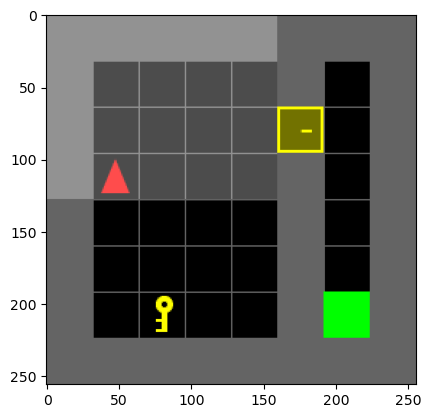

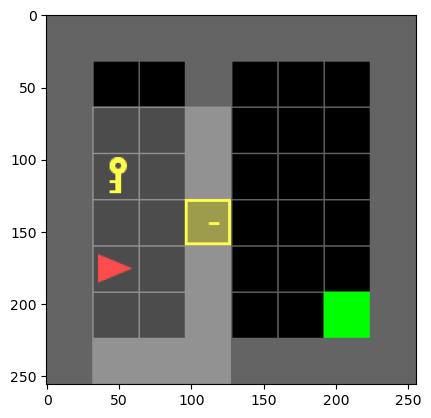

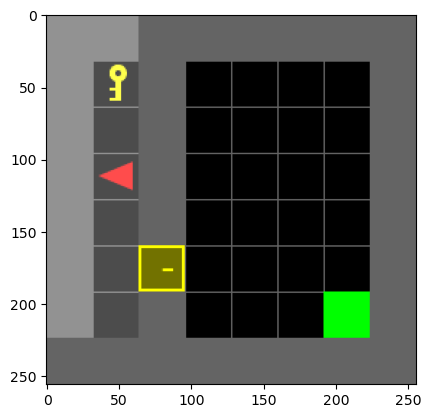

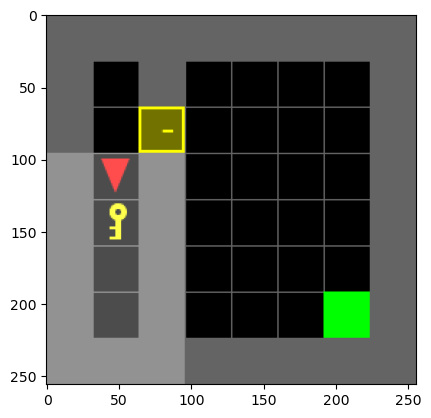

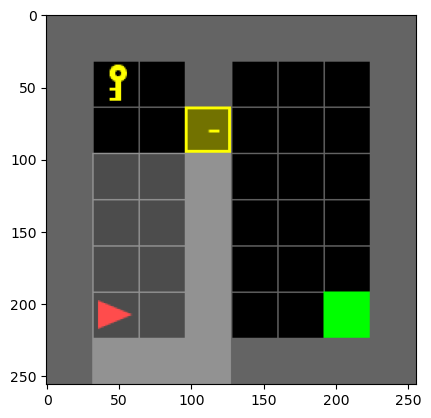

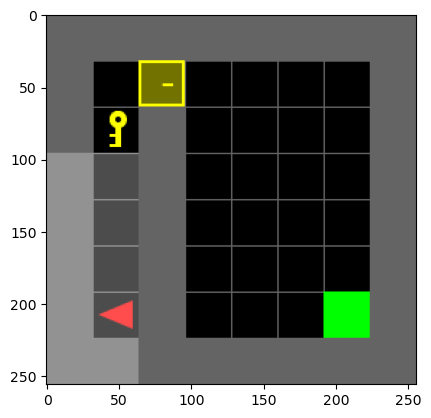

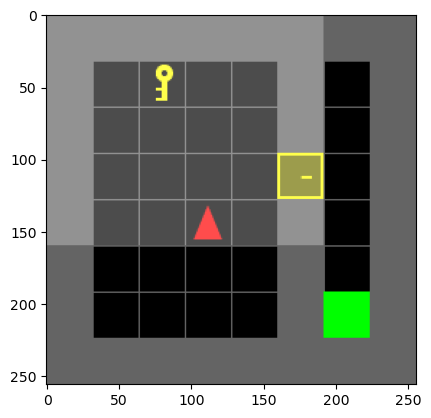

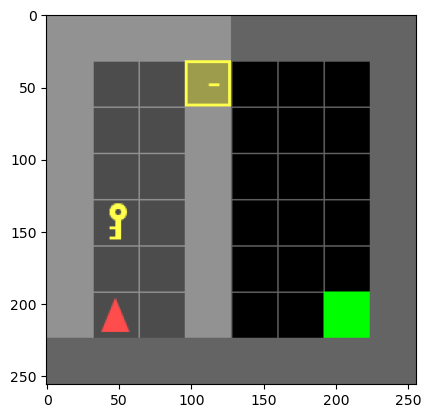

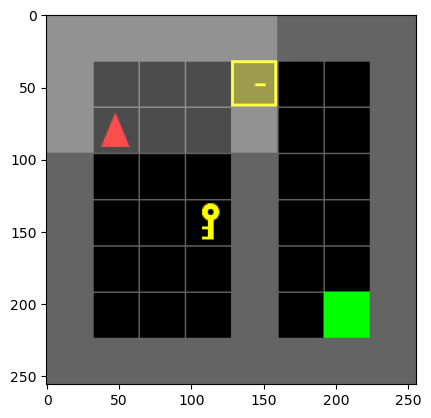

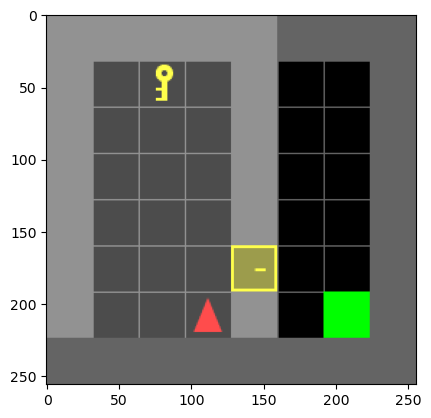

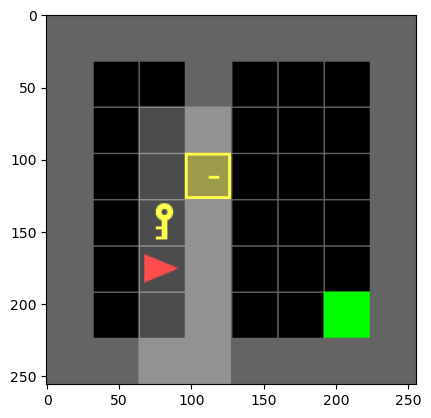

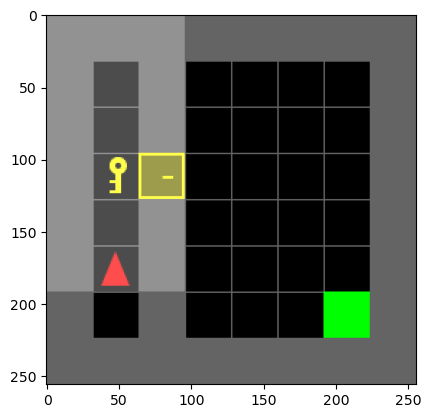

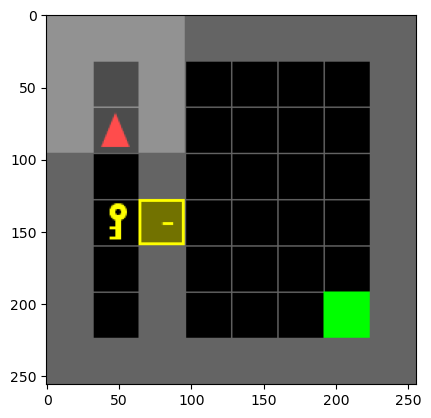

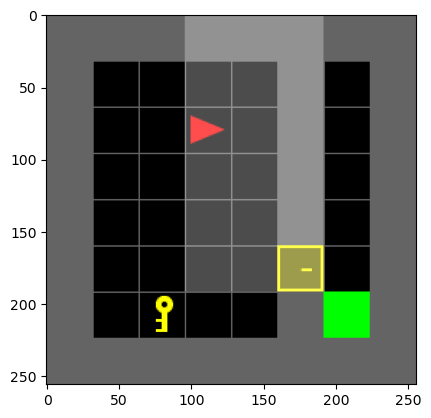

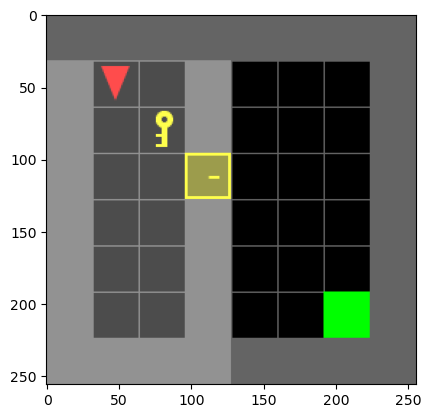

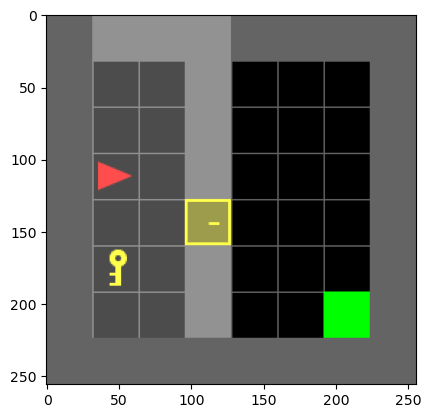

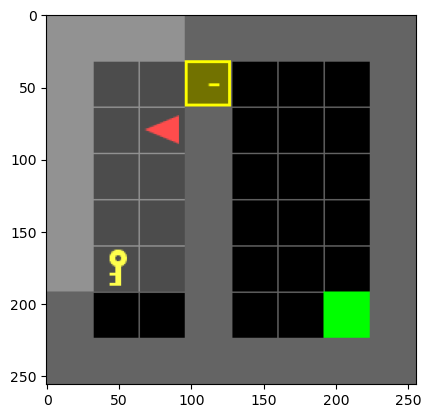

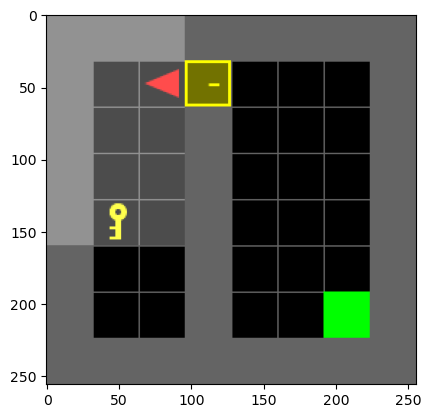

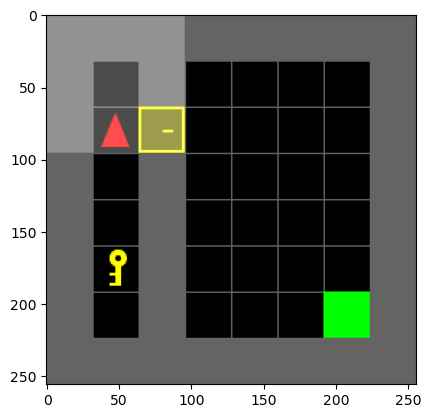

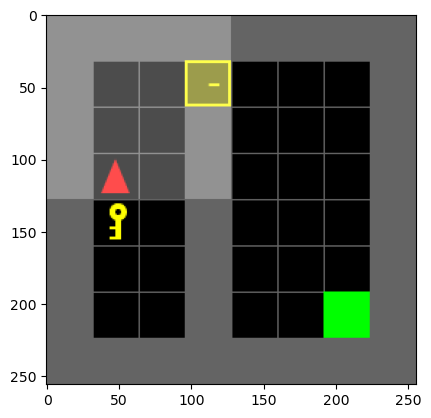

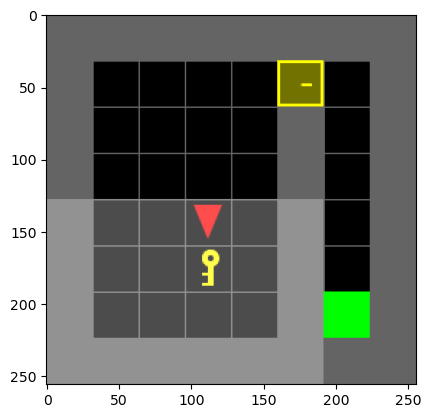

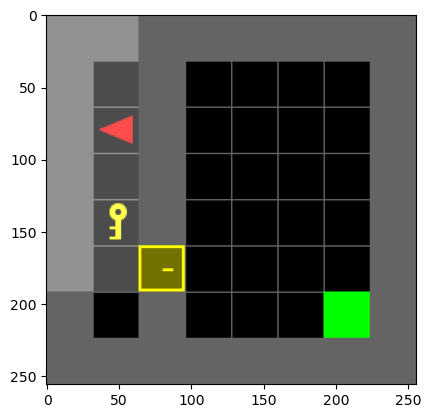

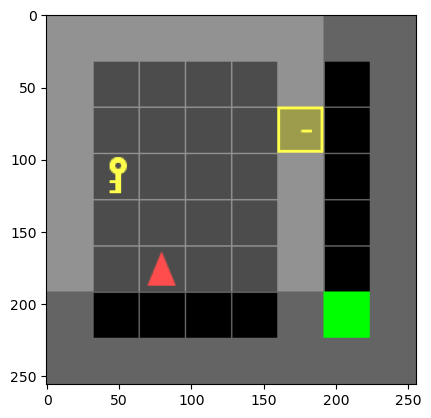

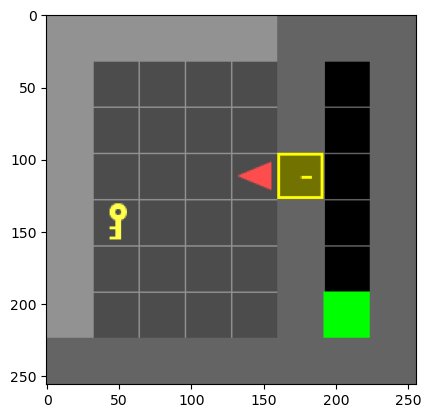

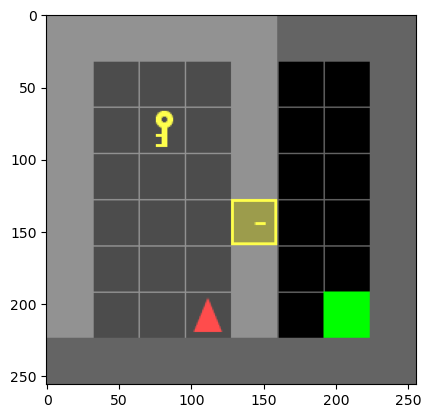

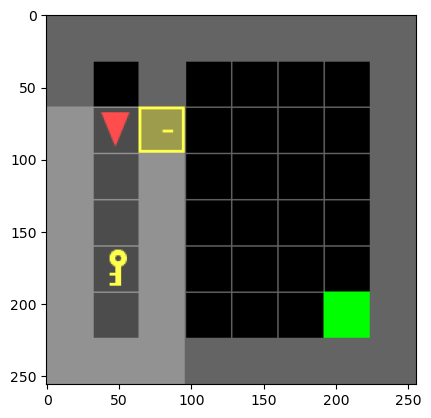

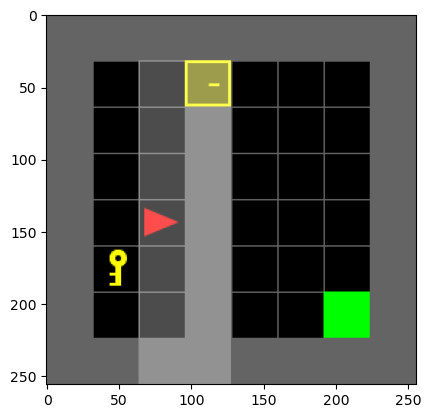

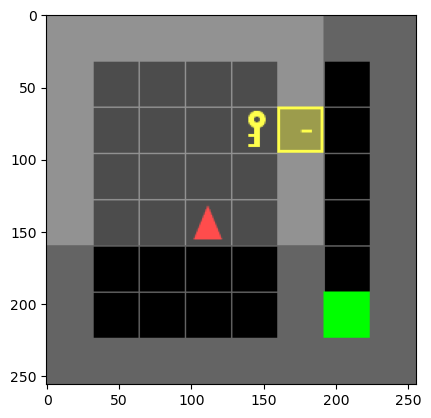

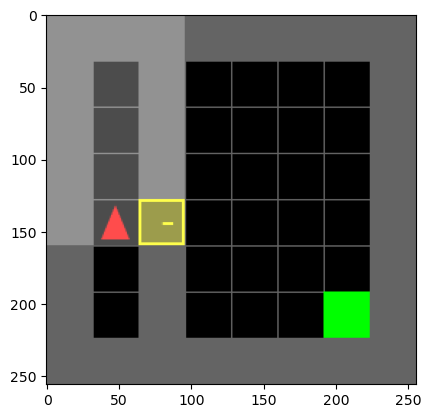

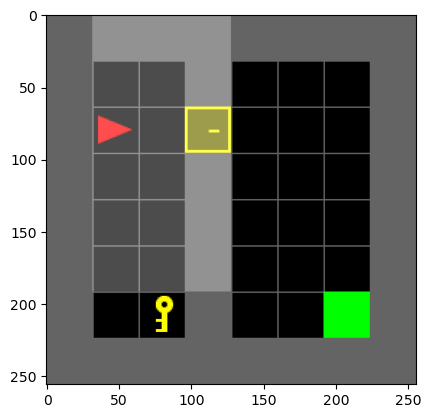

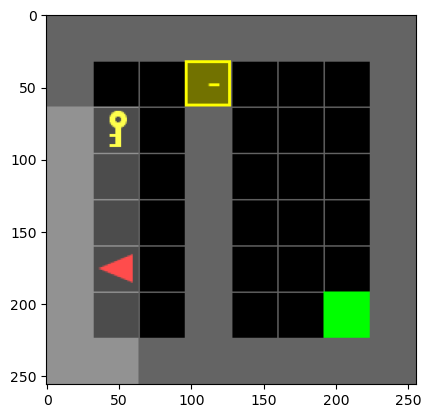

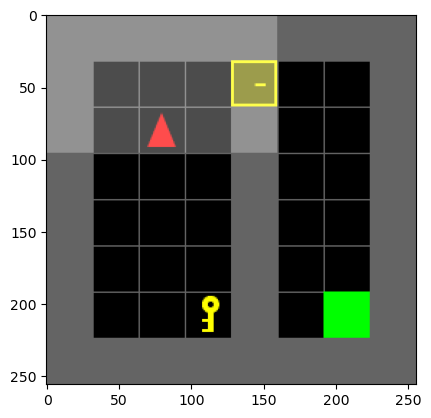

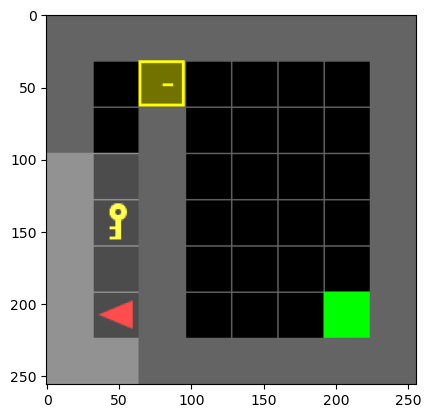

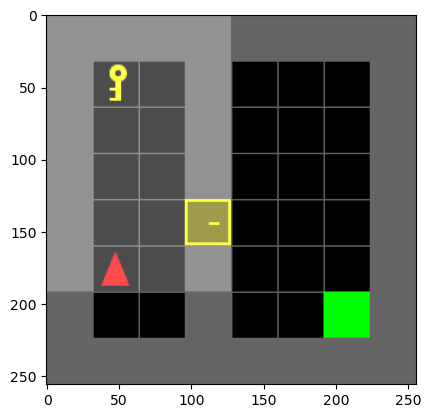

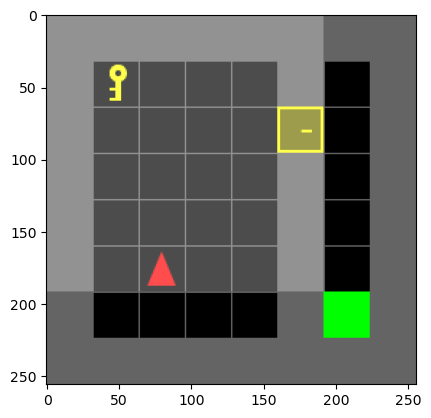

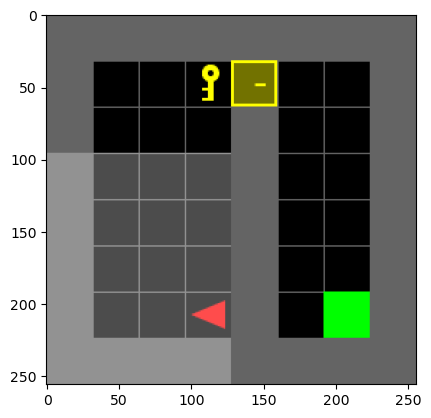

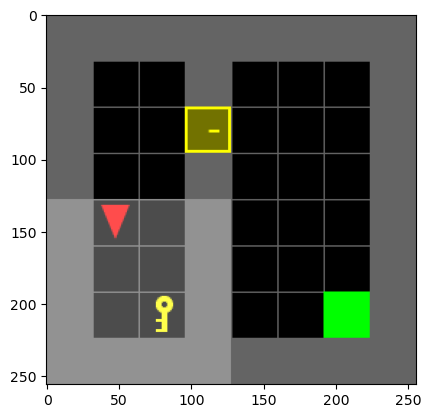

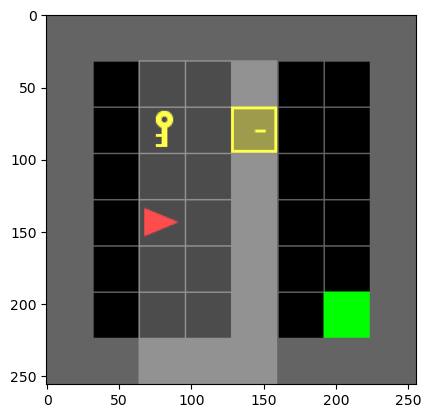

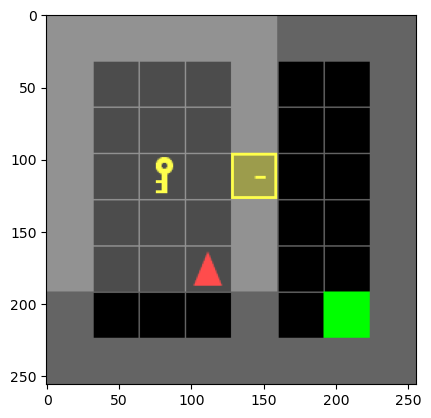

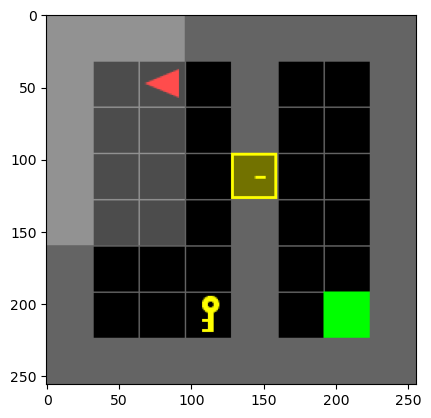

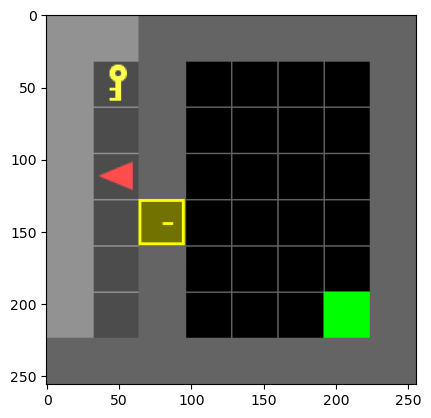

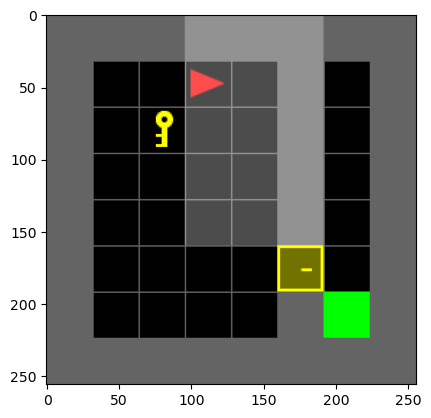

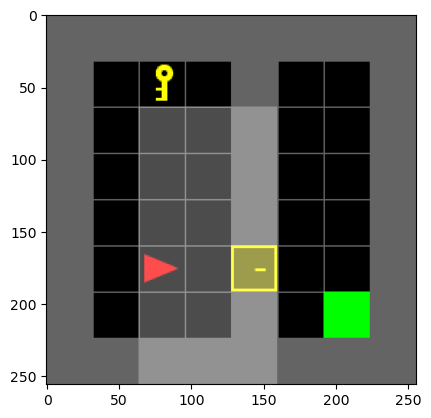

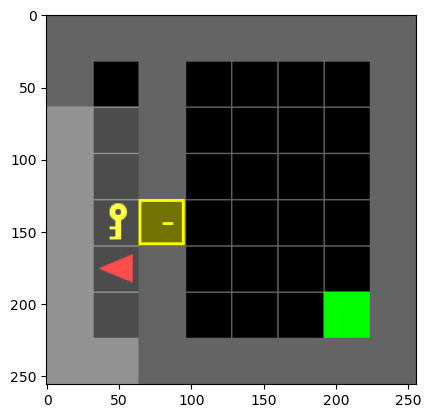

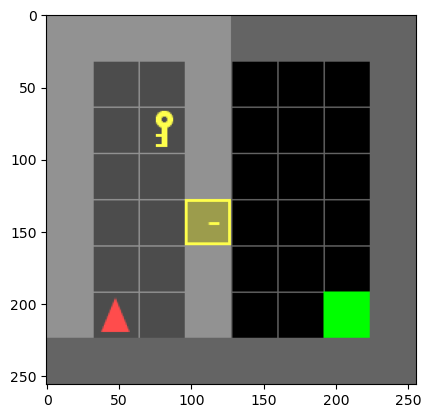

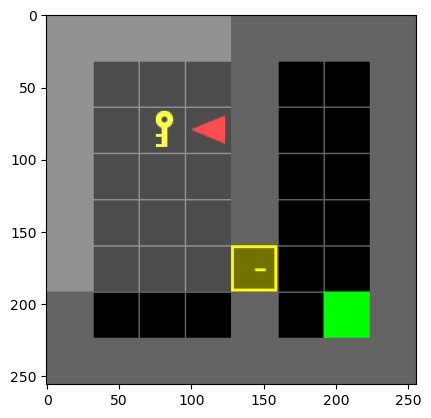

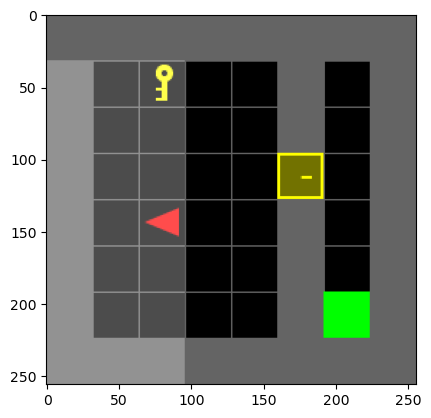

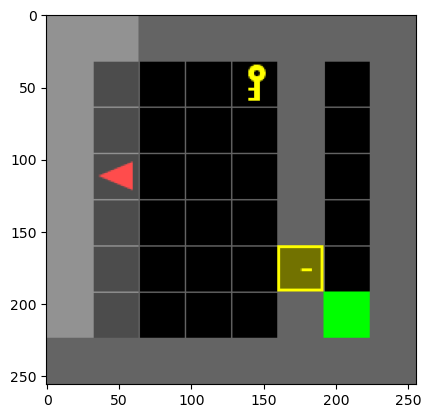

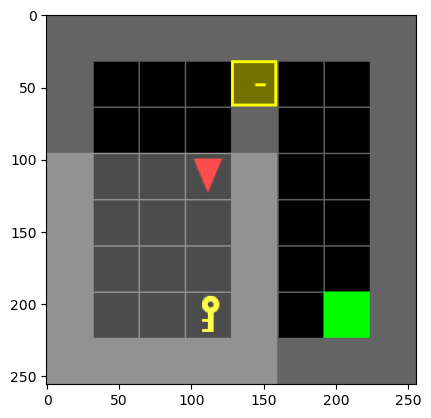

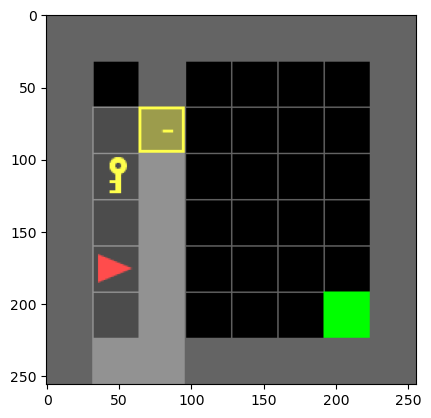

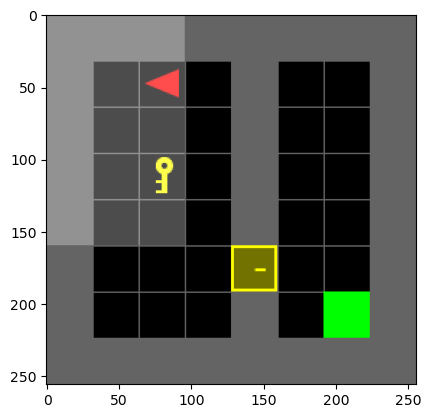

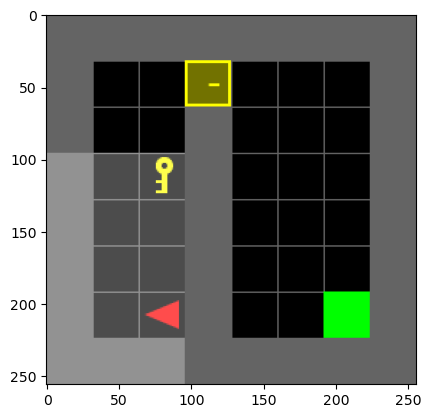

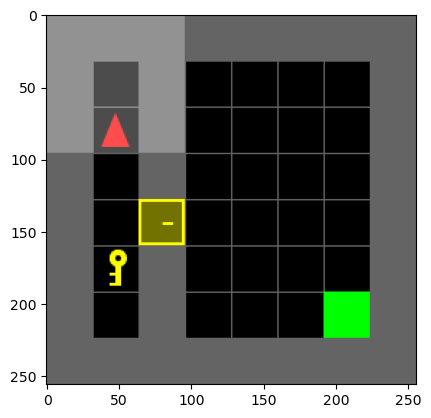

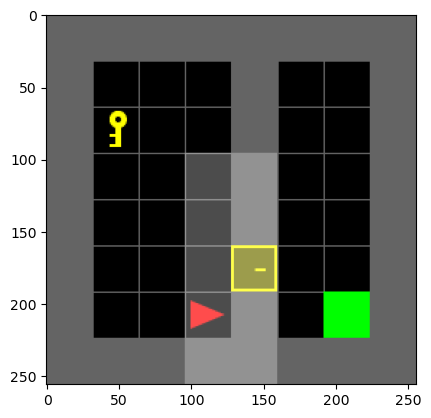

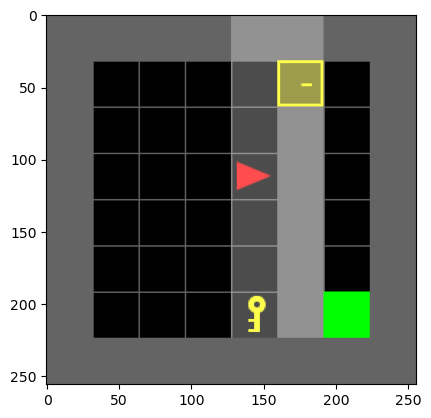

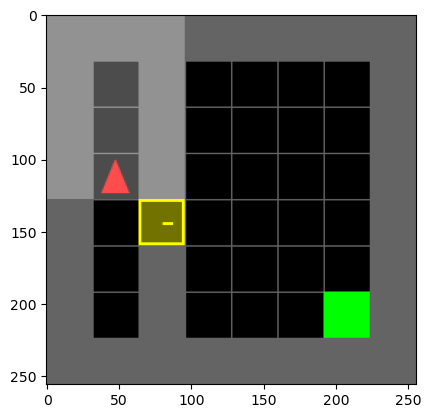

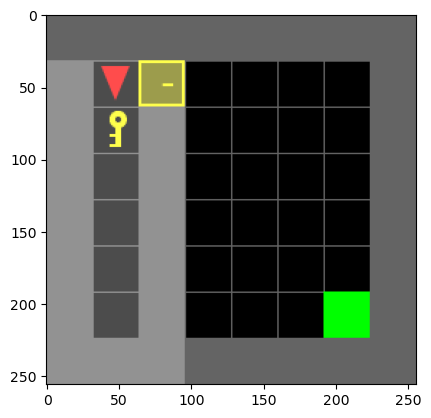

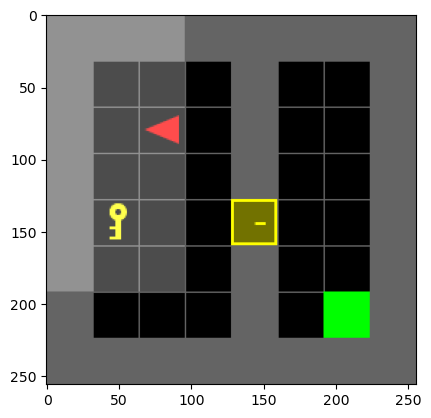

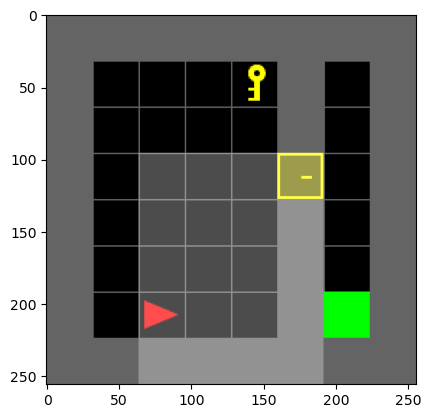

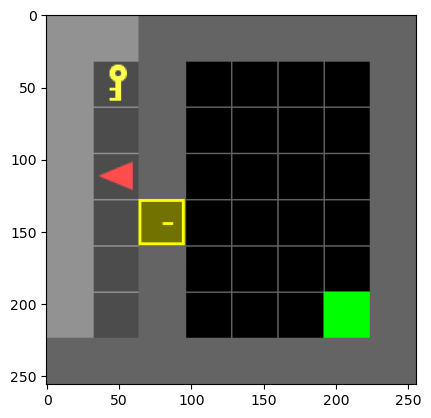

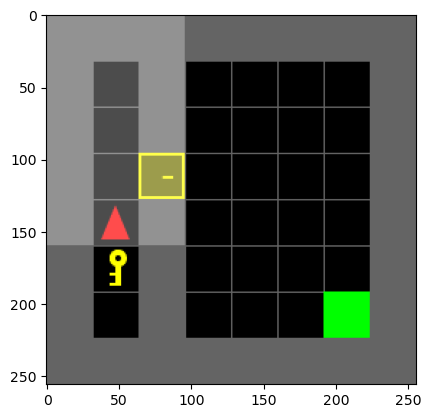

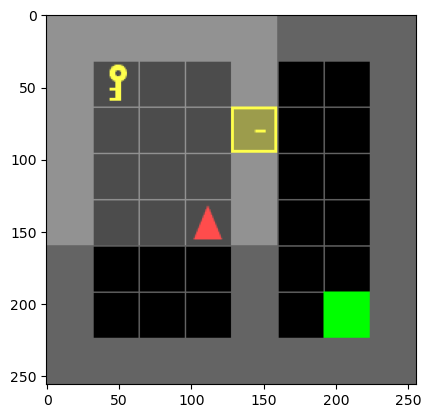

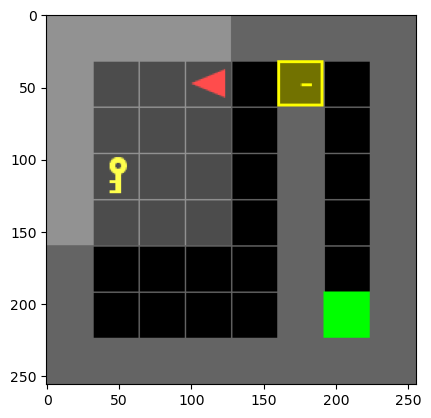

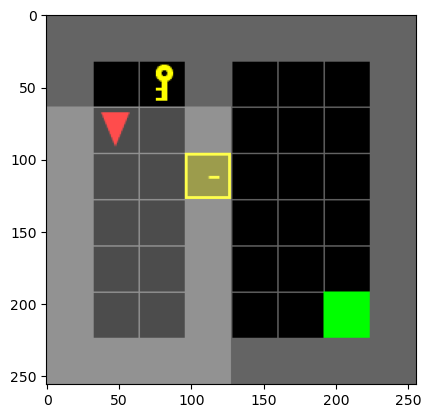

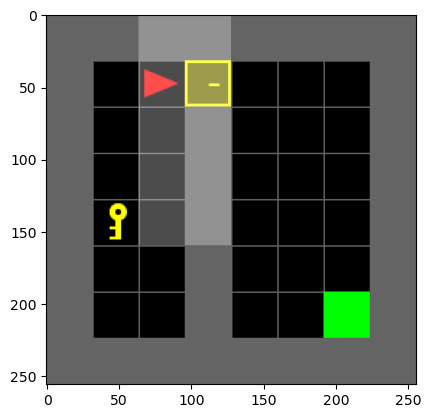

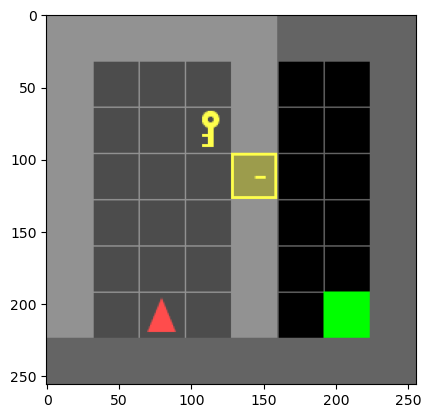

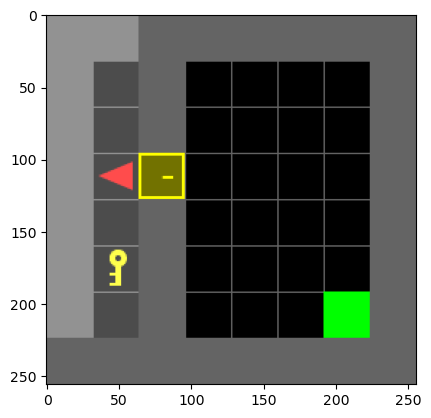

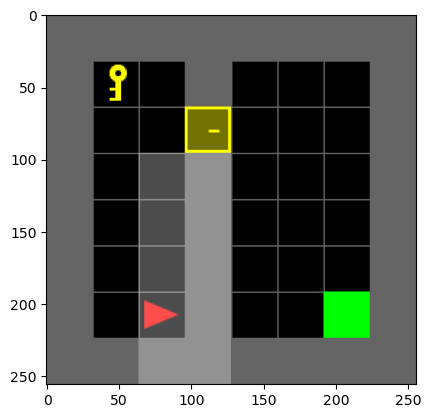

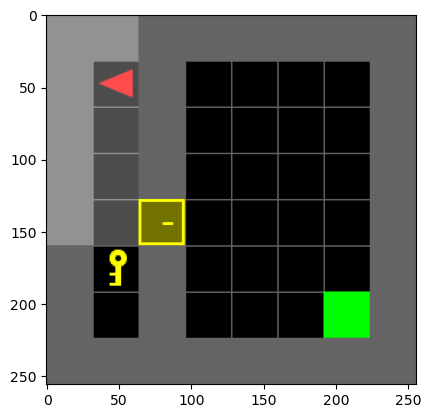

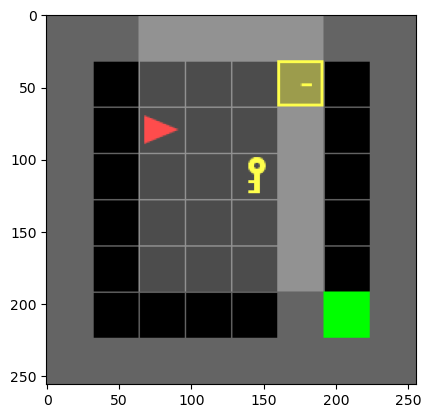

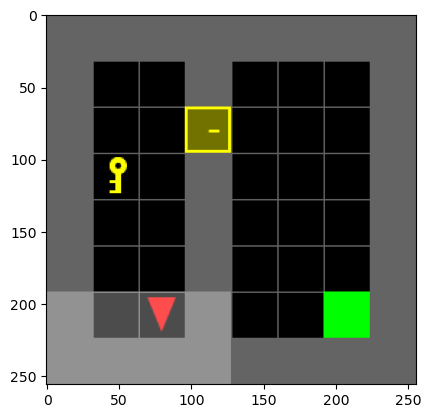

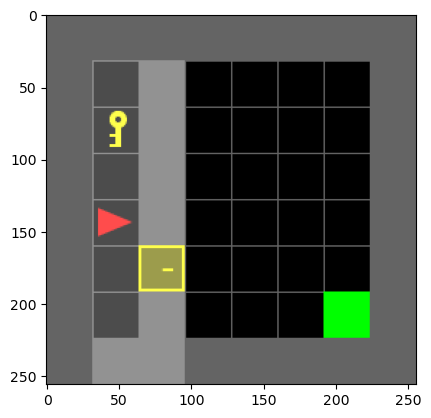

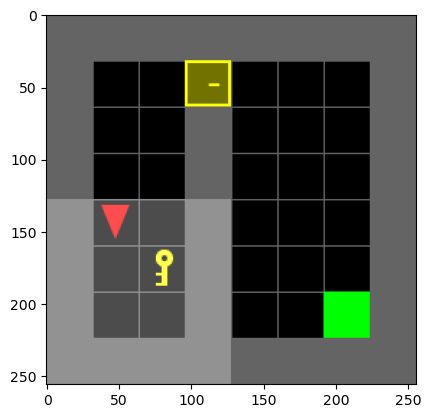

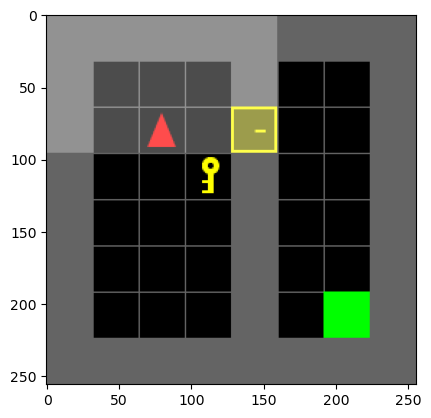

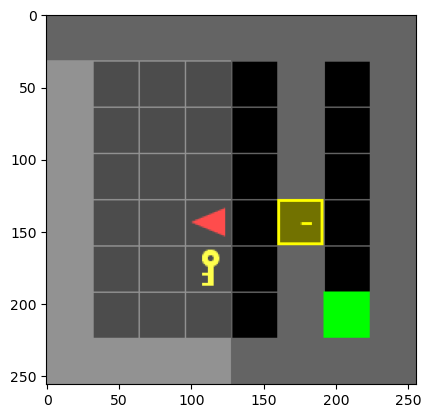

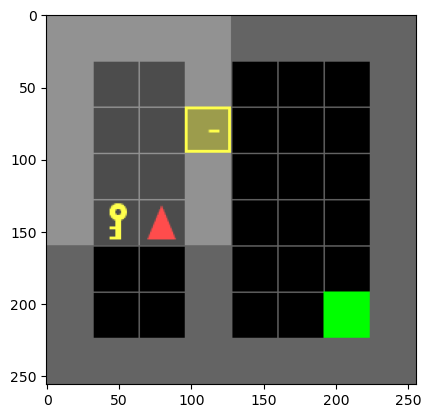

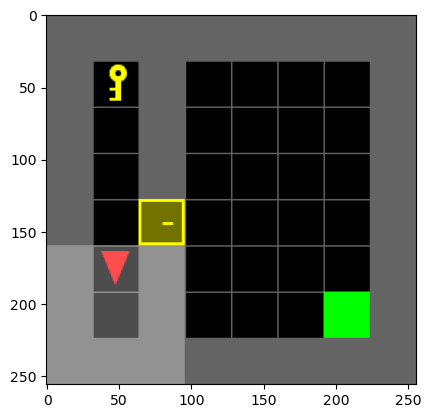

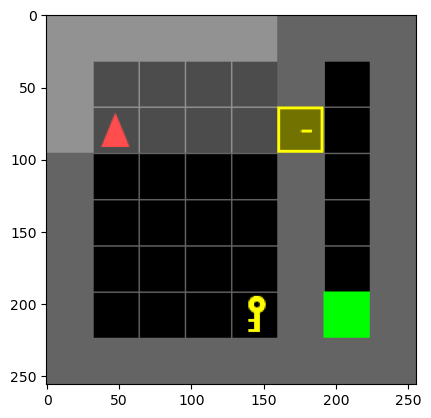

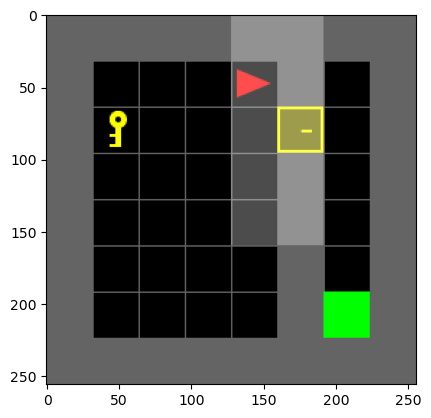

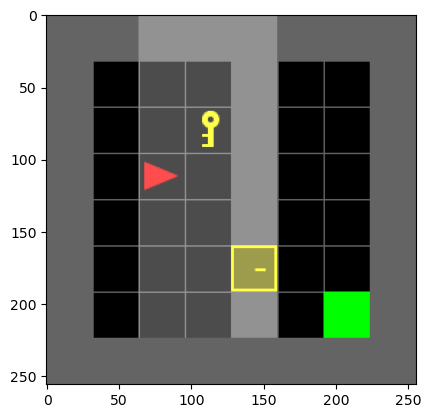

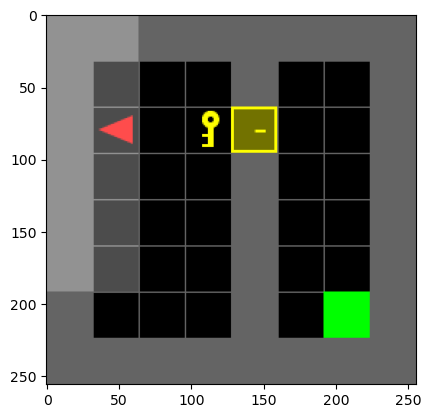

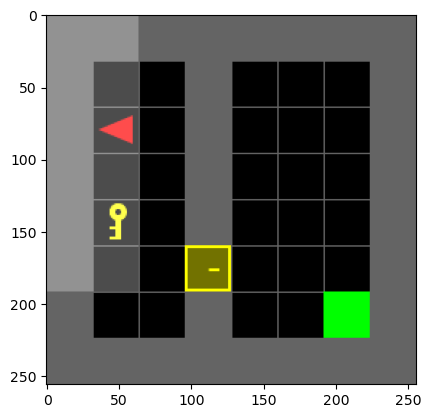

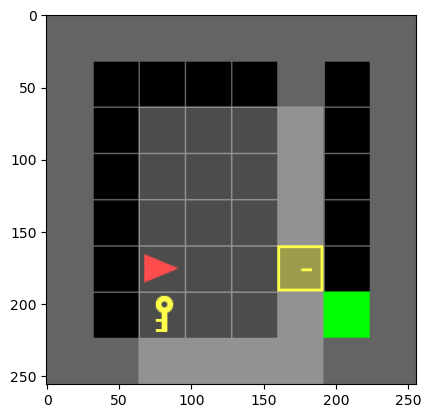

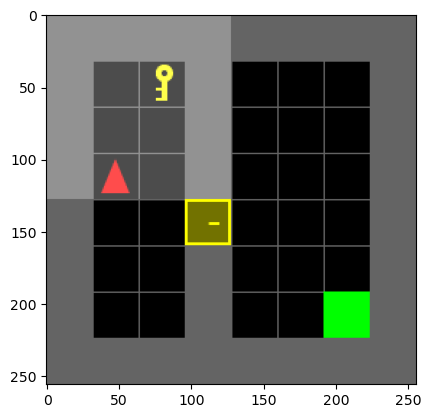

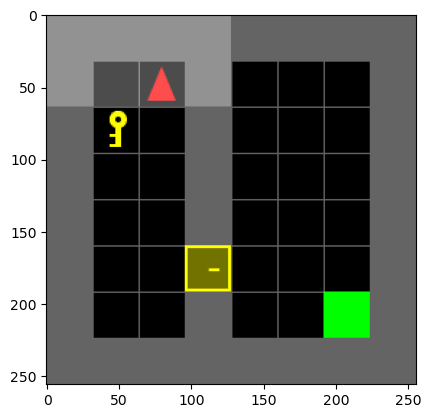

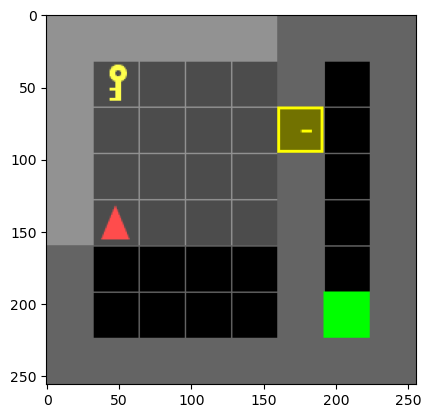

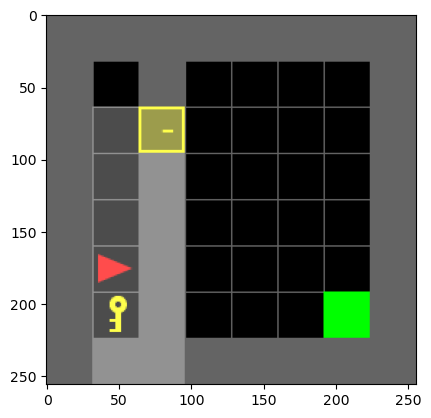

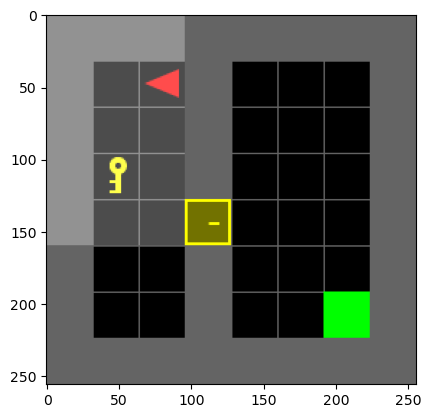

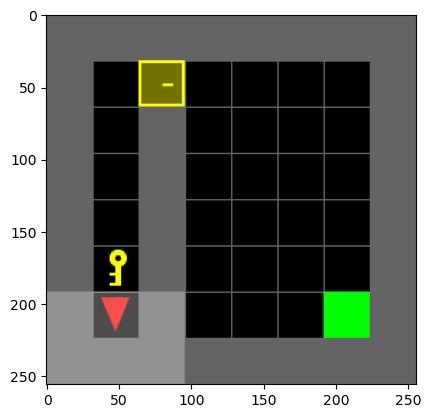

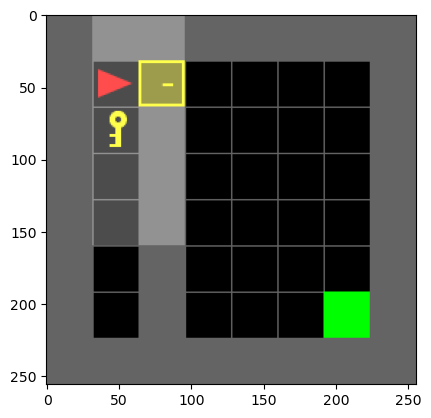

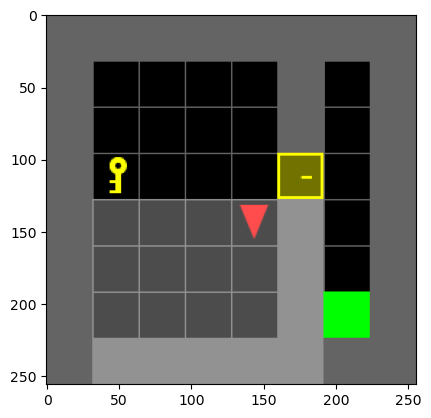

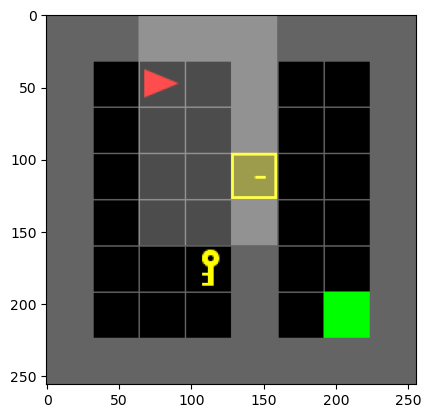

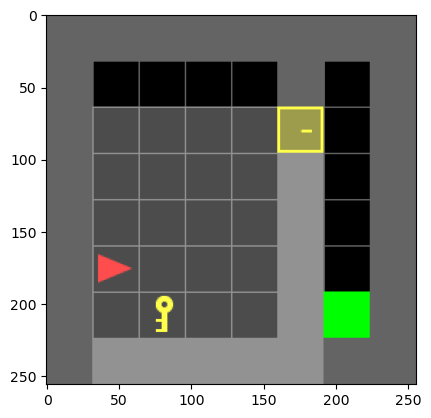

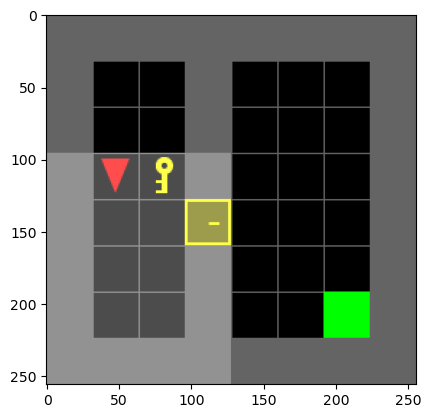

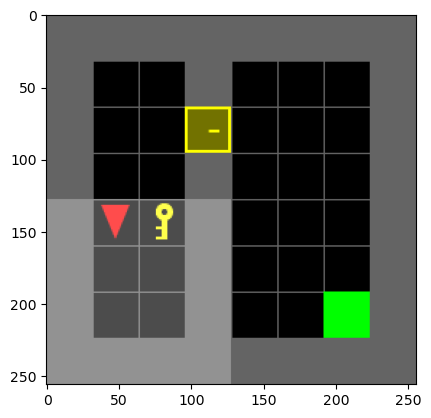

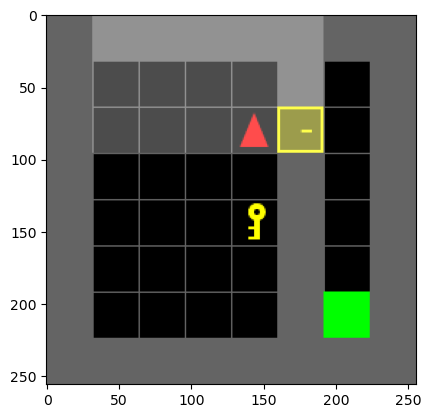

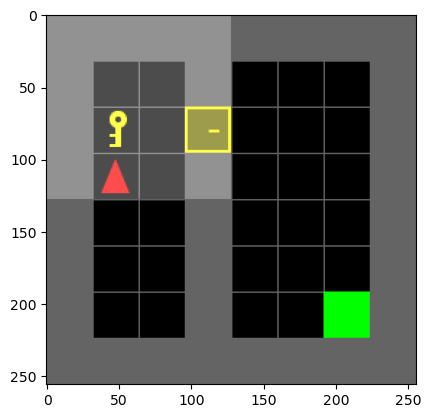

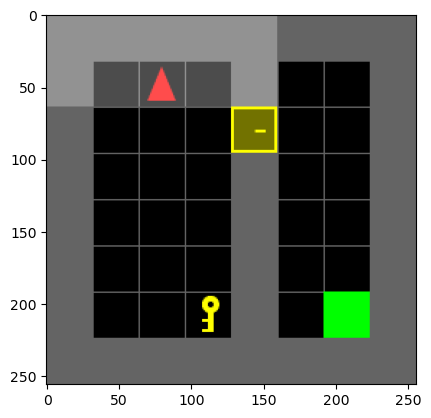

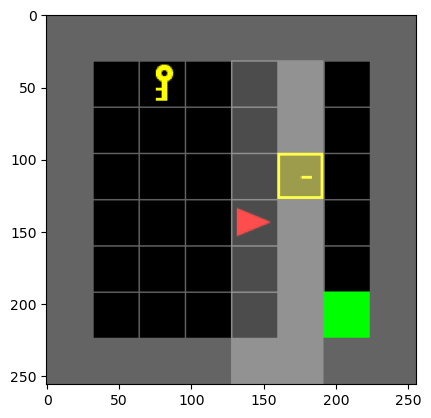

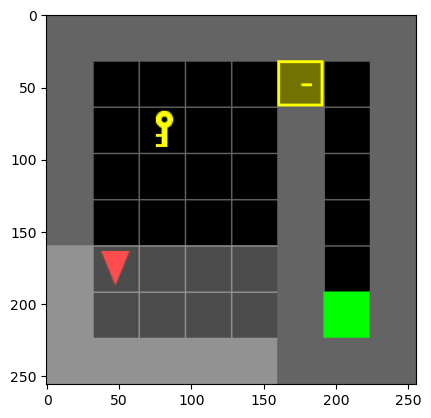

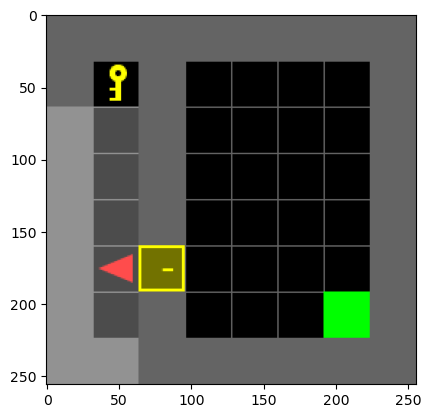

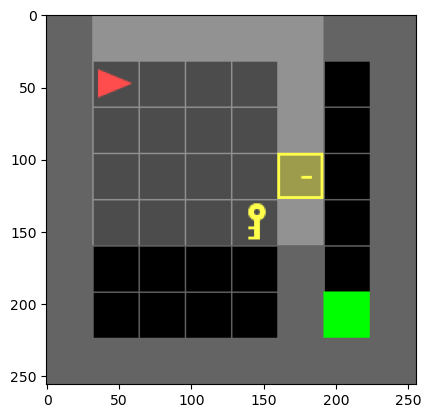

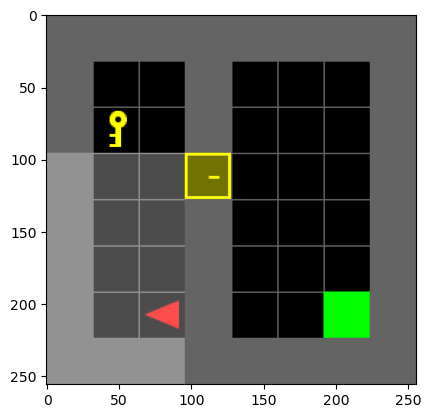

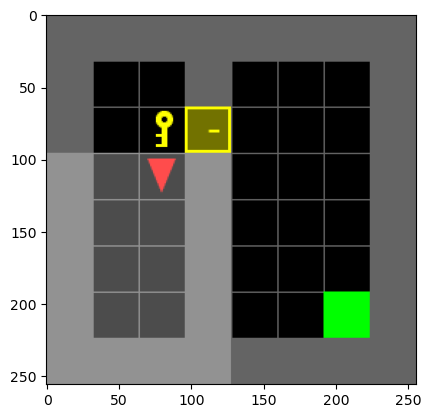

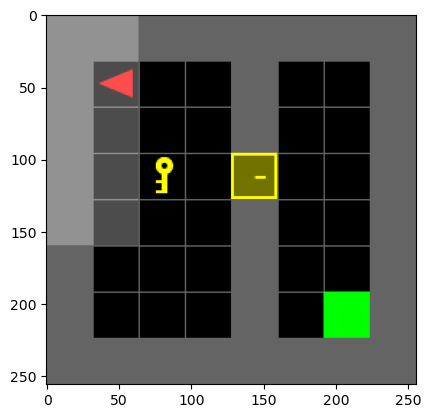

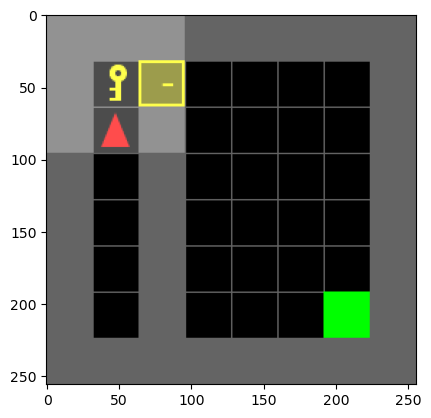

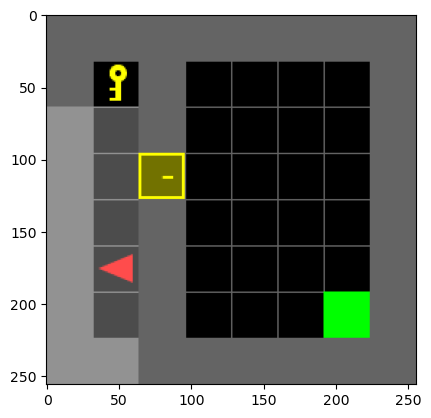

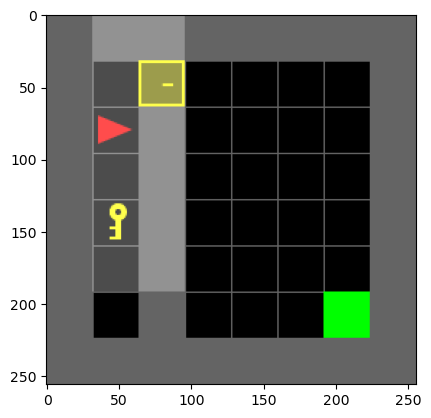

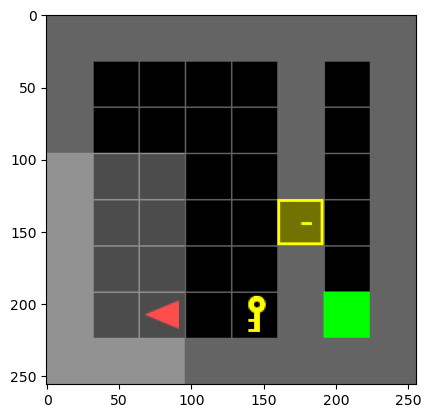

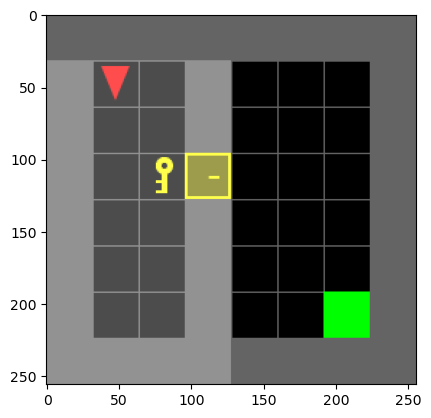

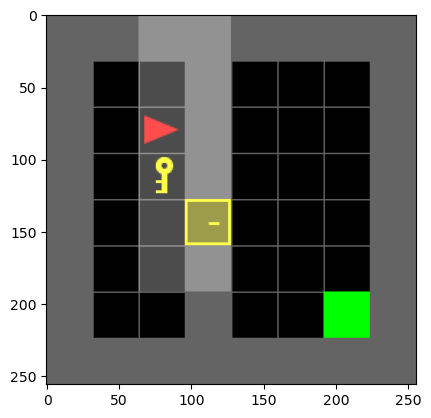

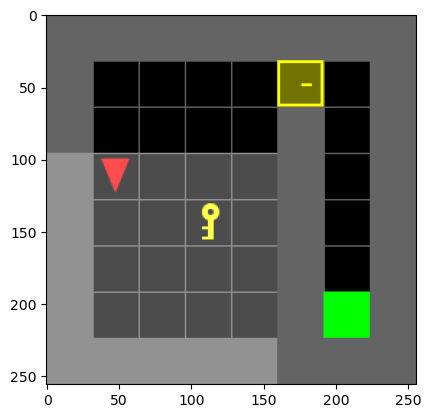

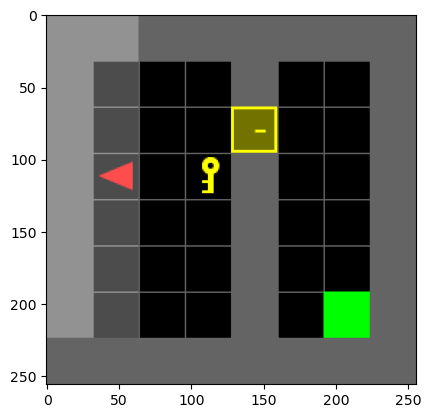

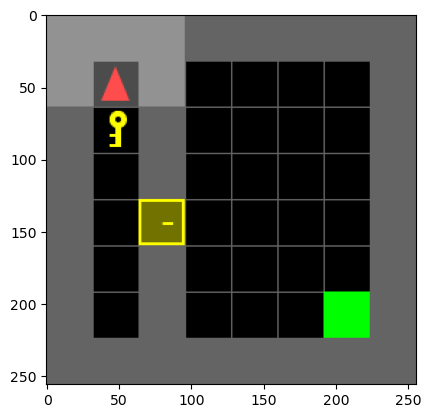

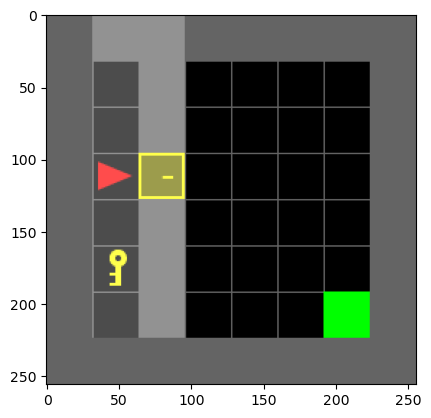

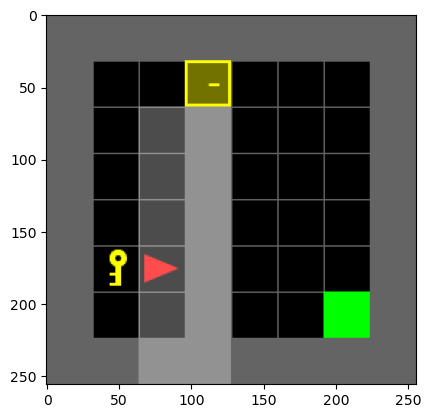

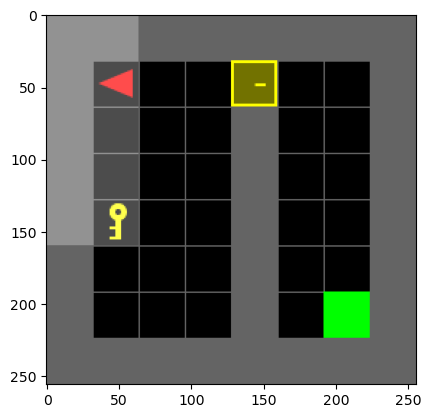

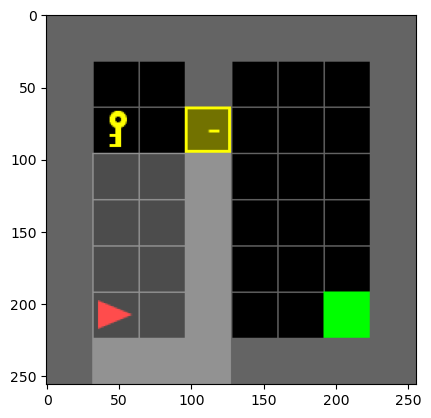

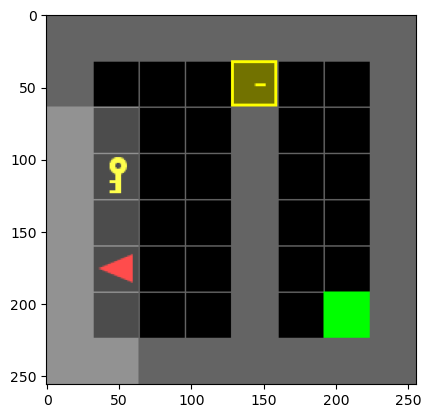

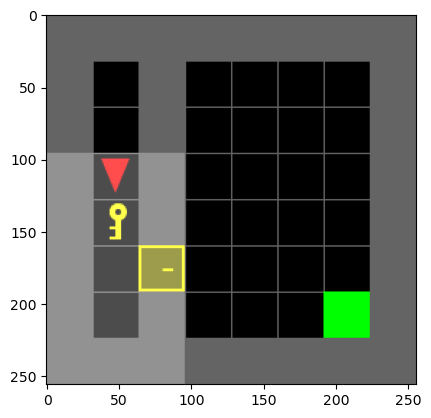

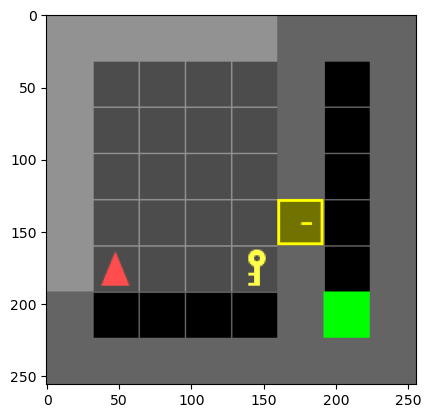

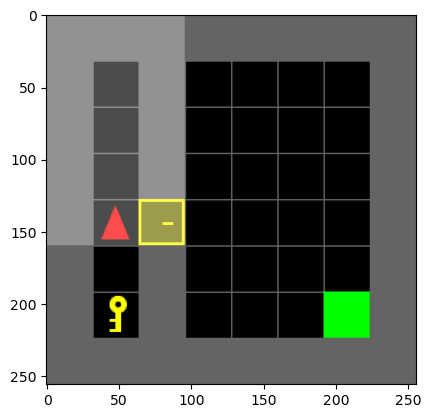

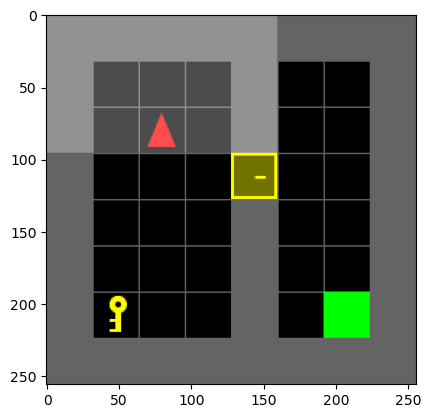

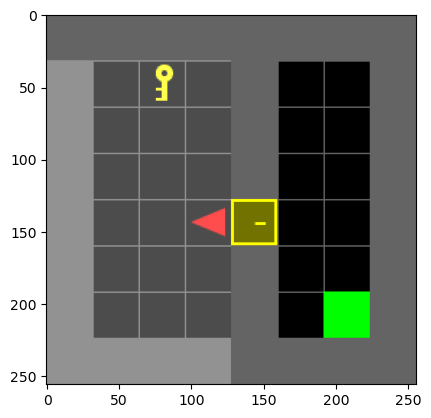

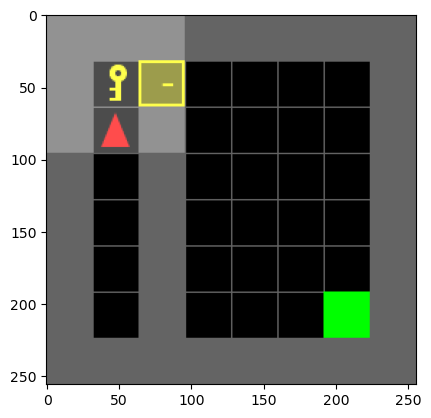

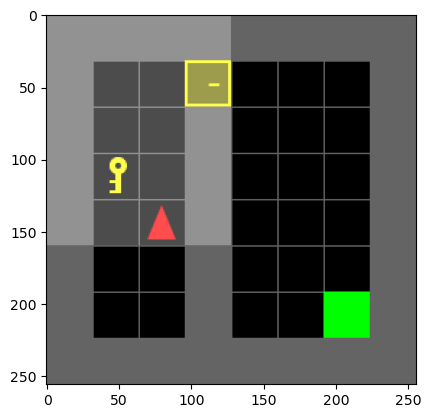

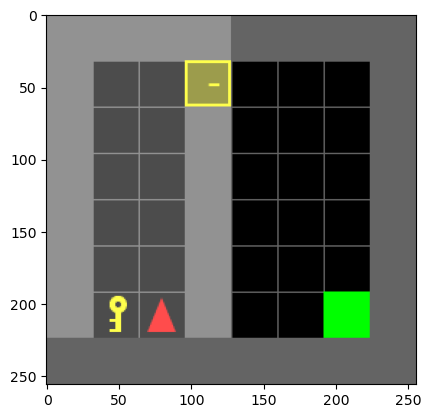

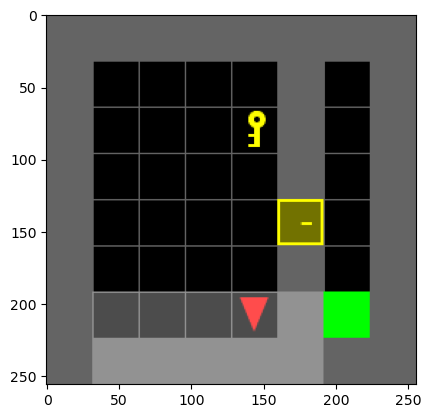

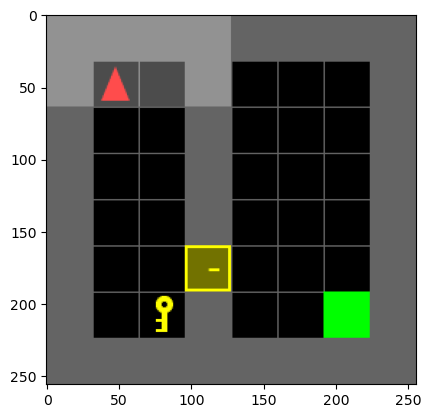

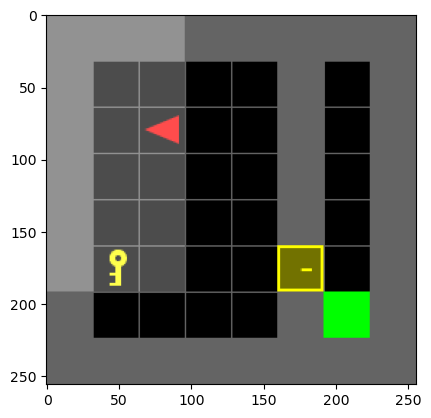

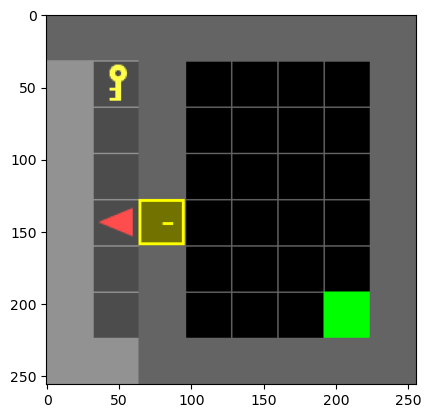

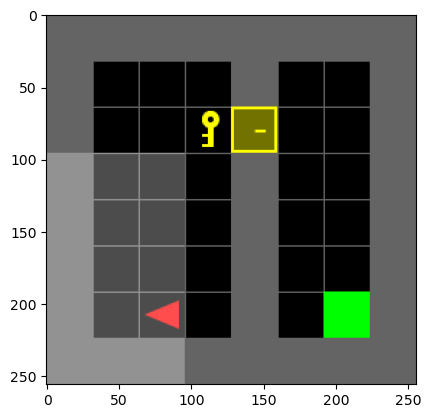

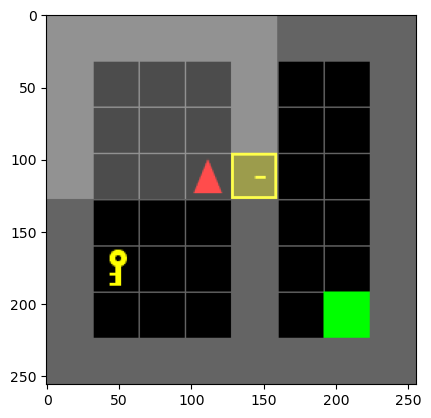

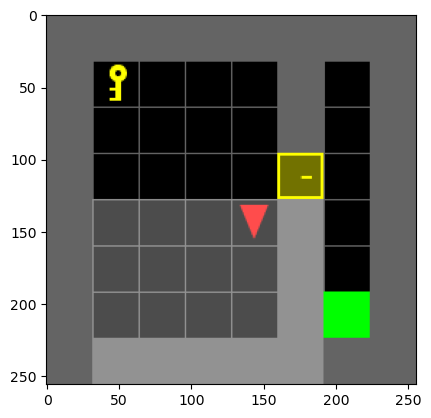

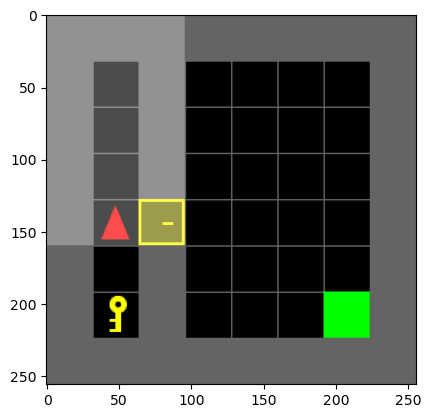

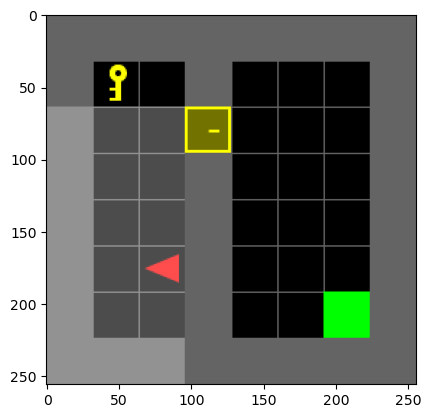

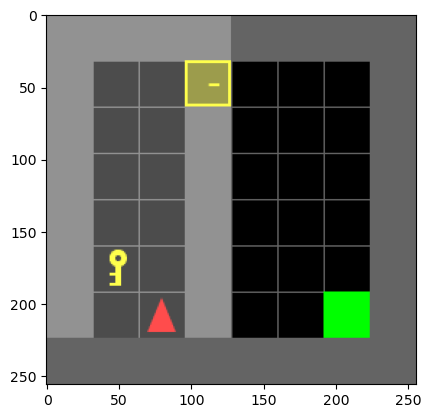

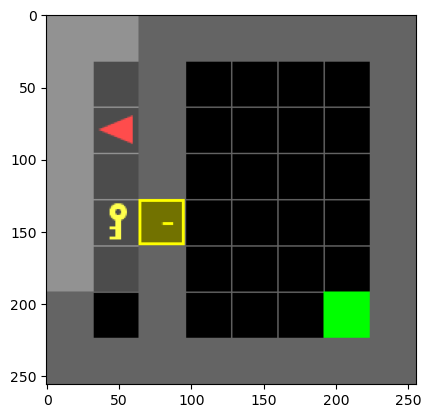

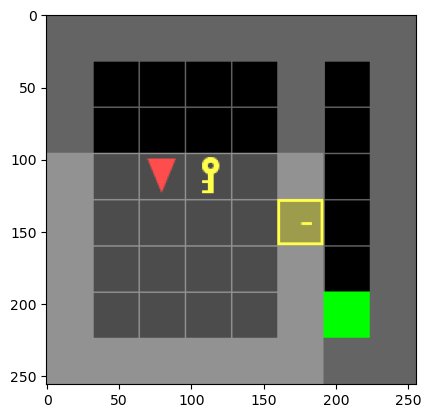

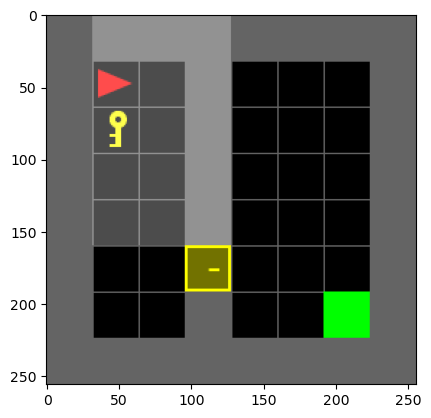

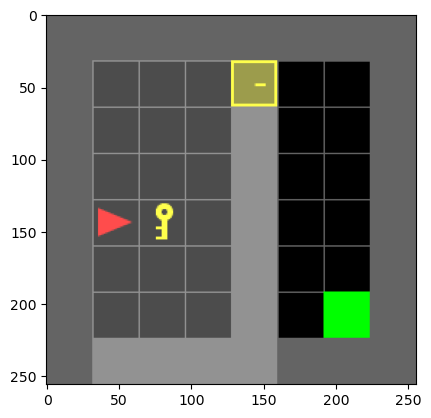

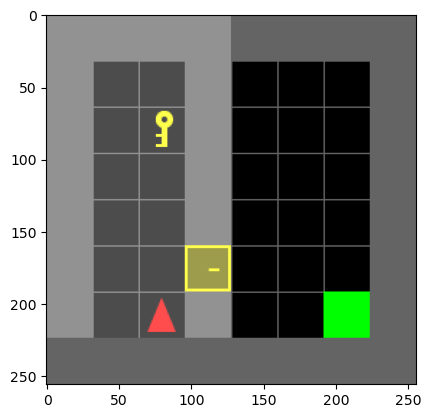

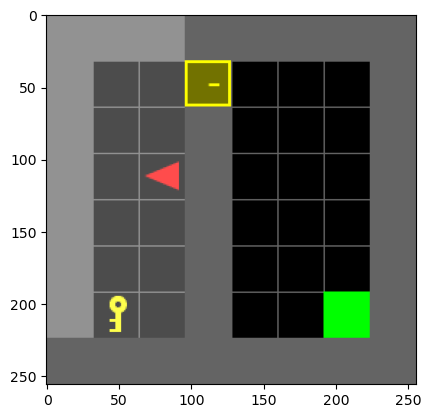

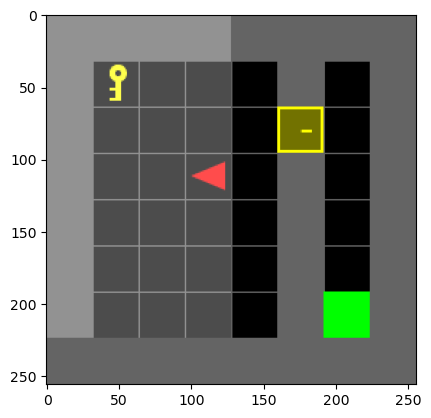

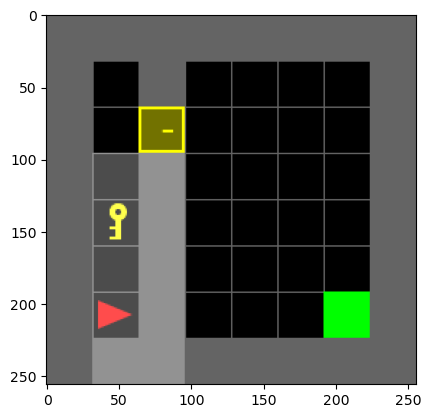

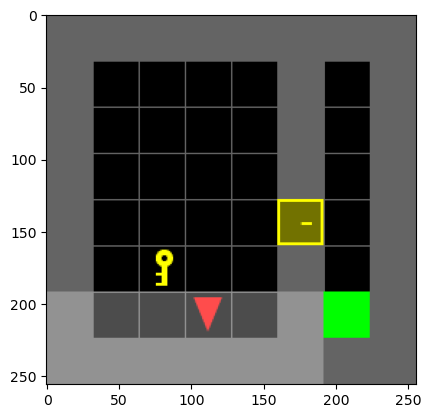

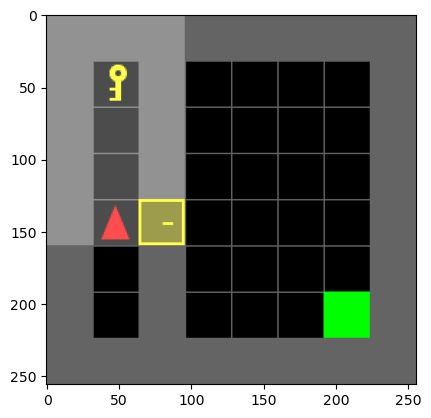

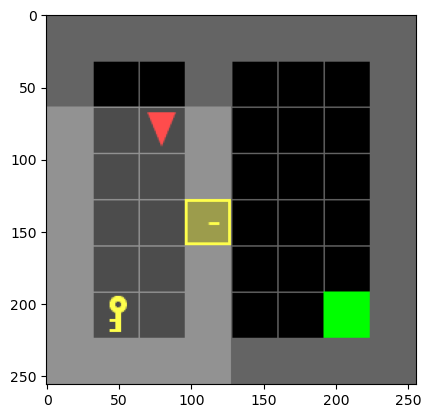

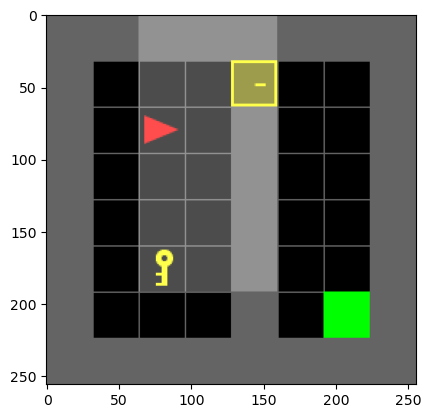

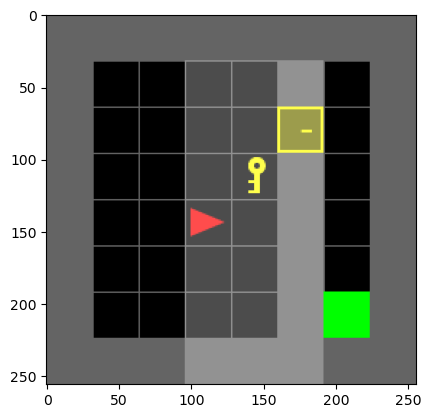

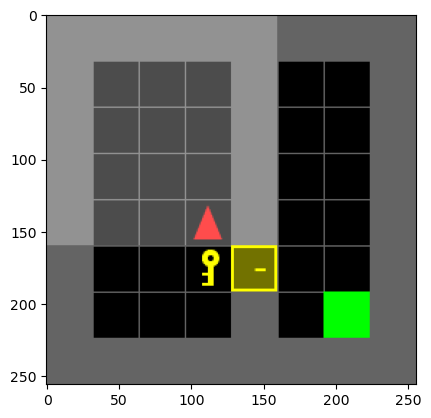

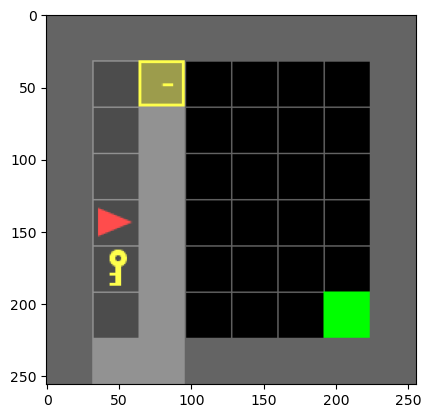

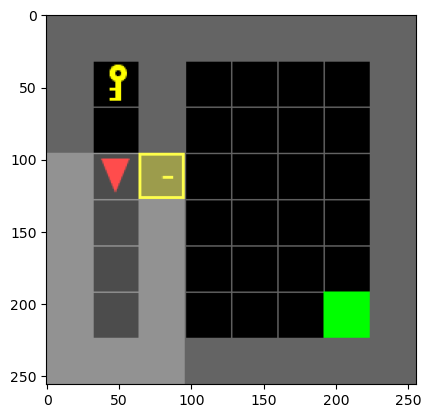

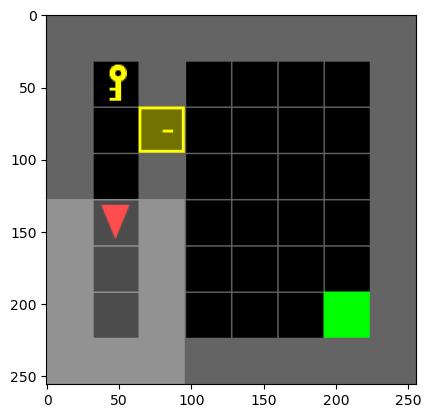

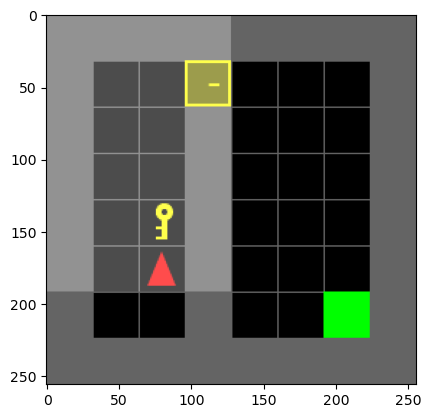

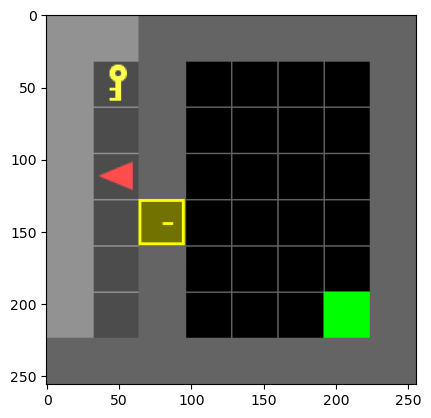

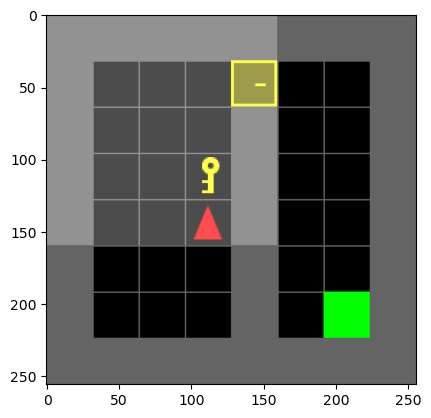

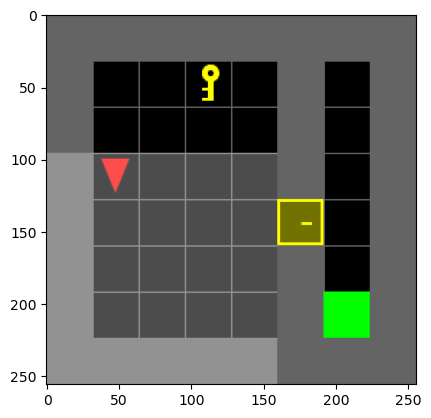

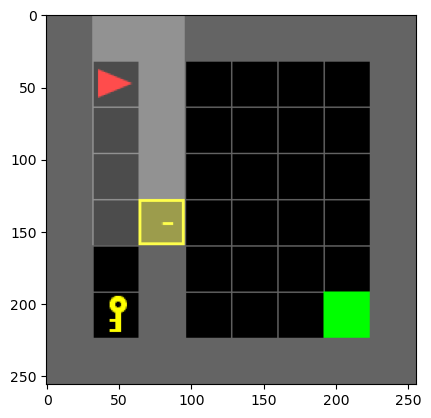

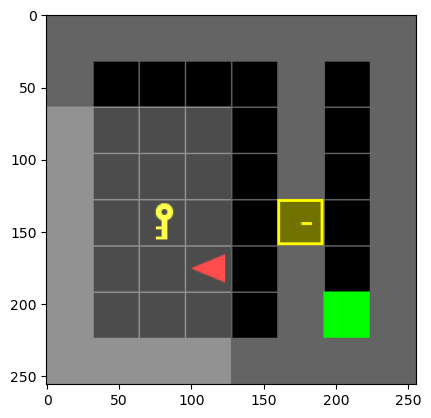

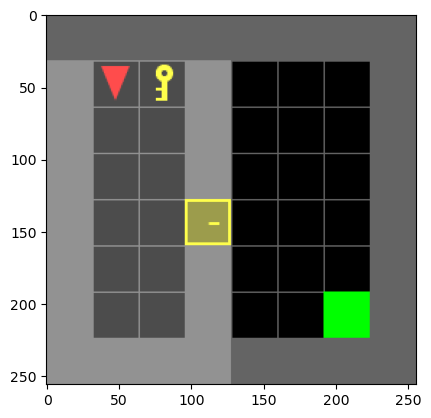

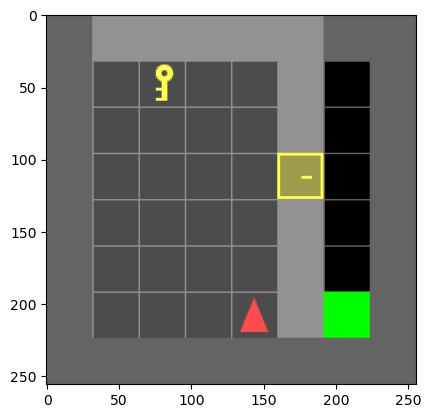

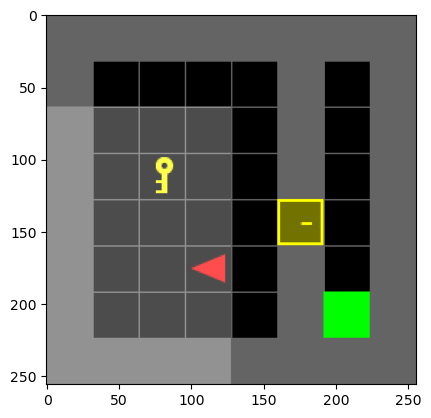

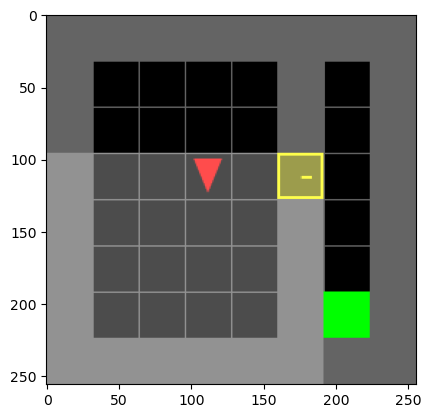

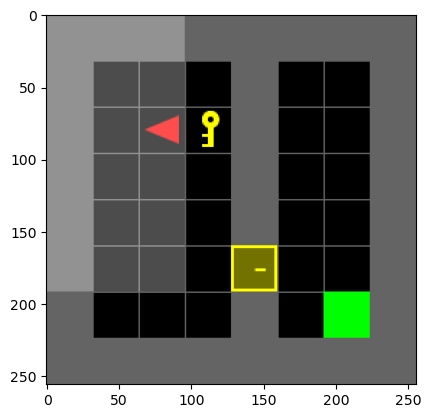

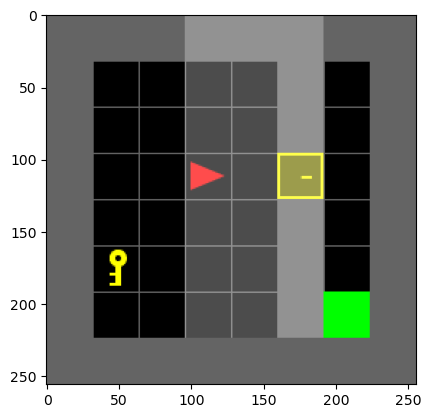

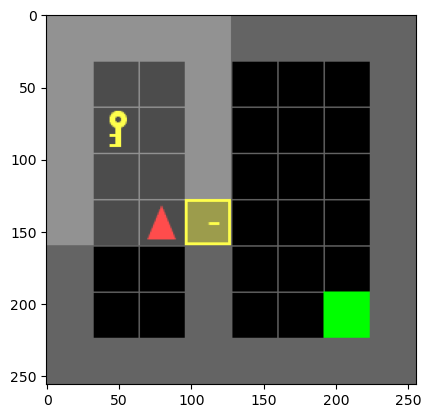

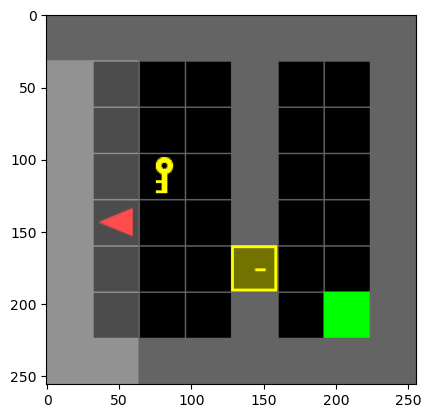

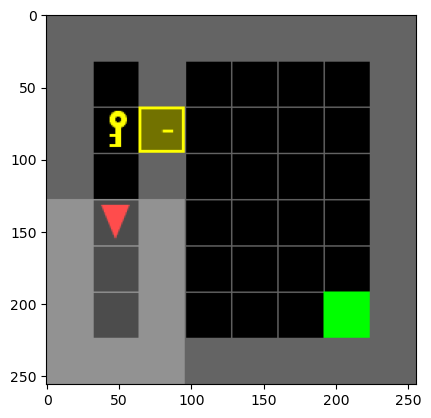

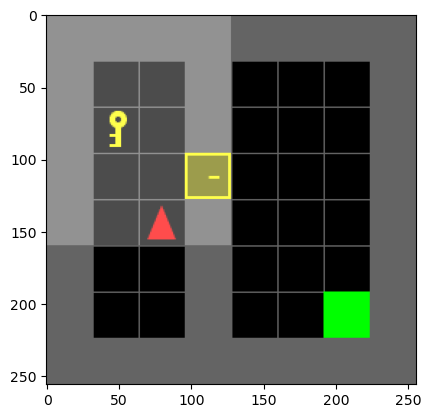

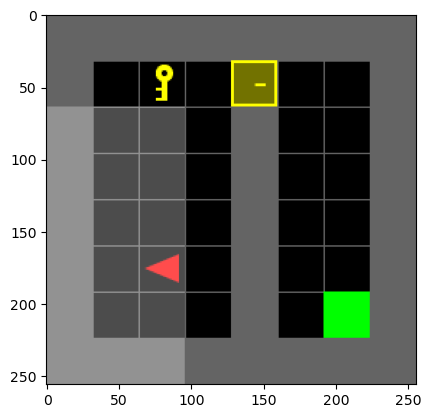

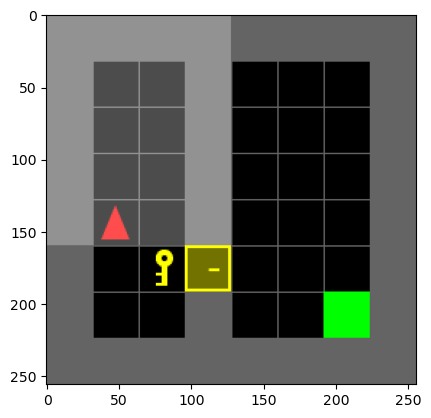

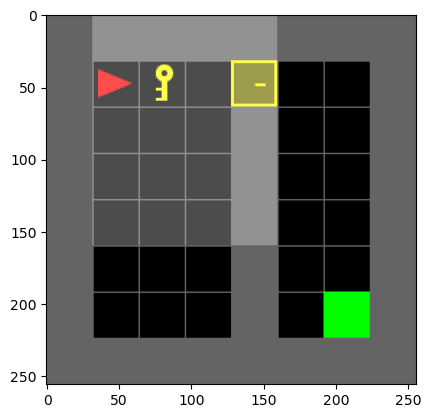

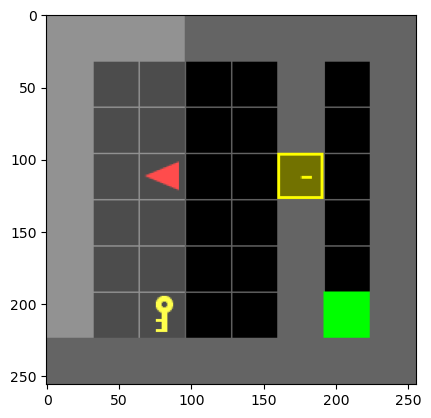

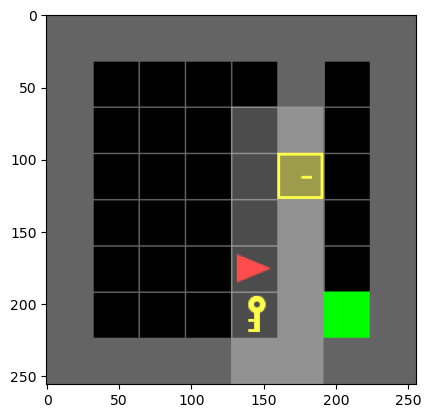

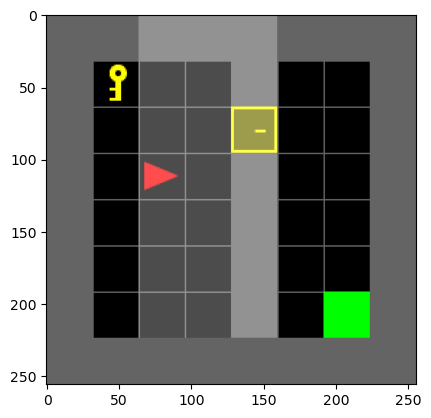

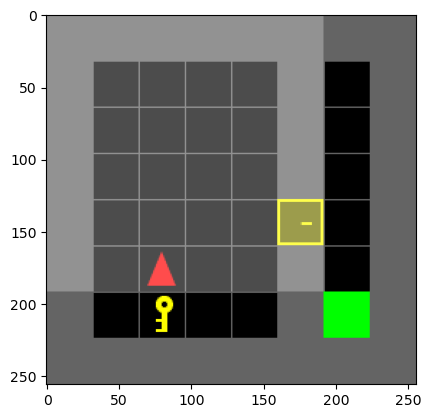

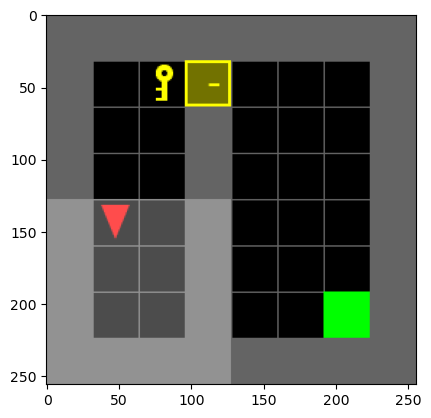

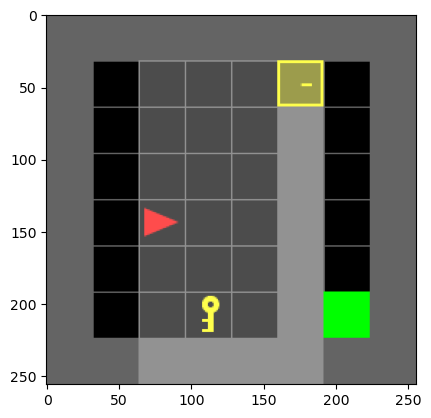

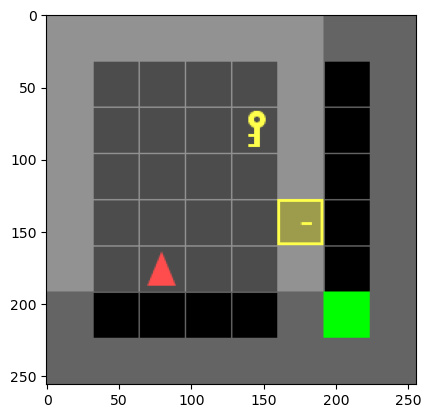

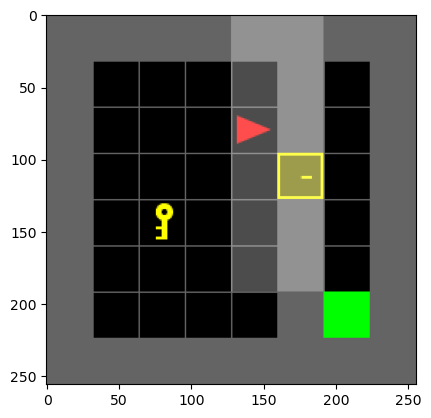

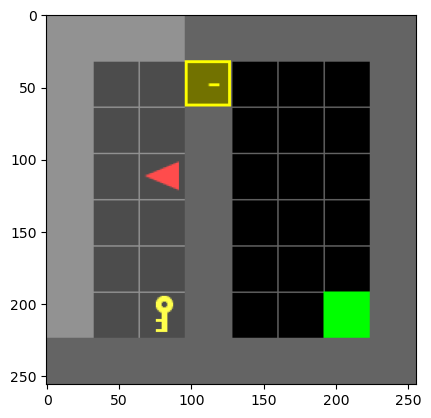

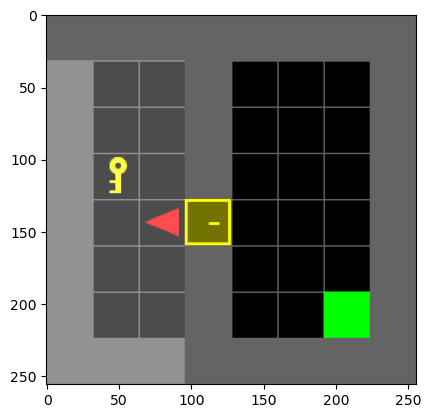

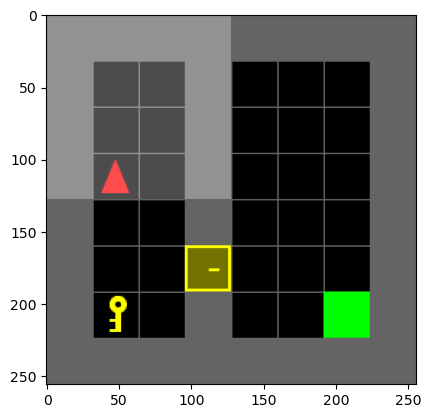

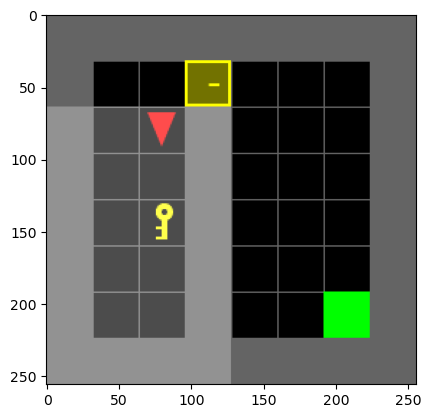

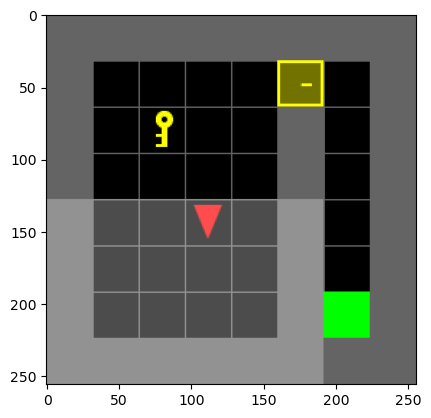

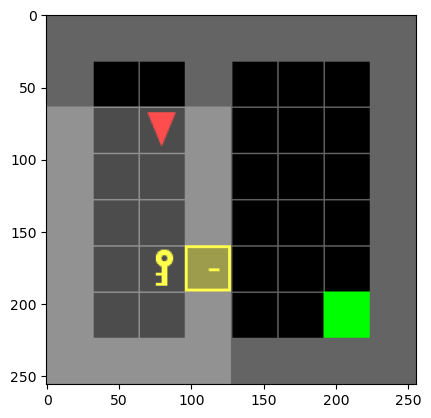

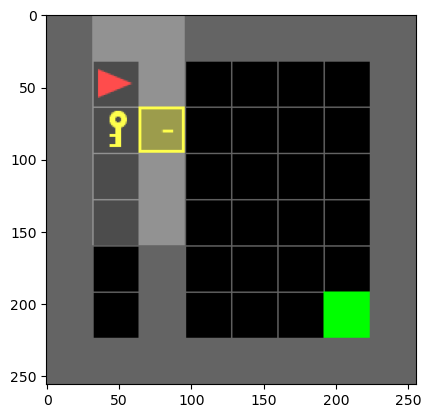

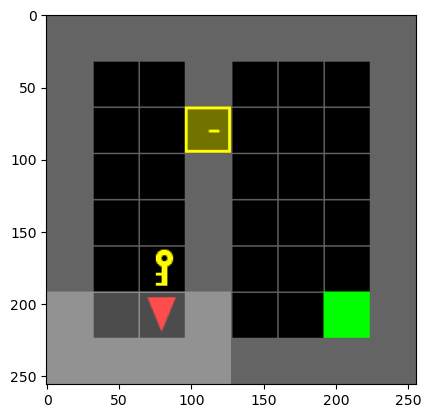

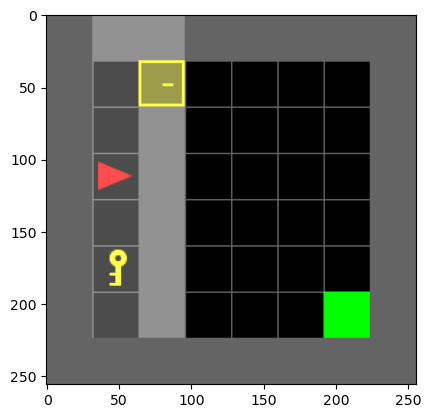

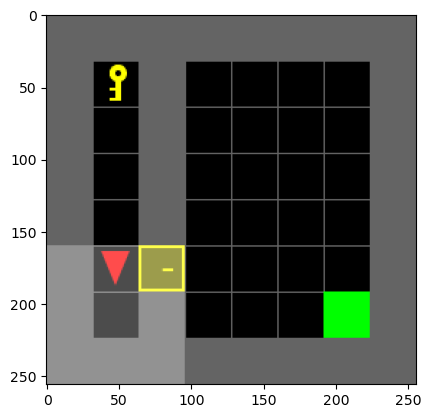

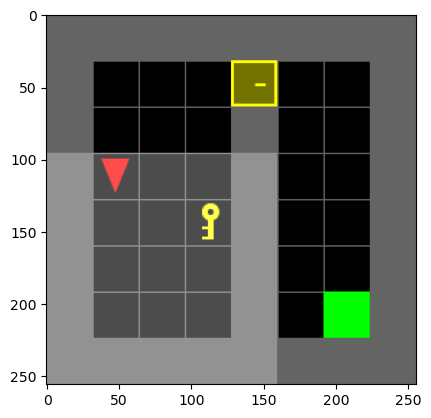

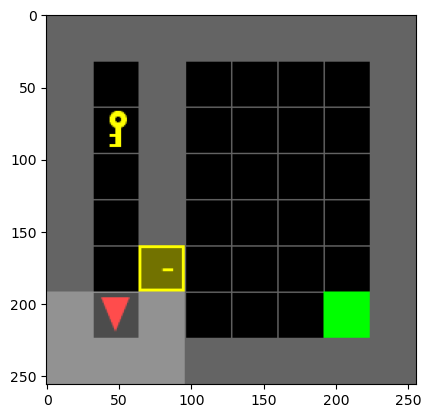

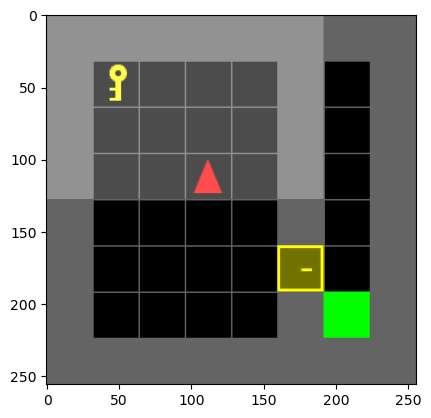

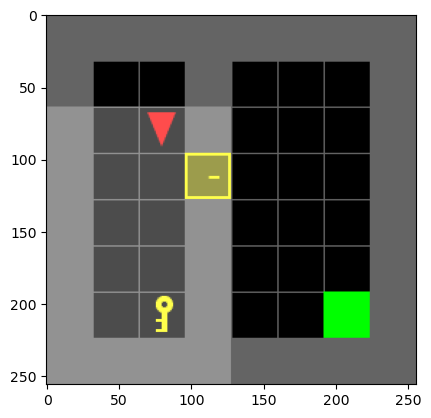

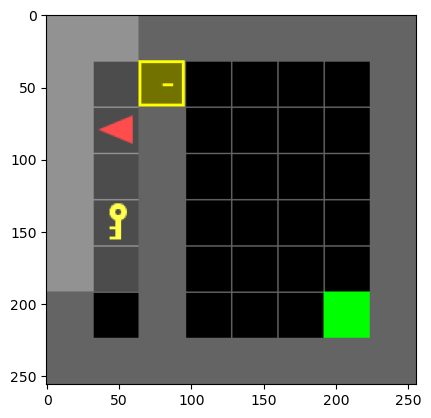

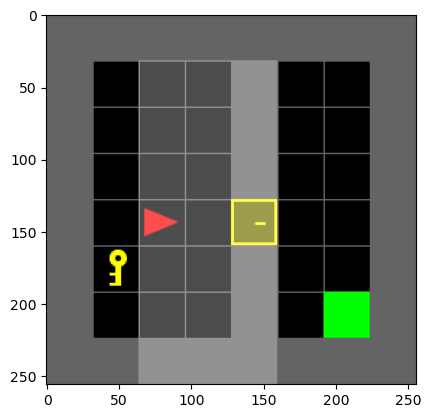

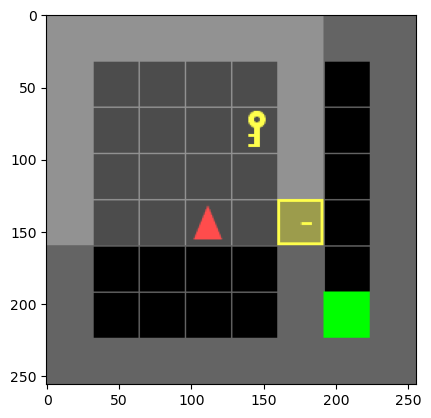

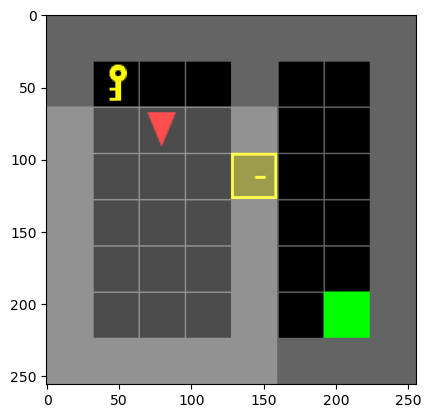

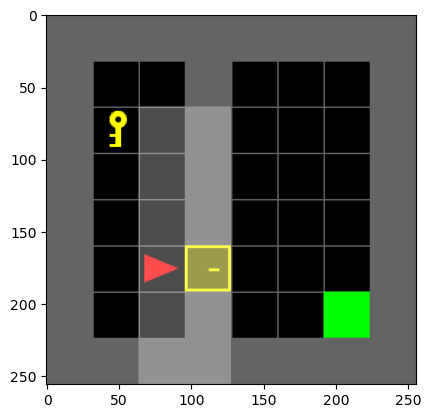

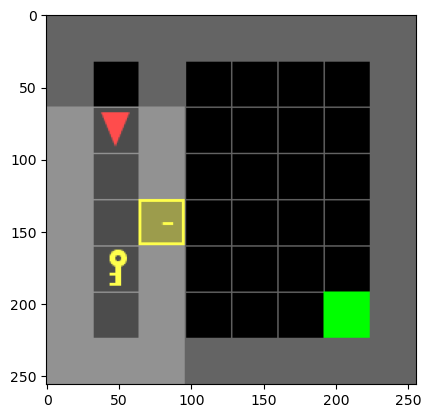

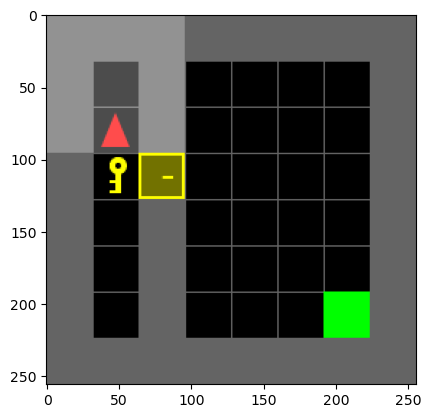

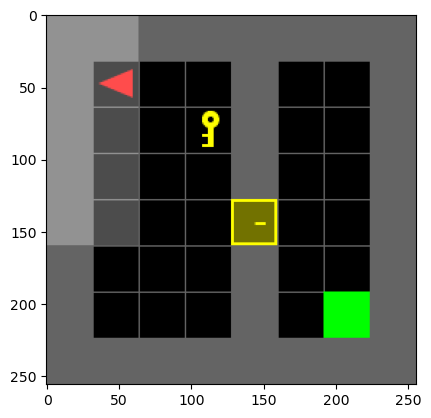

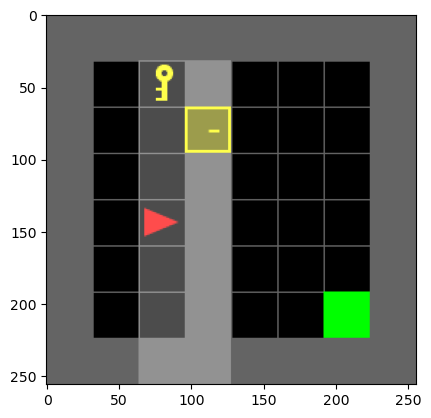

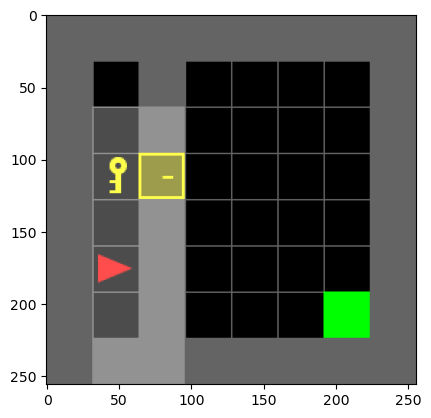

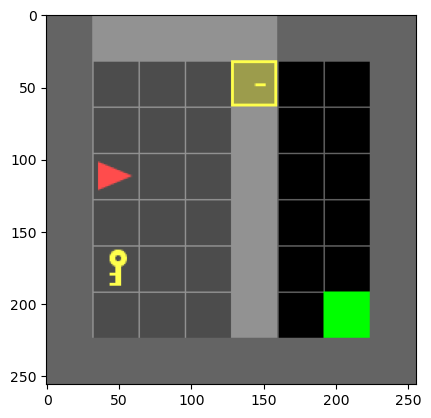

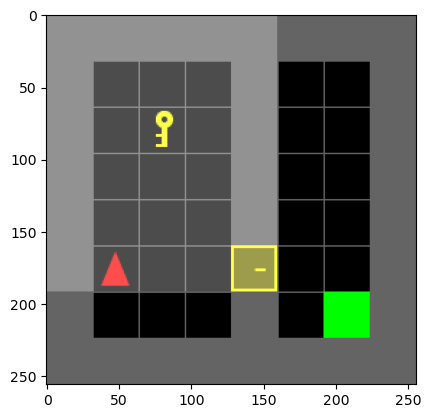

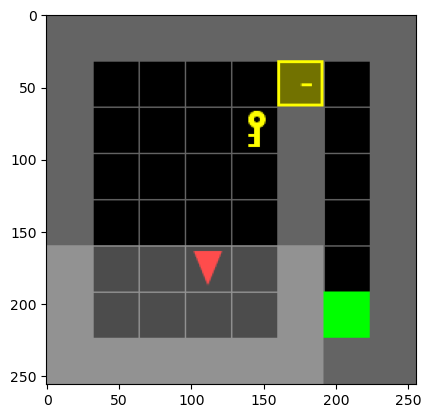

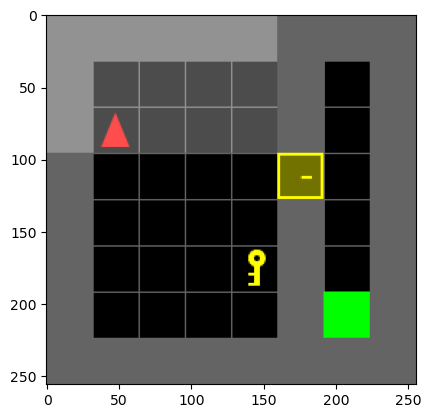

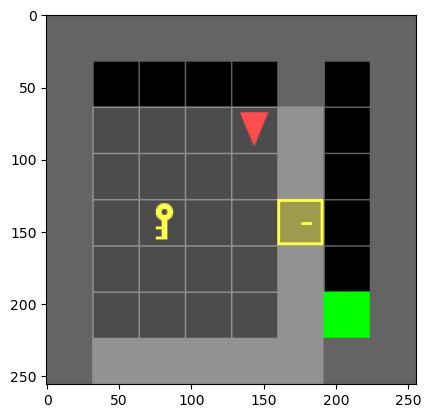

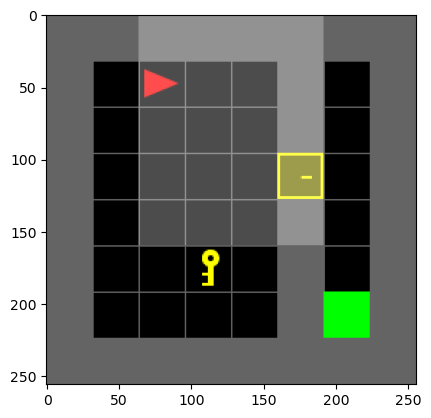

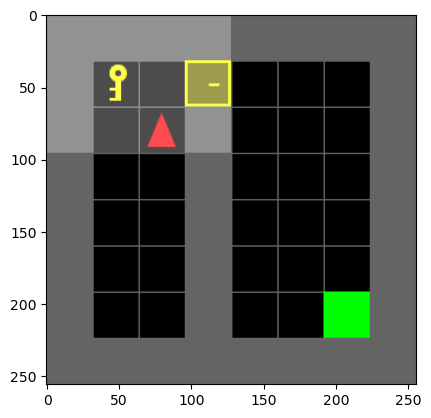

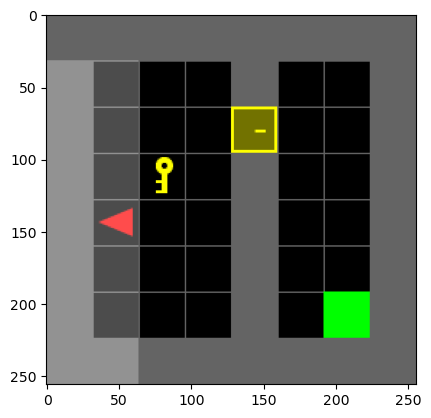

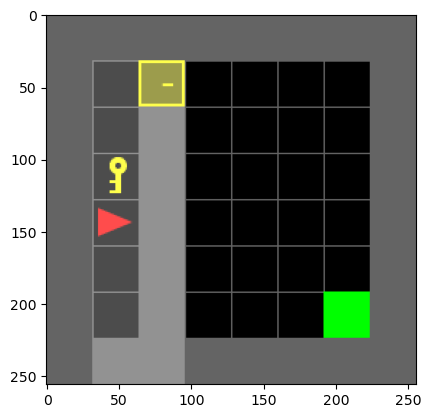

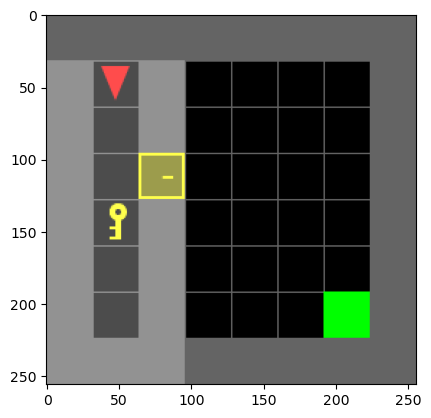

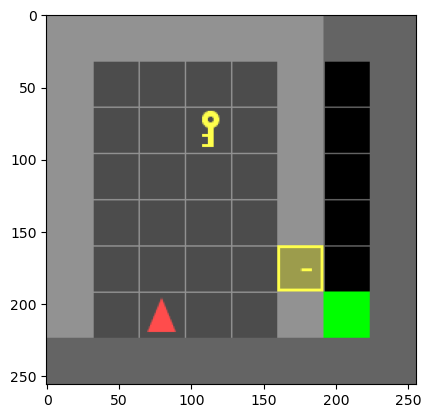

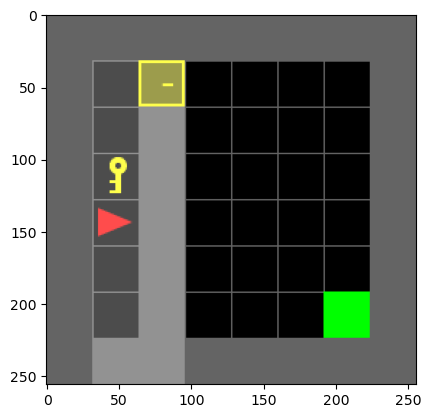

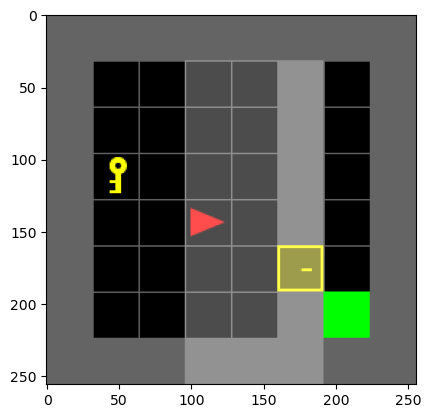

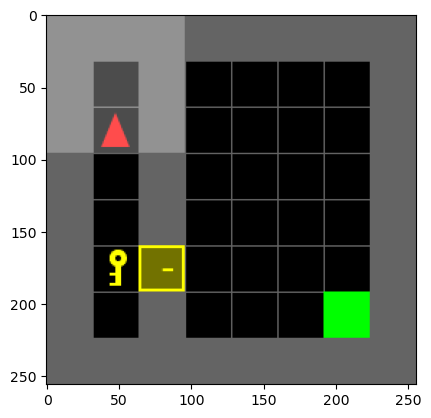

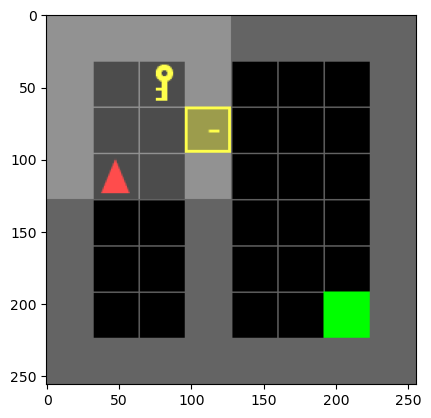

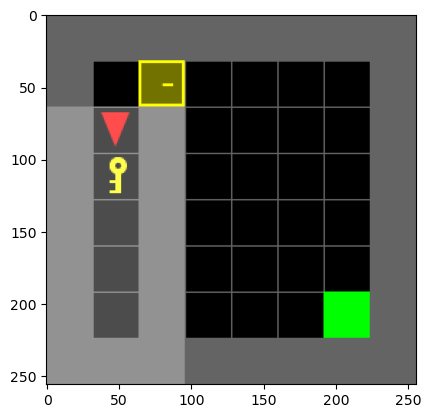

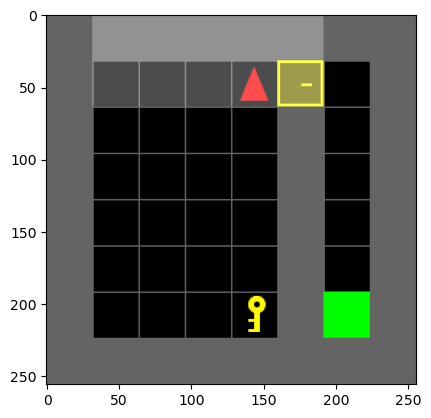

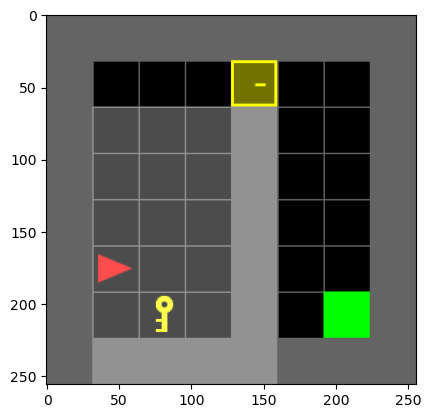

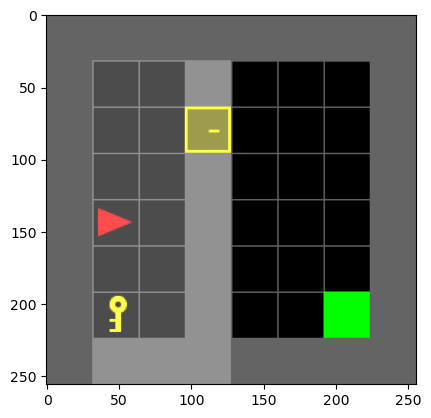

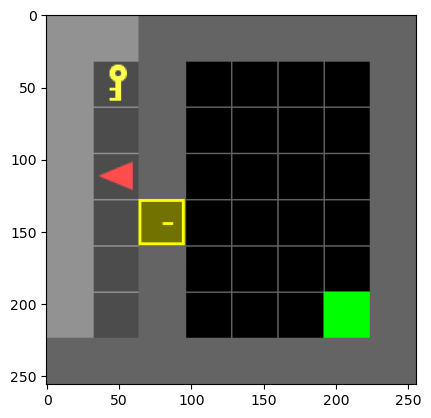

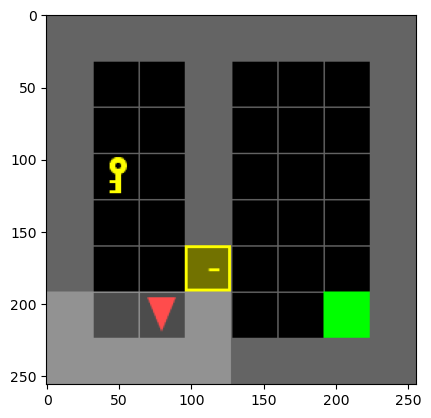

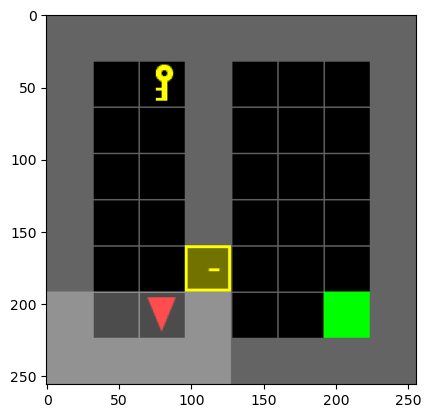

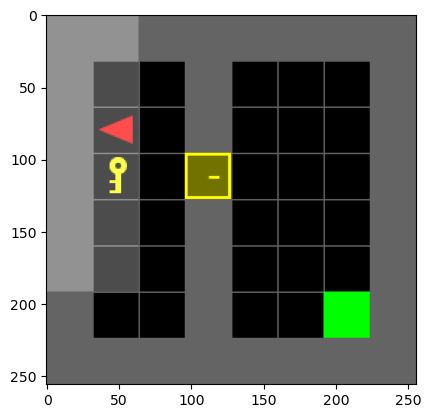

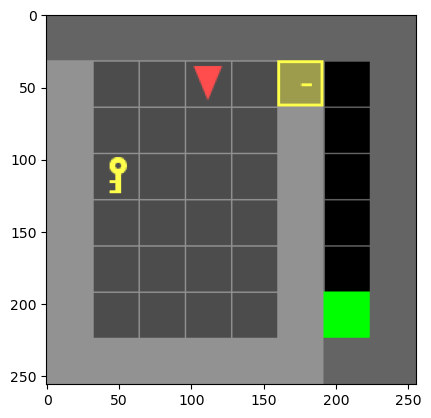

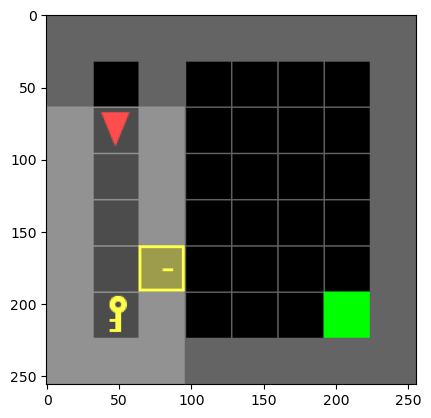

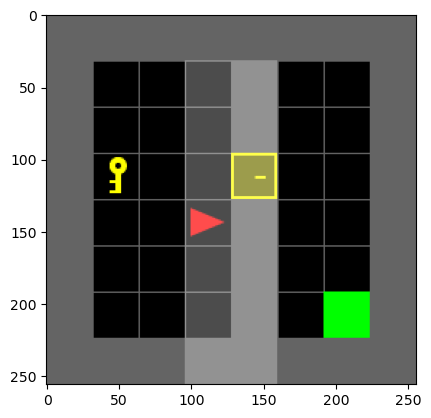

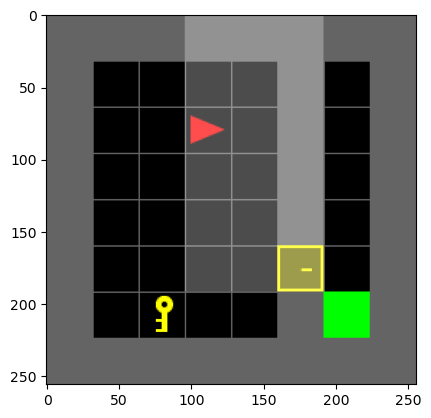

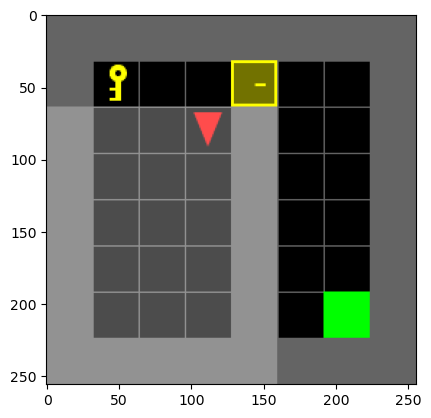

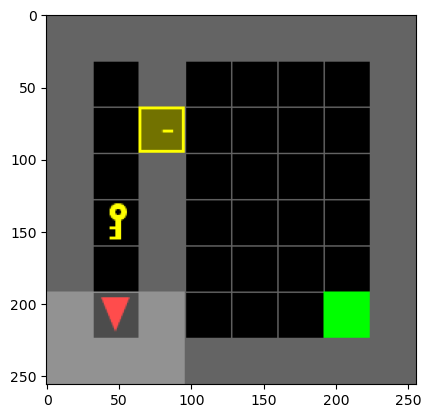

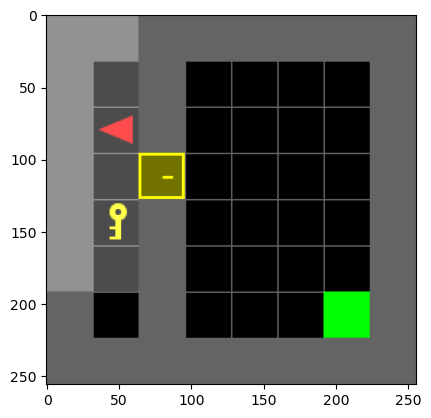

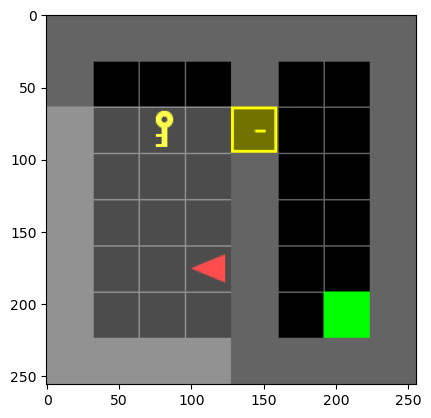

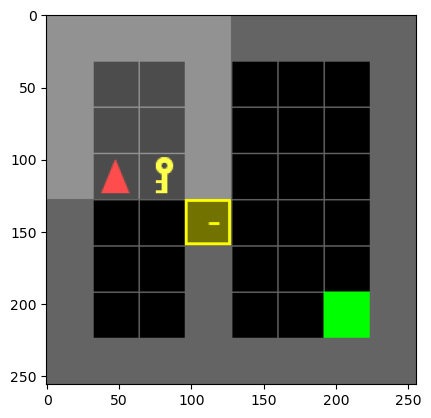

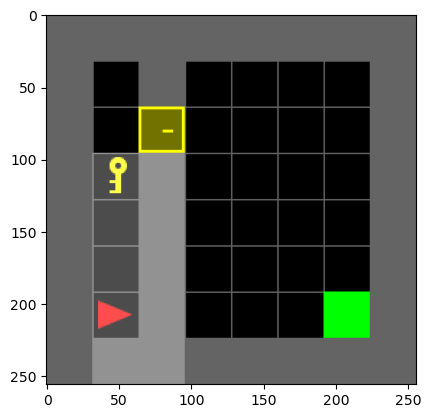

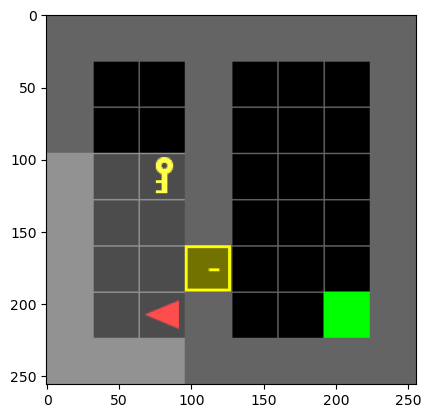

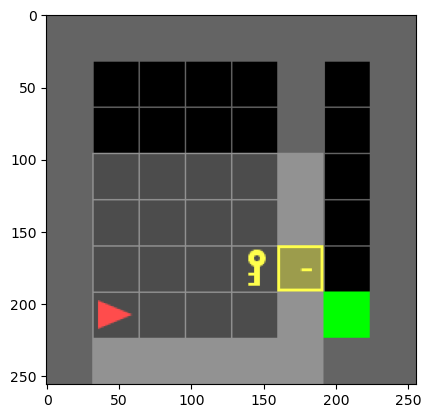

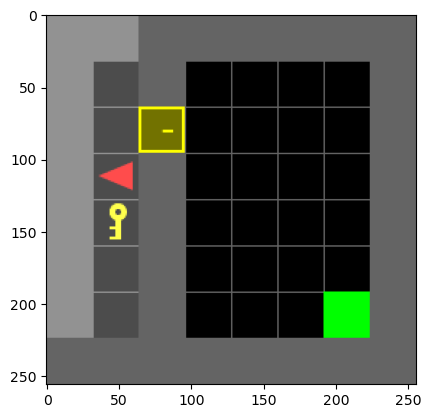

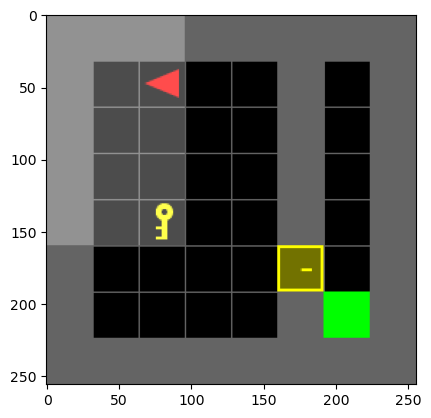

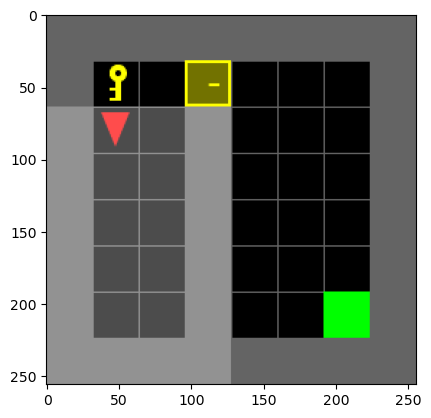

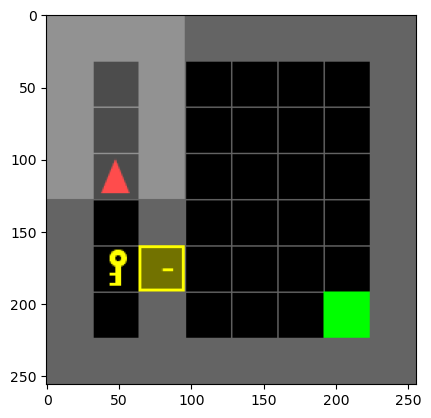

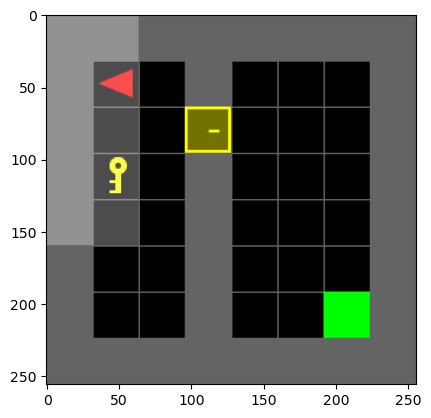

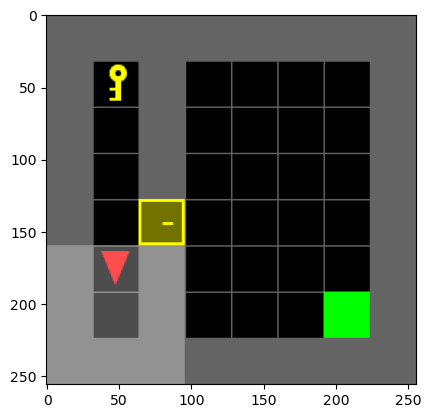

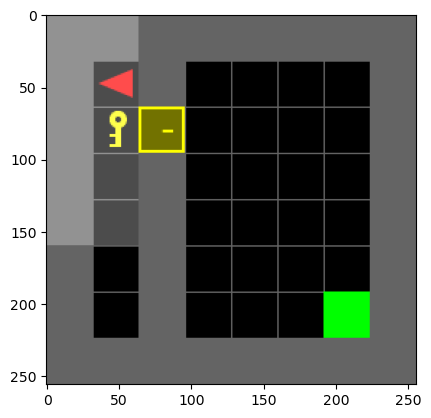

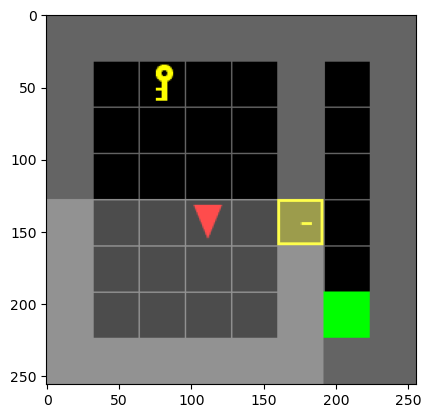

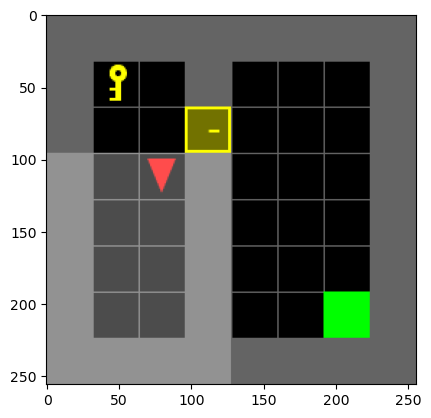

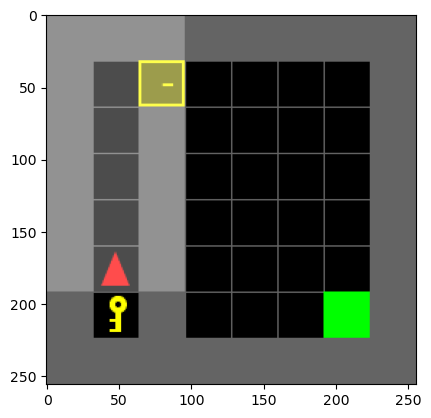

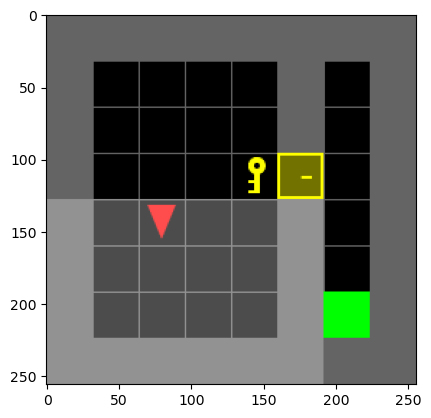

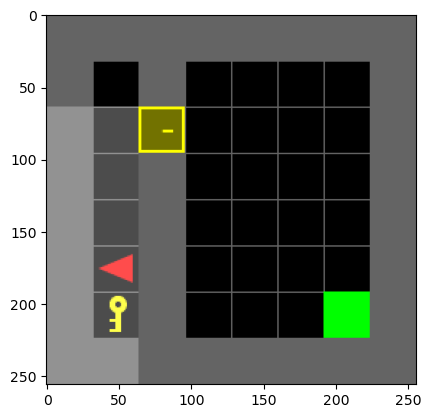

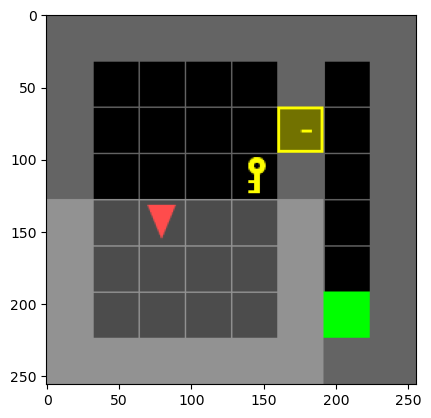

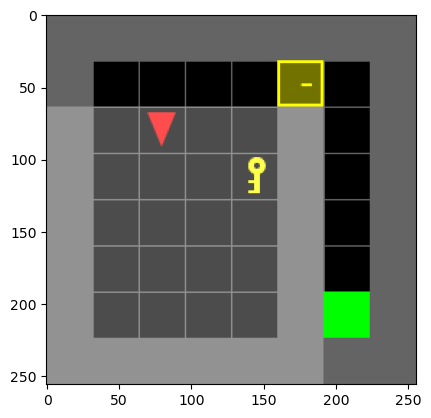

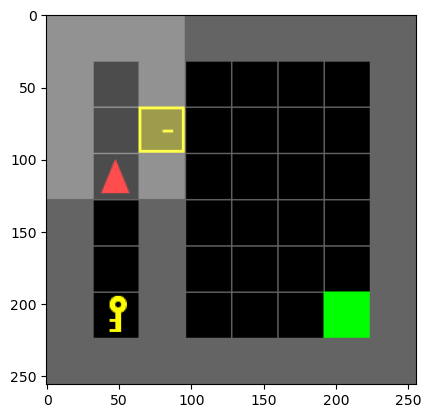

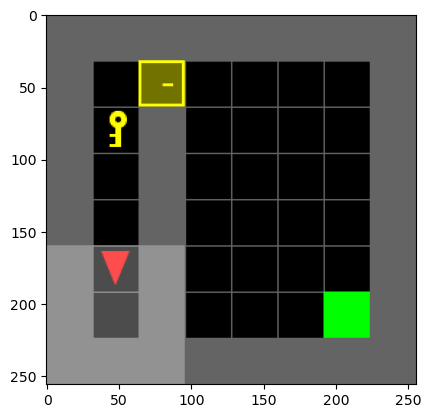

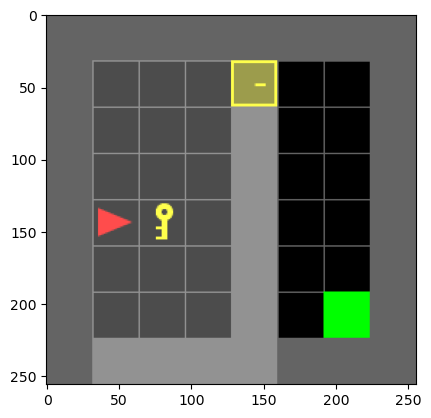

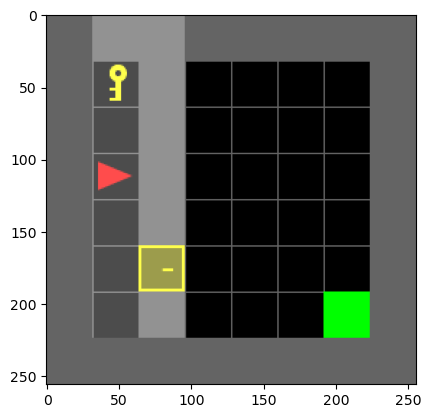

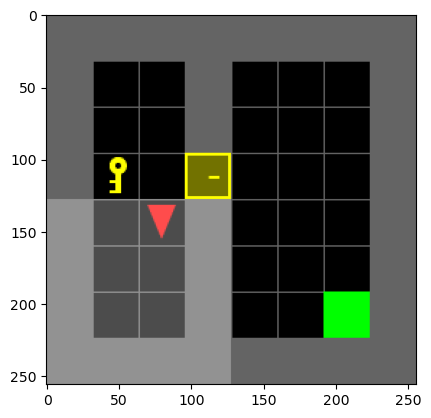

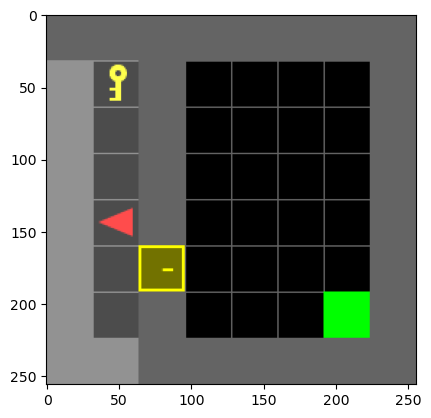

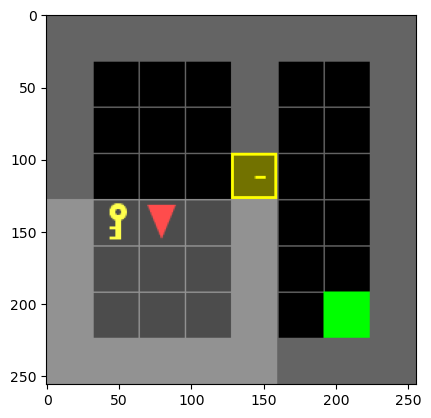

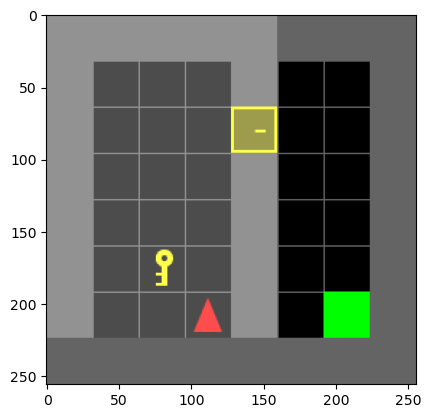

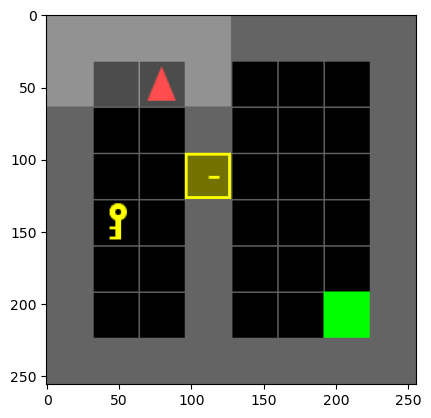

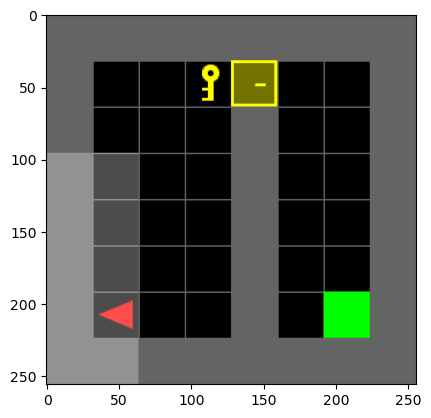

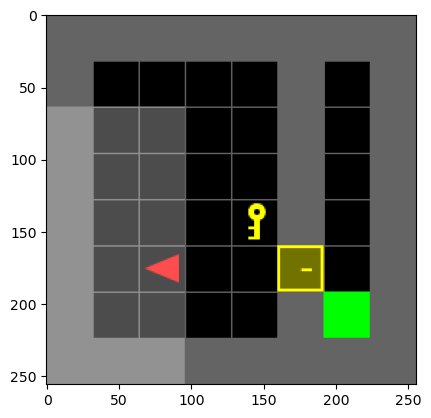

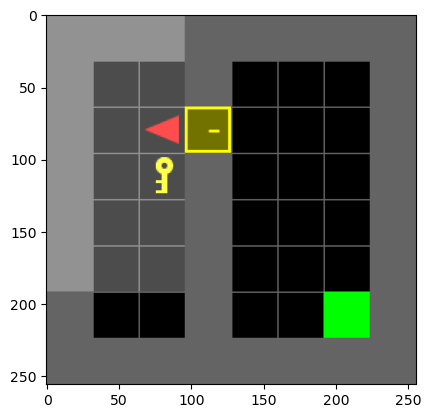

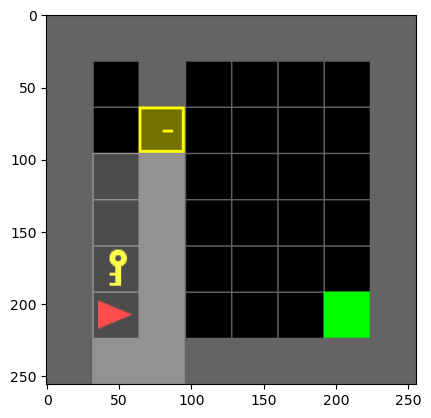

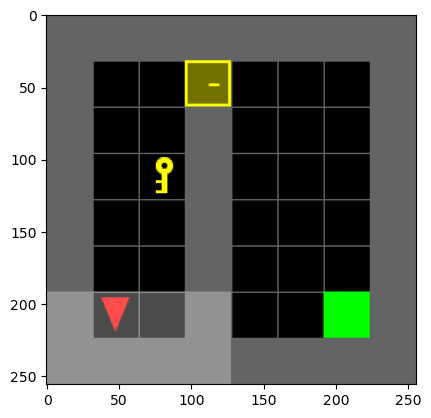

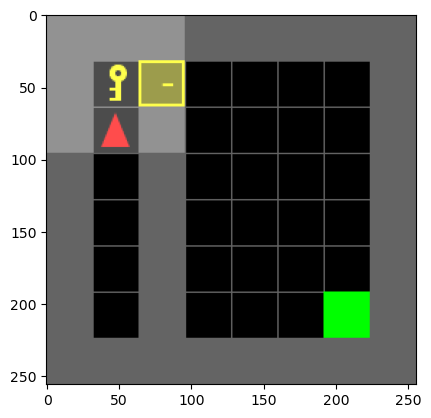

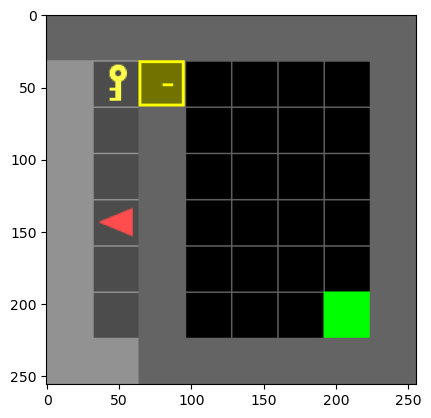

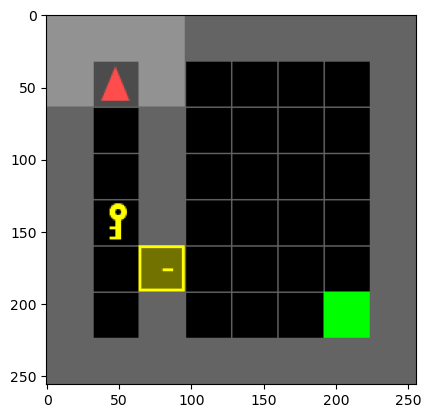

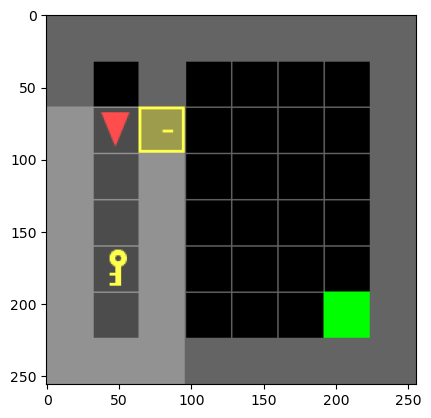

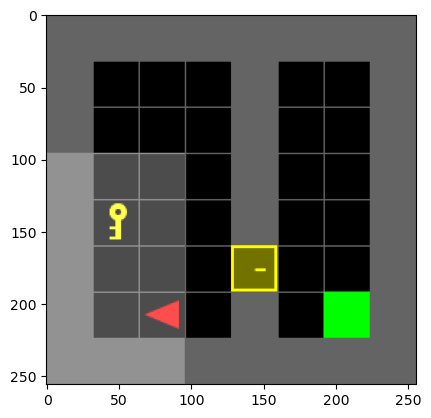

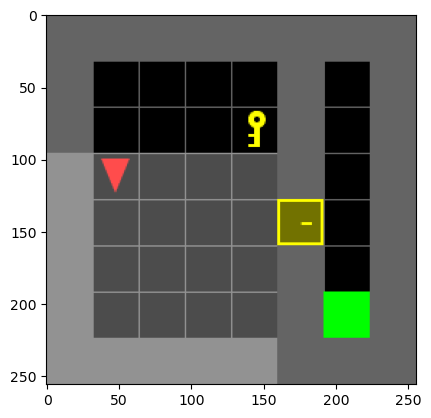

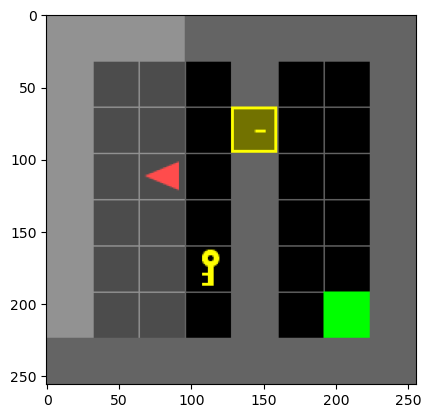

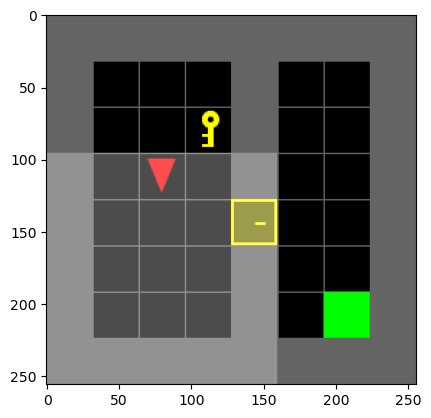

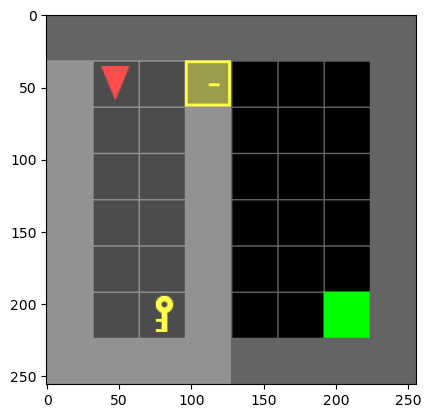

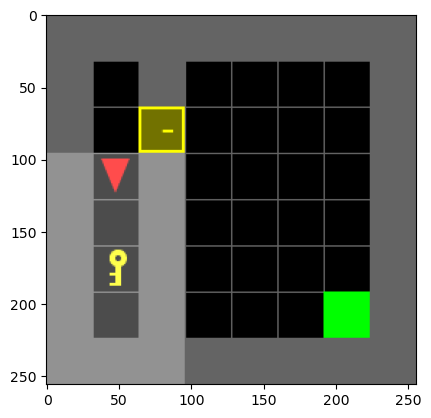

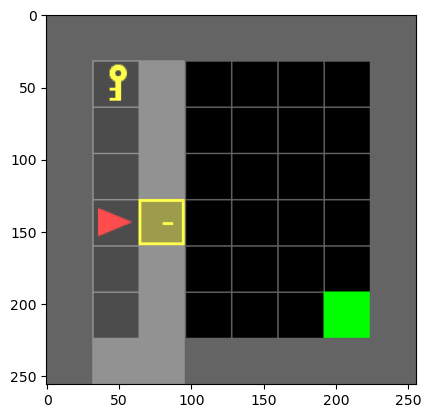

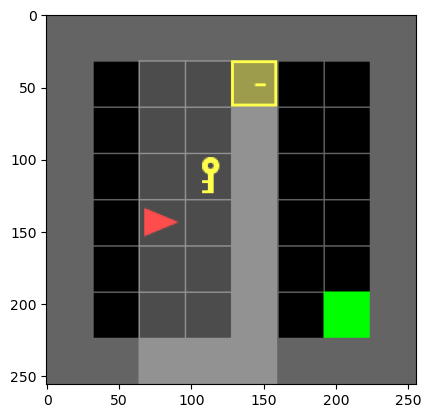

KeyboardInterrupt: 

In [ ]:
episode_rewards = []
gamma = 0.98
eps = 0.2
w = tensorboard.SummaryWriter()
s = 0
max_grad_norm = 0.5

i = 0
while i < 100:
    prev_prob_act = None
    done = False
    total_reward = 0
    state = env.reset()
    state, _ = state


    while not done:
        s += 1

        probs = actor(t(state)).squeeze()
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        prob_act = dist.log_prob(action)

        next_state, reward, done, info, _ = env.step(action.detach().data.numpy().squeeze().item())
        
        if False:
            print(action, "ACTION")
            print("STATE", np.sum(state))
            print(reward, "REWARD")
        
        if done:
            print('*************************', done, '**********************')
            i += 1

        if not done and s > 50000:
            # Lost
            reward = -0.1
            done = True

        if s % 5000 == 0:
            img = env.render()
            #w.add_image("env", img, global_step=s)
            plt.imshow(img)
            plt.show()

        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        
        w.add_scalar("loss/advantage", advantage, global_step=s)
        w.add_scalar("actions/action_turn_left", dist.probs[0], global_step=s)
        w.add_scalar("actions/action_turn_right", dist.probs[1], global_step=s)
        w.add_scalar("actions/action_forward", dist.probs[2], global_step=s)
        w.add_scalar("actions/action_pickup", dist.probs[3], global_step=s)
        w.add_scalar("actions/action_drop", dist.probs[4], global_step=s)
        w.add_scalar("actions/action_toggle", dist.probs[5], global_step=s)
        w.add_scalar("actions/action_done", dist.probs[6], global_step=s)
        # w.add_scalar("state/agent_pos", env.agent_pos, global_step=s)
        
        total_reward += reward
        state = next_state
        
        if prev_prob_act:
            actor_loss = policy_loss(prev_prob_act.detach(), prob_act, advantage.detach(), eps)
            w.add_scalar("loss/actor_loss", actor_loss, global_step=s)
            adam_actor.zero_grad()
            actor_loss.backward()
            # clip_grad_norm_(adam_actor, max_grad_norm)
            w.add_histogram("gradients/actor",
                             torch.cat([p.grad.view(-1) for p in actor.parameters()]), global_step=s)
            adam_actor.step()

            critic_loss = advantage.pow(2).mean()
            w.add_scalar("loss/critic_loss", critic_loss, global_step=s)
            adam_critic.zero_grad()
            critic_loss.backward()
            # clip_grad_norm_(adam_critic, max_grad_norm)
            w.add_histogram("gradients/critic",
                             torch.cat([p.data.view(-1) for p in critic.parameters()]), global_step=s)
            adam_critic.step()
        
        prev_prob_act = prob_act
    
    w.add_scalar("reward/episode_reward", total_reward, global_step=i)
    episode_rewards.append(total_reward)

In [45]:
env.take_action(9, 2)

AttributeError: 'PositionBonus' object has no attribute 'take_action'

In [13]:
s

56579

In [14]:
w

In [15]:
episode_rewards

[np.float64(-707.0),
 np.float64(-62.0),
 np.float64(-294.0),
 np.float64(-202.0),
 np.float64(-732.0),
 np.float64(-114.0),
 np.float64(-1651.0),
 np.float64(-522.0),
 np.float64(-396.0),
 np.float64(-255.0),
 np.float64(-329.0),
 np.float64(-656.0),
 np.float64(-148.0),
 np.float64(-38.0),
 np.float64(-6.0),
 np.float64(-132.0),
 np.float64(-754.0),
 np.float64(-746.0),
 np.float64(-156.0),
 np.float64(-212.0),
 np.float64(-246.0),
 np.float64(-55.0),
 np.float64(-195.0),
 np.float64(-81.0),
 np.float64(-83.0),
 np.float64(-350.0),
 np.float64(-350.0),
 np.float64(-649.0),
 np.float64(-224.0),
 np.float64(-254.0),
 np.float64(-13.0),
 np.float64(-134.0),
 np.float64(-229.0),
 np.float64(-479.0),
 np.float64(-133.0),
 np.float64(-107.0),
 np.float64(-409.0),
 np.float64(-228.0),
 np.float64(-208.0),
 np.float64(-43.0),
 np.float64(-636.0),
 np.float64(-154.0),
 np.float64(-340.0),
 np.float64(-167.0),
 np.float64(-137.0),
 np.float64(-29.0),
 np.float64(-20.0),
 np.float64(-101.0),
 n

In [16]:
gridworld.take_action([4,4], 0)

array([3, 4])

In [1]:
plt.plot(episode_rewards)

NameError: name 'plt' is not defined